## Applied Deep Learning - CSE510
# Anomaly Detection
#### By
### **Mohamed Fazil M S [ubid - mm549]**

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='once')
%matplotlib inline
sns.set(style="darkgrid")

## Part I: MLP for Anomaly Detection

### Choosing Dataset from NAB

#### Online Advertisement Clicking Rates

Online advertisement clicking rates which contains a real Cost Per click values of a specific ad in time series recorded every hour.
- We will be using the data set without anomalies as **training data**
- We will be using the data set with anomalies as **testing data** to detect anomalies.
> Training Dataset(without Anomalies) - https://github.com/numenta/NAB/blob/master/data/realAdExchange/exchange-2_cpc_results.csv
> Testing Dataset(with Anomalies) - https://github.com/numenta/NAB/blob/master/data/realAdExchange/exchange-4_cpc_results.csv

In [4]:
df = pd.read_csv('NAB/data/realAdExchange/exchange-2_cpc_results.csv',index_col=0)
df_test = pd.read_csv('NAB/data/realAdExchange/exchange-4_cpc_results.csv',index_col=0)

### Training Data (Without Anomalies) Info and Visualization

In [5]:
df.index = pd.to_datetime(df.index) #Convert Index to DateTime Object
print("Total Number of Variables ->",df.shape[1])
print("Total Number of Entries ->",df.shape[0])
print("\nShape of the data: ", df.shape)
# Check for Missing Values
print('Check Missing Values')
print('--------------------')
print(df.isnull().sum())
print(df.describe())
df.head()

Total Number of Variables -> 1
Total Number of Entries -> 1624

Shape of the data:  (1624, 1)
Check Missing Values
--------------------
value    0
dtype: int64
             value
count  1624.000000
mean      0.101823
std       0.033729
min       0.026843
25%       0.076633
50%       0.100833
75%       0.123618
max       0.226598


value
timestamp                    
2011-07-01 00:00:01  0.081965
2011-07-01 01:00:01  0.098972
2011-07-01 02:00:01  0.065314
2011-07-01 03:00:01  0.070663
2011-07-01 04:00:01  0.102490

#### Timeseries Plot of the Data

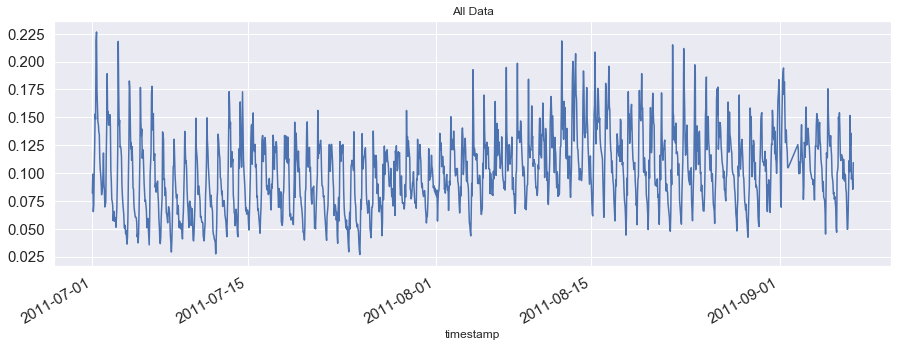

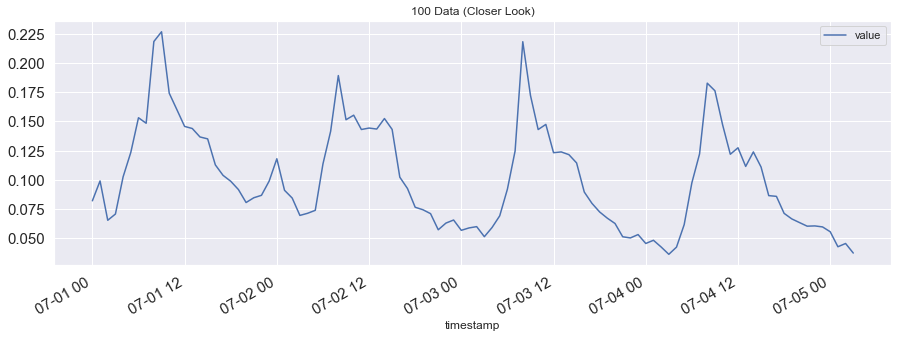

In [6]:
df[df.columns[0]].plot(title = '{}'.format('All Data'),fontsize=15, figsize=(15,5))
df.iloc[0:100].plot(title = '{}'.format('100 Data (Closer Look)'),fontsize=15, figsize=(15,5))

#### Statioanry Test 

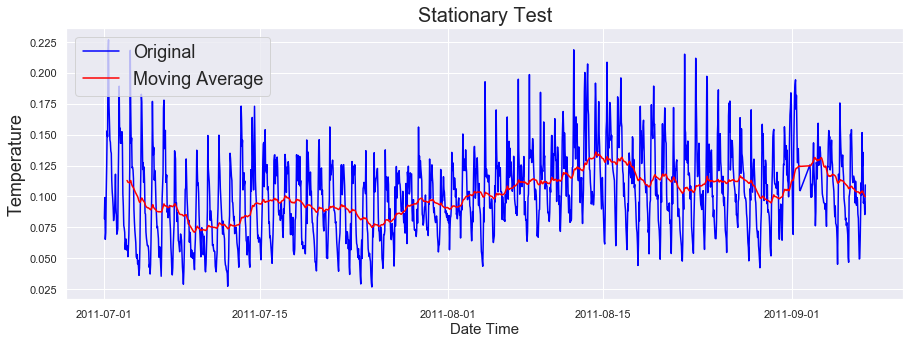

Text(0.5, 1.0, 'Standard Deviation')

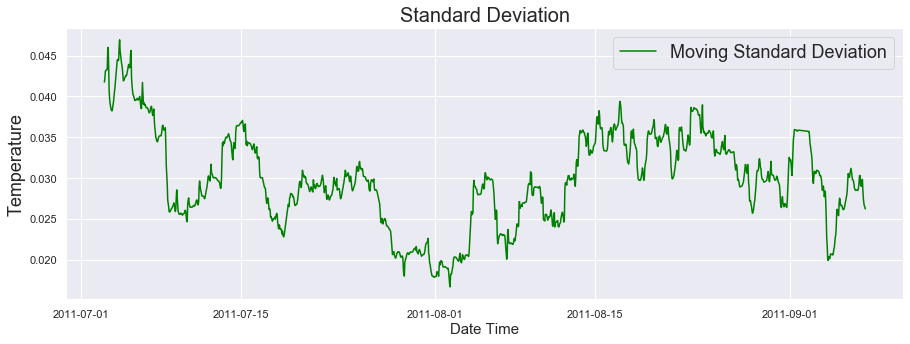

In [7]:
window = 50 #hours
plt.figure(figsize=(15,5))
plt.plot(df['value'],color='blue',label='Original')
plt.plot(df['value'].rolling(window).mean(),color='red',label='Moving Average')
plt.legend(loc='best',fontsize=18)
plt.xlabel('Date Time',fontsize=15)
plt.ylabel('Temperature',fontsize=18)
plt.title('Stationary Test',fontsize=20)
plt.show()
plt.figure(figsize=(15,5))
plt.plot(df['value'].rolling(window).std(),color='green',label='Moving Standard Deviation')
plt.legend(loc='best',fontsize=18)
plt.xlabel('Date Time',fontsize=15)
plt.ylabel('Temperature',fontsize=18)
plt.title('Standard Deviation',fontsize=20)

### Testing Data (With Anomalies) Info and Visualization

In [8]:
df_test.index = pd.to_datetime(df_test.index) #Convert Index to DateTime Object
print("Total Number of Variables ->",df_test.shape[1])
print("Total Number of Entries ->",df_test.shape[0])
print("\nShape of the data: ", df_test.shape)
# Check for Missing Values
print('Check Missing Values')
print('--------------------')
print(df_test.isnull().sum())
print(df_test.describe())
df_test.head()

Total Number of Variables -> 1
Total Number of Entries -> 1643

Shape of the data:  (1643, 1)
Check Missing Values
--------------------
value    0
dtype: int64
             value
count  1643.000000
mean      0.086439
std       0.128977
min       0.023884
25%       0.055185
50%       0.072820
75%       0.095459
max       3.126852


value
timestamp                    
2011-07-01 00:15:01  0.091795
2011-07-01 01:15:01  0.074414
2011-07-01 02:15:01  0.056984
2011-07-01 03:15:01  0.071225
2011-07-01 04:15:01  0.045466

#### Timeseries Plot of the Data

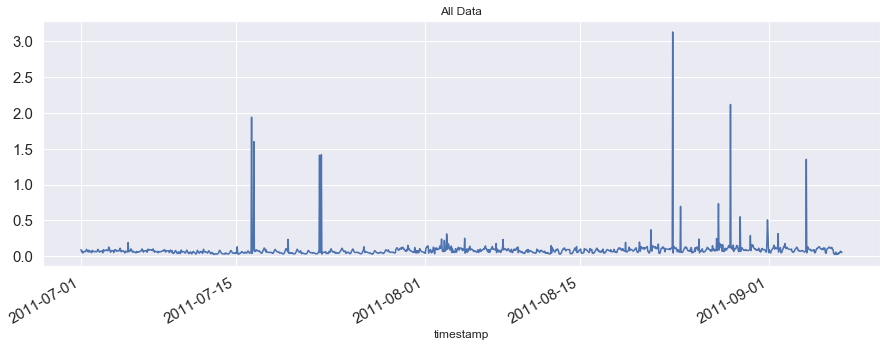

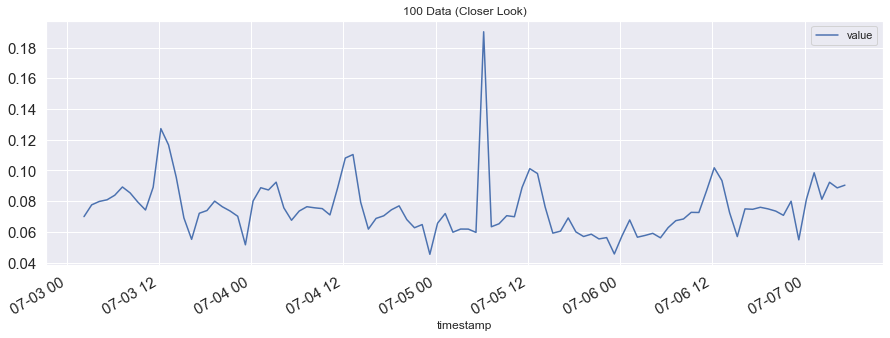

In [9]:
df_test[df_test.columns[0]].plot(title = '{}'.format('All Data'),fontsize=15, figsize=(15,5))
df_test.iloc[50:150].plot(title = '{}'.format('100 Data (Closer Look)'),fontsize=15, figsize=(15,5))

#### Statioanry Test 

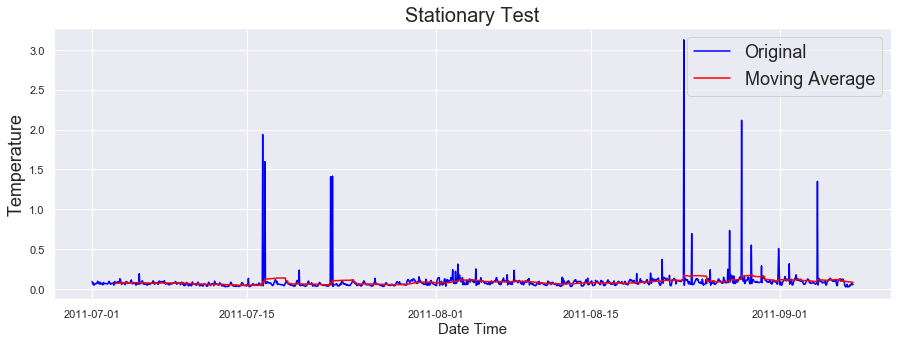

Text(0.5, 1.0, 'Standard Deviation')

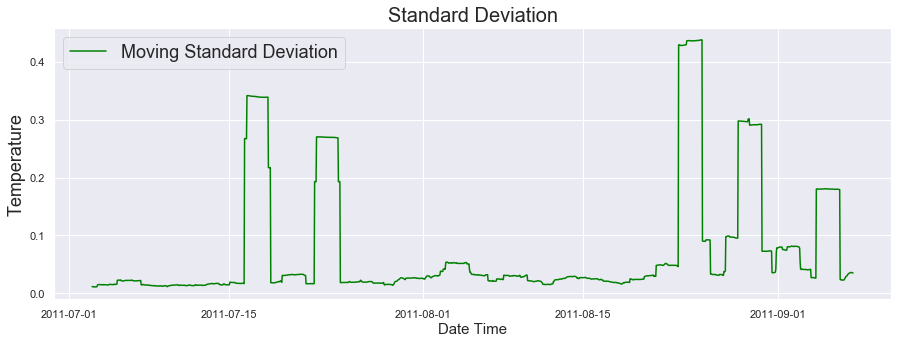

In [10]:
window = 50 #hours
plt.figure(figsize=(15,5))
plt.plot(df_test['value'],color='blue',label='Original')
plt.plot(df_test['value'].rolling(window).mean(),color='red',label='Moving Average')
plt.legend(loc='best',fontsize=18)
plt.xlabel('Date Time',fontsize=15)
plt.ylabel('Temperature',fontsize=18)
plt.title('Stationary Test',fontsize=20)
plt.show()
plt.figure(figsize=(15,5))
plt.plot(df_test['value'].rolling(window).std(),color='green',label='Moving Standard Deviation')
plt.legend(loc='best',fontsize=18)
plt.xlabel('Date Time',fontsize=15)
plt.ylabel('Temperature',fontsize=18)
plt.title('Standard Deviation',fontsize=20)

### Generating Testing and Training Dataset

In [140]:
'''
function - data_generator
Inputs
window - window Size (Number of  Values to predict/reconstruct)
dataframe - Input Timeseries Univariate Dataframe
'''
def data_generator(window,dataframe):
    new_df = dataframe
    X = np.array(new_df[new_df.columns[0]])
    X_new = []
    for i in range(new_df.shape[0]):
        try:
            x = X[i:i+window]
            if(len(x)==window):
                X_new.append(x)
        except Exception as e:
            break
    X_new= np.array(X_new)
    print('X Shape',X_new.shape)
    return X_new

### Prediction/Reconstruction Problem
- We will be trying to predict or reconstruct the given within a period with given window size. 
- By training a model with datasets having no anomalies, it will help in identifying the anomalies present in testing dataset using the loss function.
- The Input Shape is equal to output shape

### Anomaly Detector Methodology
- As the reconstruction model is built using the dataset with no anomalies. 
- When a dataset with anomaly is is passed through this reconstruction model, the output is a reconstructed version of the dataset with **No Anomalies**
- Using a distance function to compute distance between the predicted and true data with anomalies and thresholding data points which has a higher distance than the mean we will be able say that it is an anomaly.

**Anomaly Detection Flow**
> Dataset with Anomalies --> Reconstruction Model --> Reconstructed Data with no Anomalies --> Compute Distance between Reconstructed data and True Data --> Label datapoints corresponding to higher Distance as Anomaly

#### Function to Plot the Trained Model Results

In [256]:
# Function to Plot Results
def plot_results(history1,name):
    print('Prediction/Reconstruction Accuracy -',history1.history['val_accuracy'][-1])
    print('Prediction/Reconstruction Loss -',history1.history['val_loss'][-1])
    plt.figure(figsize=(15,5))
    plt.plot(history1.history['loss'],label='Training Loss')
    plt.plot(history1.history['val_loss'],label='Testing Loss')
    plt.legend(loc='best',fontsize=15)
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('{} Loss'.format(name),fontsize=20)
    plt.show()
    plt.figure(figsize=(15,5))
    plt.plot(history1.history['accuracy'],label='Training accuracy')
    plt.plot(history1.history['val_accuracy'],label='Testing accuracy')
    plt.legend(loc='best',fontsize=15)
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.title('{} Accuracy'.format(name),fontsize=20)
    plt.show()

#### Distance Functions
3 Different Function to Get the Distance between predicted output and Test data.
- sqeuclidean Distance
- Euclidean Distance
- Minkowski Distance

In [17]:
from scipy.spatial.distance import euclidean, sqeuclidean
from scipy.spatial import minkowski_distance
from sklearn.metrics import confusion_matrix

def dist(name,arr1,arr2):
    distances = []
    for i in range(arr1.shape[0]):
            if(name=='sqeuclidean'):
                d = sqeuclidean(arr1[i],arr2[i])
                distances.append(d)
            if(name=='euclidean'):
                d = euclidean(arr1[i],arr2[i])
                distances.append(d)
            if(name=='minikowski'):
                d = minkowski_distance(arr1[i],arr2[i])
                distances.append(d)
    return np.array(distances)
                

#### Function to Visualize Anomalies Detected with the help of the Distance Calculated and return Anamoly Labeled Dataset

In [234]:
'''
distance_type - 'sqeuclidean', 'euclidean', 'minikowski'
'''  
def detect_anomaly(X_test,model1,distance_type):
    prediction = model1.predict(X_test)
    Distance = dist(distance_type,prediction,X_test)
    plt.figure(figsize=(15,5))
    plt.plot(Distance,label = 'Distance/Anomaly Value')
    plt.plot(np.array(df_test['value']),label = 'Test Data')
    plt.legend(loc='best',fontsize=15)
    plt.ylabel('Distance/Value',fontsize=15)
    plt.xlabel('Timeseries No.',fontsize=15)
    plt.title('Anomaly Visualization in Test Data [Distance function - {}]'.format(distance_type),fontsize=20)
    plt.show()
    mean_distance = Distance.mean() # Mean is the threshold
    true_data = np.array(df_test['value'])
    true_data = true_data[0:Distance.shape[0]]
    df_anomaly = pd.DataFrame(columns = ['Time','value','Anomaly'])
    for i in range(true_data.shape[0]):
        if(Distance[i]>mean_distance):
            df_anomaly = df_anomaly.append({'Time':df_test.index[i],'value':df_test['value'][i],'Anomaly':1} , ignore_index=True)
            # Label 1 Represents Anomaly
        else:
            df_anomaly = df_anomaly.append({'Time': df_test.index[i],'value':df_test['value'][i],'Anomaly':0} , ignore_index=True)
            # Label 0 Represents No Anomaly
    df_anomaly=df_anomaly.set_index('Time')
    plot_anomaly(df_anomaly,distance_type)
    return df_anomaly
# Confusion Matrix cant be ploted because we only have the labeled data we created from test data 
# and no true labeled data present verify true predictions.

In [242]:
def plot_anomaly(df_anomaly,distance_type):
    plt.figure(figsize=(15,5))
    y = df_anomaly.index
    anomaly = np.array(df_anomaly['Anomaly'])
    value = np.array(df_anomaly['value'])
    plt.plot(y,value,label='Cost Per Click')
    ynew = []
    valuenew = []
    for i in range(len(value)):
        if(anomaly[i]==1):
            ynew.append(y[i])
            valuenew.append(value[i])
    plt.scatter(ynew,valuenew,c='red',s=50, label = 'Anomaly')
    plt.ylabel('Cost Per Click',fontsize=15)
    plt.xlabel('Timeseries',fontsize=15)
    plt.legend(loc='best',fontsize=15)
    plt.title('Anomaly detection of Test Data [Distance function - {}]'.format(distance_type),fontsize=20)
    plt.show()

### Building Multilayer Neural Networks

In [85]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, BatchNormalization, LeakyReLU, Dropout
from keras.optimizers import Adam
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### Setup 1 [Window size - 10]

In [254]:
window = 10
print('Training Data Shape')
print('--------------------')
X_train = data_generator(window,df)
print('Testing Data Shape')
print('--------------------')
X_test = data_generator(window,df_test)

Training Data Shape
--------------------
X Shape (1615, 10)
Testing Data Shape
--------------------
X Shape (1634, 10)


In [108]:
# Model Building
model1 = Sequential()
model1.add(Dense(20, activation='relu', input_dim=X_train.shape[1]))
model1.add(Dense(20, activation='relu'))
model1.add(Dense(20, activation='relu'))

model1.add(Dense(X_train.shape[1], activation='relu')) 

model1.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])
model1.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_62 (Dense)             (None, 20)                220       
_________________________________________________________________
dense_63 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_64 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_65 (Dense)             (None, 10)                210       
Total params: 1,270
Trainable params: 1,270
Non-trainable params: 0
_________________________________________________________________


In [109]:
history1 = model1.fit(X_train, X_train,
          validation_data=(X_test, X_test), 
          epochs=3000, 
          batch_size=500)

Train on 1615 samples, validate on 1634 samples
Epoch 1/3000
1615/1615 [==============================] - 0s 87us/step - loss: 0.0089 - accuracy: 0.2576 - val_loss: 0.0207 - val_accuracy: 0.1536
Epoch 2/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0076 - accuracy: 0.2328 - val_loss: 0.0197 - val_accuracy: 0.0667
Epoch 3/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0063 - accuracy: 0.0960 - val_loss: 0.0189 - val_accuracy: 0.1047
Epoch 4/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0052 - accuracy: 0.0960 - val_loss: 0.0183 - val_accuracy: 0.1114
Epoch 5/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0045 - accuracy: 0.1207 - val_loss: 0.0179 - val_accuracy: 0.1114
Epoch 6/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0041 - accuracy: 0.1207 - val_loss: 0.0174 - val_accuracy: 0.1151
Epoch 7/3000
1615/1615 [==============================] - 0s 15us/step

Epoch 56/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0013 - accuracy: 0.3864 - val_loss: 0.0140 - val_accuracy: 0.3947
Epoch 57/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0013 - accuracy: 0.3950 - val_loss: 0.0140 - val_accuracy: 0.3984
Epoch 58/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0013 - accuracy: 0.3975 - val_loss: 0.0140 - val_accuracy: 0.3966
Epoch 59/3000
1615/1615 [==============================] - 0s 14us/step - loss: 0.0013 - accuracy: 0.3969 - val_loss: 0.0139 - val_accuracy: 0.4051
Epoch 60/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0013 - accuracy: 0.4093 - val_loss: 0.0139 - val_accuracy: 0.4070
Epoch 61/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0013 - accuracy: 0.4111 - val_loss: 0.0139 - val_accuracy: 0.4082
Epoch 62/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0013 - accuracy: 0.4074 - val_

1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.6025 - val_loss: 0.0118 - val_accuracy: 0.5312
Epoch 167/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.5963 - val_loss: 0.0118 - val_accuracy: 0.5355
Epoch 168/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.5969 - val_loss: 0.0118 - val_accuracy: 0.5318
Epoch 169/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.6050 - val_loss: 0.0118 - val_accuracy: 0.5349
Epoch 170/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.5975 - val_loss: 0.0118 - val_accuracy: 0.5337
Epoch 171/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.6031 - val_loss: 0.0117 - val_accuracy: 0.5355
Epoch 172/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.6056 - val_loss: 0.

1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.6378 - val_loss: 0.0114 - val_accuracy: 0.5698
Epoch 222/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.6378 - val_loss: 0.0114 - val_accuracy: 0.5704
Epoch 223/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.6378 - val_loss: 0.0114 - val_accuracy: 0.5704
Epoch 224/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.6353 - val_loss: 0.0114 - val_accuracy: 0.5679
Epoch 225/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.6390 - val_loss: 0.0113 - val_accuracy: 0.5667
Epoch 226/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.6440 - val_loss: 0.0113 - val_accuracy: 0.5692
Epoch 227/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.6390 - val_loss: 0.

1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.6625 - val_loss: 0.0110 - val_accuracy: 0.5998
Epoch 277/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.6632 - val_loss: 0.0110 - val_accuracy: 0.6004
Epoch 278/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.6656 - val_loss: 0.0110 - val_accuracy: 0.6040
Epoch 279/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.6681 - val_loss: 0.0110 - val_accuracy: 0.5991
Epoch 280/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.6644 - val_loss: 0.0110 - val_accuracy: 0.6028
Epoch 281/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.6625 - val_loss: 0.0110 - val_accuracy: 0.5998
Epoch 282/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.6675 - val_loss: 0.

Epoch 331/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.6861 - val_loss: 0.0107 - val_accuracy: 0.6346
Epoch 332/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.6873 - val_loss: 0.0107 - val_accuracy: 0.6346
Epoch 333/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.6861 - val_loss: 0.0107 - val_accuracy: 0.6279
Epoch 334/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.6842 - val_loss: 0.0107 - val_accuracy: 0.6304
Epoch 335/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.6898 - val_loss: 0.0107 - val_accuracy: 0.6328
Epoch 336/3000
1615/1615 [==============================] - 0s 14us/step - loss: 0.0012 - accuracy: 0.6910 - val_loss: 0.0107 - val_accuracy: 0.6316
Epoch 337/3000
1615/1615 [==============================] - 0s 17us/step - loss: 0.0012 - accuracy: 0.6842

Epoch 386/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.7065 - val_loss: 0.0105 - val_accuracy: 0.6512
Epoch 387/3000
1615/1615 [==============================] - 0s 17us/step - loss: 0.0012 - accuracy: 0.7059 - val_loss: 0.0105 - val_accuracy: 0.6518
Epoch 388/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.7133 - val_loss: 0.0105 - val_accuracy: 0.6524
Epoch 389/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.7170 - val_loss: 0.0105 - val_accuracy: 0.6548
Epoch 390/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.7102 - val_loss: 0.0105 - val_accuracy: 0.6518
Epoch 391/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.7059 - val_loss: 0.0105 - val_accuracy: 0.6542
Epoch 392/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.7133

Epoch 441/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.7269 - val_loss: 0.0104 - val_accuracy: 0.6683
Epoch 442/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.7269 - val_loss: 0.0104 - val_accuracy: 0.6628
Epoch 443/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.7245 - val_loss: 0.0104 - val_accuracy: 0.6677
Epoch 444/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.7282 - val_loss: 0.0104 - val_accuracy: 0.6683
Epoch 445/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.7313 - val_loss: 0.0104 - val_accuracy: 0.6665
Epoch 446/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.7319 - val_loss: 0.0104 - val_accuracy: 0.6659
Epoch 447/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.7294

Epoch 496/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.7393 - val_loss: 0.0103 - val_accuracy: 0.6922
Epoch 497/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.7480 - val_loss: 0.0103 - val_accuracy: 0.6897
Epoch 498/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.7387 - val_loss: 0.0102 - val_accuracy: 0.6848
Epoch 499/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.7362 - val_loss: 0.0102 - val_accuracy: 0.6903
Epoch 500/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.7399 - val_loss: 0.0102 - val_accuracy: 0.6940
Epoch 501/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.7467 - val_loss: 0.0102 - val_accuracy: 0.6934
Epoch 502/3000
1615/1615 [==============================] - 0s 17us/step - loss: 0.0012 - accuracy: 0.7449

Epoch 551/3000
1615/1615 [==============================] - 0s 17us/step - loss: 0.0012 - accuracy: 0.7591 - val_loss: 0.0101 - val_accuracy: 0.7136
Epoch 552/3000
1615/1615 [==============================] - 0s 14us/step - loss: 0.0012 - accuracy: 0.7616 - val_loss: 0.0101 - val_accuracy: 0.7136
Epoch 553/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.7647 - val_loss: 0.0101 - val_accuracy: 0.7166
Epoch 554/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.7616 - val_loss: 0.0100 - val_accuracy: 0.7191
Epoch 555/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.7622 - val_loss: 0.0100 - val_accuracy: 0.7154
Epoch 556/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.7659 - val_loss: 0.0100 - val_accuracy: 0.7148
Epoch 557/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.7653

Epoch 606/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.7944 - val_loss: 0.0096 - val_accuracy: 0.7576
Epoch 607/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.7944 - val_loss: 0.0096 - val_accuracy: 0.7595
Epoch 608/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.7913 - val_loss: 0.0096 - val_accuracy: 0.7595
Epoch 609/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.7932 - val_loss: 0.0096 - val_accuracy: 0.7687
Epoch 610/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.7963 - val_loss: 0.0096 - val_accuracy: 0.7595
Epoch 611/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.7944 - val_loss: 0.0096 - val_accuracy: 0.7662
Epoch 612/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.8006

Epoch 661/3000
1615/1615 [==============================] - 0s 14us/step - loss: 0.0012 - accuracy: 0.8235 - val_loss: 0.0093 - val_accuracy: 0.7993
Epoch 662/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.8266 - val_loss: 0.0093 - val_accuracy: 0.8005
Epoch 663/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.8285 - val_loss: 0.0093 - val_accuracy: 0.7993
Epoch 664/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.8279 - val_loss: 0.0093 - val_accuracy: 0.8011
Epoch 665/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.8303 - val_loss: 0.0093 - val_accuracy: 0.8029
Epoch 666/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.8303 - val_loss: 0.0093 - val_accuracy: 0.7993
Epoch 667/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.8266

Epoch 716/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.8421 - val_loss: 0.0092 - val_accuracy: 0.8207
Epoch 717/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.8452 - val_loss: 0.0092 - val_accuracy: 0.8207
Epoch 718/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.8452 - val_loss: 0.0092 - val_accuracy: 0.8207
Epoch 719/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.8471 - val_loss: 0.0092 - val_accuracy: 0.8225
Epoch 720/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.8464 - val_loss: 0.0092 - val_accuracy: 0.8219
Epoch 721/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.8458 - val_loss: 0.0092 - val_accuracy: 0.8213
Epoch 722/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.8446

Epoch 771/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.8502 - val_loss: 0.0091 - val_accuracy: 0.8299
Epoch 772/3000
1615/1615 [==============================] - 0s 19us/step - loss: 0.0012 - accuracy: 0.8551 - val_loss: 0.0091 - val_accuracy: 0.8323
Epoch 773/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.8526 - val_loss: 0.0091 - val_accuracy: 0.8299
Epoch 774/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.8533 - val_loss: 0.0091 - val_accuracy: 0.8311
Epoch 775/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.8570 - val_loss: 0.0091 - val_accuracy: 0.8354
Epoch 776/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.8545 - val_loss: 0.0091 - val_accuracy: 0.8311
Epoch 777/3000
1615/1615 [==============================] - 0s 17us/step - loss: 0.0012 - accuracy: 0.8526

Epoch 826/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.8656 - val_loss: 0.0090 - val_accuracy: 0.8476
Epoch 827/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.8625 - val_loss: 0.0090 - val_accuracy: 0.8427
Epoch 828/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.8687 - val_loss: 0.0090 - val_accuracy: 0.8458
Epoch 829/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.8650 - val_loss: 0.0090 - val_accuracy: 0.8433
Epoch 830/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.8675 - val_loss: 0.0089 - val_accuracy: 0.8482
Epoch 831/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.8681 - val_loss: 0.0089 - val_accuracy: 0.8494
Epoch 832/3000
1615/1615 [==============================] - 0s 14us/step - loss: 0.0012 - accuracy: 0.8681

Epoch 881/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.8861 - val_loss: 0.0088 - val_accuracy: 0.8666
Epoch 882/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.8830 - val_loss: 0.0088 - val_accuracy: 0.8678
Epoch 883/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.8824 - val_loss: 0.0088 - val_accuracy: 0.8647
Epoch 884/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.8842 - val_loss: 0.0088 - val_accuracy: 0.8672
Epoch 885/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.8867 - val_loss: 0.0088 - val_accuracy: 0.8678
Epoch 886/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.8848 - val_loss: 0.0088 - val_accuracy: 0.8690
Epoch 887/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.8861

Epoch 936/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9059 - val_loss: 0.0087 - val_accuracy: 0.8862
Epoch 937/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.9077 - val_loss: 0.0087 - val_accuracy: 0.8849
Epoch 938/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9059 - val_loss: 0.0087 - val_accuracy: 0.8868
Epoch 939/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9077 - val_loss: 0.0087 - val_accuracy: 0.8856
Epoch 940/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9046 - val_loss: 0.0087 - val_accuracy: 0.8874
Epoch 941/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9071 - val_loss: 0.0087 - val_accuracy: 0.8843
Epoch 942/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9084

Epoch 991/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9282 - val_loss: 0.0086 - val_accuracy: 0.8984
Epoch 992/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.9263 - val_loss: 0.0086 - val_accuracy: 0.9002
Epoch 993/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9282 - val_loss: 0.0086 - val_accuracy: 0.8984
Epoch 994/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.9288 - val_loss: 0.0086 - val_accuracy: 0.9009
Epoch 995/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9276 - val_loss: 0.0086 - val_accuracy: 0.8996
Epoch 996/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.9294 - val_loss: 0.0086 - val_accuracy: 0.9021
Epoch 997/3000
1615/1615 [==============================] - 0s 14us/step - loss: 0.0012 - accuracy: 0.9288

Epoch 1100/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9399 - val_loss: 0.0086 - val_accuracy: 0.9106
Epoch 1101/3000
1615/1615 [==============================] - 0s 14us/step - loss: 0.0012 - accuracy: 0.9381 - val_loss: 0.0086 - val_accuracy: 0.9076
Epoch 1102/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.9375 - val_loss: 0.0086 - val_accuracy: 0.9100
Epoch 1103/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.9412 - val_loss: 0.0086 - val_accuracy: 0.9113
Epoch 1104/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9418 - val_loss: 0.0086 - val_accuracy: 0.9119
Epoch 1105/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9430 - val_loss: 0.0086 - val_accuracy: 0.9119
Epoch 1106/3000
1615/1615 [==============================] - 0s 14us/step - loss: 0.0012 - accuracy:

Epoch 1209/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.9399 - val_loss: 0.0086 - val_accuracy: 0.9082
Epoch 1210/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9381 - val_loss: 0.0086 - val_accuracy: 0.9045
Epoch 1211/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9319 - val_loss: 0.0086 - val_accuracy: 0.9021
Epoch 1212/3000
1615/1615 [==============================] - 0s 14us/step - loss: 0.0012 - accuracy: 0.9337 - val_loss: 0.0086 - val_accuracy: 0.9009
Epoch 1213/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9307 - val_loss: 0.0086 - val_accuracy: 0.8960
Epoch 1214/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9319 - val_loss: 0.0086 - val_accuracy: 0.9027
Epoch 1215/3000
1615/1615 [==============================] - 0s 14us/step - loss: 0.0012 - accuracy:

Epoch 1318/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9437 - val_loss: 0.0086 - val_accuracy: 0.9100
Epoch 1319/3000
1615/1615 [==============================] - 0s 17us/step - loss: 0.0012 - accuracy: 0.9412 - val_loss: 0.0086 - val_accuracy: 0.9082
Epoch 1320/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9387 - val_loss: 0.0086 - val_accuracy: 0.9064
Epoch 1321/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9412 - val_loss: 0.0086 - val_accuracy: 0.9058
Epoch 1322/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9393 - val_loss: 0.0086 - val_accuracy: 0.9082
Epoch 1323/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.9381 - val_loss: 0.0086 - val_accuracy: 0.9045
Epoch 1324/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy:

Epoch 1427/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.9399 - val_loss: 0.0086 - val_accuracy: 0.9076
Epoch 1428/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.9387 - val_loss: 0.0086 - val_accuracy: 0.9039
Epoch 1429/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.9300 - val_loss: 0.0086 - val_accuracy: 0.8972
Epoch 1430/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9232 - val_loss: 0.0086 - val_accuracy: 0.8953
Epoch 1431/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9257 - val_loss: 0.0086 - val_accuracy: 0.9088
Epoch 1432/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.9399 - val_loss: 0.0086 - val_accuracy: 0.8990
Epoch 1433/3000
1615/1615 [==============================] - 0s 17us/step - loss: 0.0012 - accuracy:

Epoch 1536/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9443 - val_loss: 0.0086 - val_accuracy: 0.9125
Epoch 1537/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.9449 - val_loss: 0.0086 - val_accuracy: 0.9131
Epoch 1538/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9437 - val_loss: 0.0086 - val_accuracy: 0.9125
Epoch 1539/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9437 - val_loss: 0.0086 - val_accuracy: 0.9125
Epoch 1540/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.9443 - val_loss: 0.0086 - val_accuracy: 0.9125
Epoch 1541/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.9449 - val_loss: 0.0086 - val_accuracy: 0.9131
Epoch 1542/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy:

Epoch 1645/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.9412 - val_loss: 0.0086 - val_accuracy: 0.9106
Epoch 1646/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.9430 - val_loss: 0.0086 - val_accuracy: 0.9125
Epoch 1647/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.9443 - val_loss: 0.0086 - val_accuracy: 0.9106
Epoch 1648/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.9430 - val_loss: 0.0086 - val_accuracy: 0.9106
Epoch 1649/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9424 - val_loss: 0.0086 - val_accuracy: 0.9125
Epoch 1650/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9424 - val_loss: 0.0086 - val_accuracy: 0.9119
Epoch 1651/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy:

Epoch 1754/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9362 - val_loss: 0.0086 - val_accuracy: 0.8996
Epoch 1755/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9232 - val_loss: 0.0086 - val_accuracy: 0.9058
Epoch 1756/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9294 - val_loss: 0.0087 - val_accuracy: 0.8990
Epoch 1757/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.9368 - val_loss: 0.0086 - val_accuracy: 0.9082
Epoch 1758/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9319 - val_loss: 0.0086 - val_accuracy: 0.9082
Epoch 1759/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9375 - val_loss: 0.0087 - val_accuracy: 0.9021
Epoch 1760/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy:

Epoch 1863/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9207 - val_loss: 0.0086 - val_accuracy: 0.8966
Epoch 1864/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.9344 - val_loss: 0.0087 - val_accuracy: 0.9070
Epoch 1865/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.9319 - val_loss: 0.0087 - val_accuracy: 0.9051
Epoch 1866/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.9375 - val_loss: 0.0087 - val_accuracy: 0.9100
Epoch 1867/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.9399 - val_loss: 0.0087 - val_accuracy: 0.9064
Epoch 1868/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9362 - val_loss: 0.0087 - val_accuracy: 0.9094
Epoch 1869/3000
1615/1615 [==============================] - 0s 14us/step - loss: 0.0012 - accuracy:

Epoch 1972/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9381 - val_loss: 0.0087 - val_accuracy: 0.9106
Epoch 1973/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.9424 - val_loss: 0.0087 - val_accuracy: 0.9064
Epoch 1974/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.9350 - val_loss: 0.0087 - val_accuracy: 0.9076
Epoch 1975/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9393 - val_loss: 0.0087 - val_accuracy: 0.9106
Epoch 1976/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9387 - val_loss: 0.0087 - val_accuracy: 0.9070
Epoch 1977/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.9368 - val_loss: 0.0087 - val_accuracy: 0.9106
Epoch 1978/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy:

Epoch 2081/3000
1615/1615 [==============================] - 0s 17us/step - loss: 0.0012 - accuracy: 0.9257 - val_loss: 0.0087 - val_accuracy: 0.8941
Epoch 2082/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.9238 - val_loss: 0.0087 - val_accuracy: 0.9039
Epoch 2083/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.9356 - val_loss: 0.0087 - val_accuracy: 0.9051
Epoch 2084/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.9344 - val_loss: 0.0087 - val_accuracy: 0.9051
Epoch 2085/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9344 - val_loss: 0.0087 - val_accuracy: 0.9064
Epoch 2086/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9307 - val_loss: 0.0087 - val_accuracy: 0.9064
Epoch 2087/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy:

Epoch 2190/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9412 - val_loss: 0.0087 - val_accuracy: 0.9100
Epoch 2191/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.9375 - val_loss: 0.0087 - val_accuracy: 0.9058
Epoch 2192/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9368 - val_loss: 0.0087 - val_accuracy: 0.9033
Epoch 2193/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.9269 - val_loss: 0.0087 - val_accuracy: 0.8960
Epoch 2194/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.9214 - val_loss: 0.0087 - val_accuracy: 0.8905
Epoch 2195/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9226 - val_loss: 0.0087 - val_accuracy: 0.9039
Epoch 2196/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy:

Epoch 2299/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9263 - val_loss: 0.0087 - val_accuracy: 0.9027
Epoch 2300/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9300 - val_loss: 0.0087 - val_accuracy: 0.9039
Epoch 2301/3000
1615/1615 [==============================] - 0s 17us/step - loss: 0.0012 - accuracy: 0.9387 - val_loss: 0.0087 - val_accuracy: 0.9045
Epoch 2302/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.9294 - val_loss: 0.0087 - val_accuracy: 0.9125
Epoch 2303/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9387 - val_loss: 0.0087 - val_accuracy: 0.9033
Epoch 2304/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.9375 - val_loss: 0.0087 - val_accuracy: 0.9076
Epoch 2305/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy:

Epoch 2408/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.9437 - val_loss: 0.0087 - val_accuracy: 0.9125
Epoch 2409/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9449 - val_loss: 0.0087 - val_accuracy: 0.9125
Epoch 2410/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9449 - val_loss: 0.0087 - val_accuracy: 0.9137
Epoch 2411/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9430 - val_loss: 0.0087 - val_accuracy: 0.9131
Epoch 2412/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9443 - val_loss: 0.0087 - val_accuracy: 0.9131
Epoch 2413/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.9443 - val_loss: 0.0087 - val_accuracy: 0.9137
Epoch 2414/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy:

Epoch 2517/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.9350 - val_loss: 0.0087 - val_accuracy: 0.9058
Epoch 2518/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9350 - val_loss: 0.0087 - val_accuracy: 0.8996
Epoch 2519/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9269 - val_loss: 0.0087 - val_accuracy: 0.9033
Epoch 2520/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.9344 - val_loss: 0.0087 - val_accuracy: 0.9113
Epoch 2521/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9356 - val_loss: 0.0087 - val_accuracy: 0.9051
Epoch 2522/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9313 - val_loss: 0.0087 - val_accuracy: 0.9088
Epoch 2523/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy:

Epoch 2626/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.9393 - val_loss: 0.0087 - val_accuracy: 0.9106
Epoch 2627/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.9412 - val_loss: 0.0087 - val_accuracy: 0.9106
Epoch 2628/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9418 - val_loss: 0.0087 - val_accuracy: 0.9106
Epoch 2629/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9412 - val_loss: 0.0087 - val_accuracy: 0.9113
Epoch 2630/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9418 - val_loss: 0.0087 - val_accuracy: 0.9119
Epoch 2631/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9430 - val_loss: 0.0087 - val_accuracy: 0.9143
Epoch 2632/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy:

Epoch 2735/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9437 - val_loss: 0.0087 - val_accuracy: 0.9100
Epoch 2736/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.9418 - val_loss: 0.0087 - val_accuracy: 0.9125
Epoch 2737/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9424 - val_loss: 0.0087 - val_accuracy: 0.9125
Epoch 2738/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.9418 - val_loss: 0.0087 - val_accuracy: 0.9131
Epoch 2739/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.9443 - val_loss: 0.0087 - val_accuracy: 0.9119
Epoch 2740/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9424 - val_loss: 0.0087 - val_accuracy: 0.9131
Epoch 2741/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy:

Epoch 2844/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9387 - val_loss: 0.0087 - val_accuracy: 0.9051
Epoch 2845/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9368 - val_loss: 0.0087 - val_accuracy: 0.9119
Epoch 2846/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.9387 - val_loss: 0.0087 - val_accuracy: 0.9088
Epoch 2847/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.9368 - val_loss: 0.0087 - val_accuracy: 0.9106
Epoch 2848/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9387 - val_loss: 0.0087 - val_accuracy: 0.9082
Epoch 2849/3000
1615/1615 [==============================] - 0s 17us/step - loss: 0.0012 - accuracy: 0.9406 - val_loss: 0.0087 - val_accuracy: 0.9119
Epoch 2850/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy:

Epoch 2953/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9381 - val_loss: 0.0087 - val_accuracy: 0.9106
Epoch 2954/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.9406 - val_loss: 0.0087 - val_accuracy: 0.9076
Epoch 2955/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.9375 - val_loss: 0.0087 - val_accuracy: 0.9082
Epoch 2956/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9418 - val_loss: 0.0087 - val_accuracy: 0.9131
Epoch 2957/3000
1615/1615 [==============================] - 0s 15us/step - loss: 0.0012 - accuracy: 0.9399 - val_loss: 0.0087 - val_accuracy: 0.9082
Epoch 2958/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy: 0.9399 - val_loss: 0.0087 - val_accuracy: 0.9125
Epoch 2959/3000
1615/1615 [==============================] - 0s 16us/step - loss: 0.0012 - accuracy:

Prediction/Reconstruction Accuracy - 0.9088127017021179
Prediction/Reconstruction Loss - 0.008680848942811953


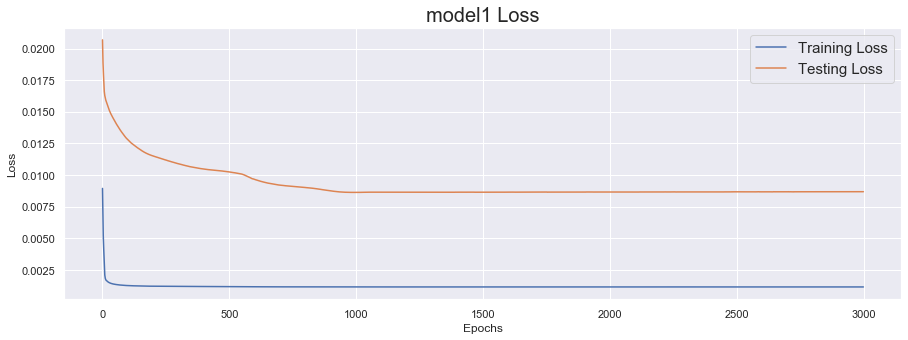

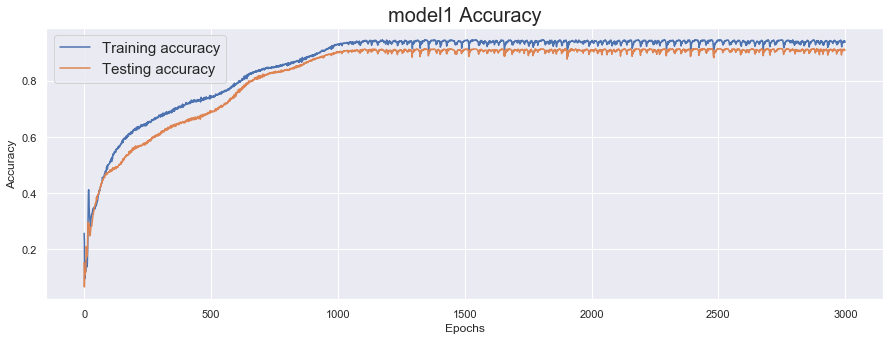

In [257]:
plot_results(history1,'model1')

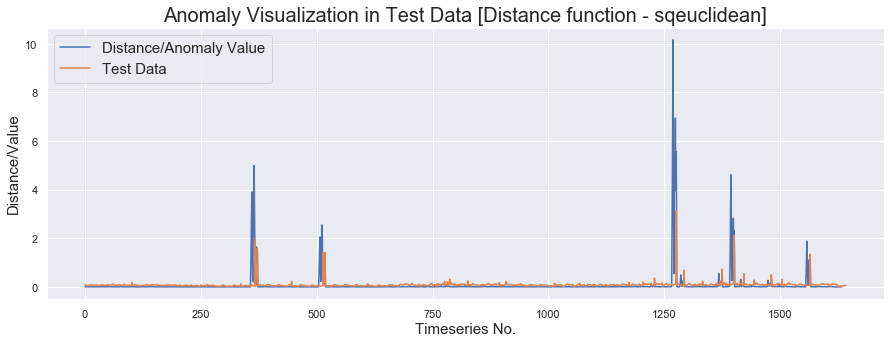

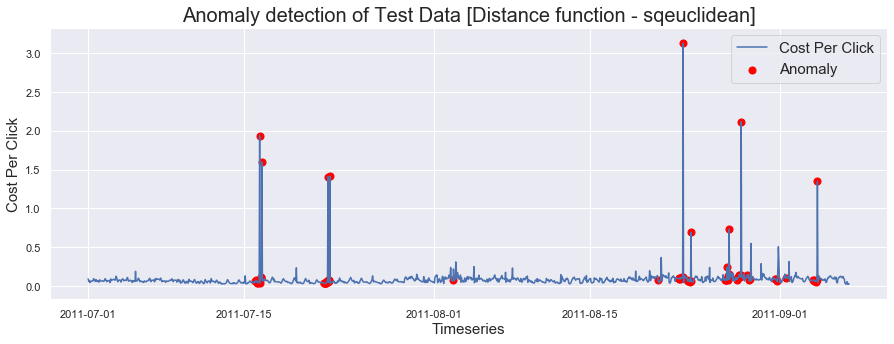

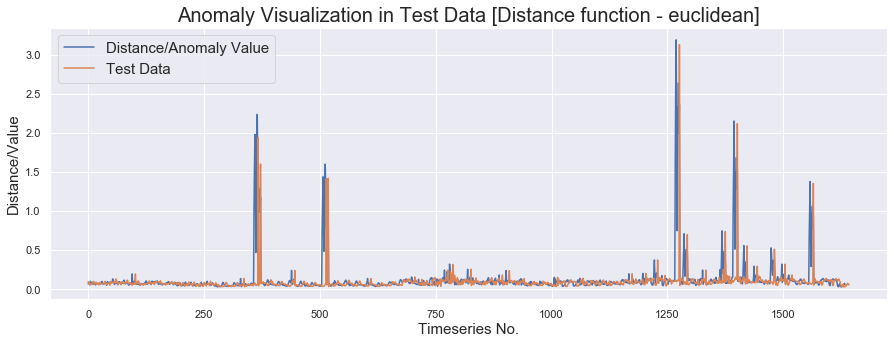

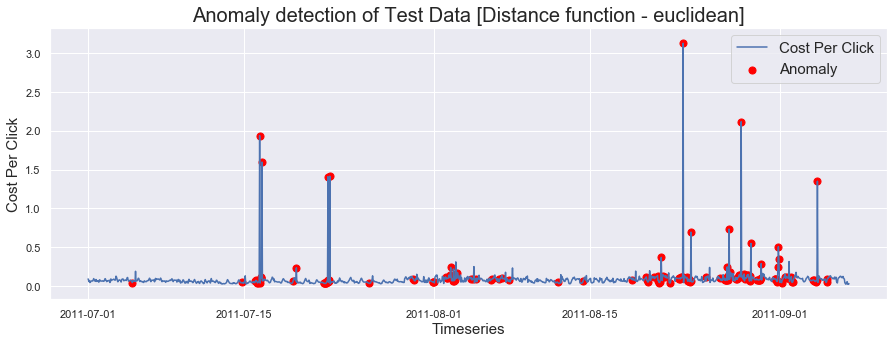

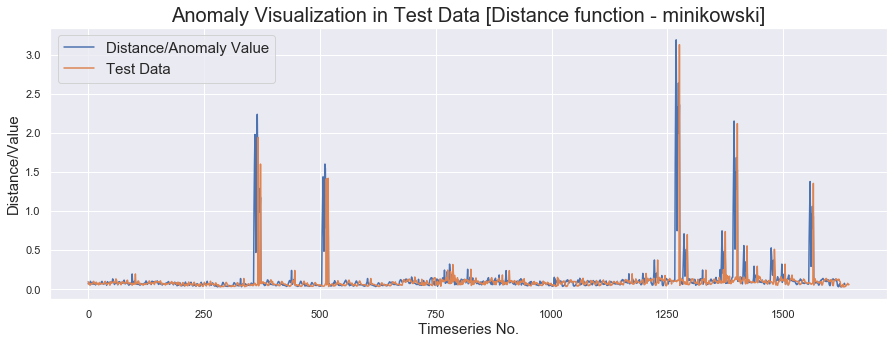

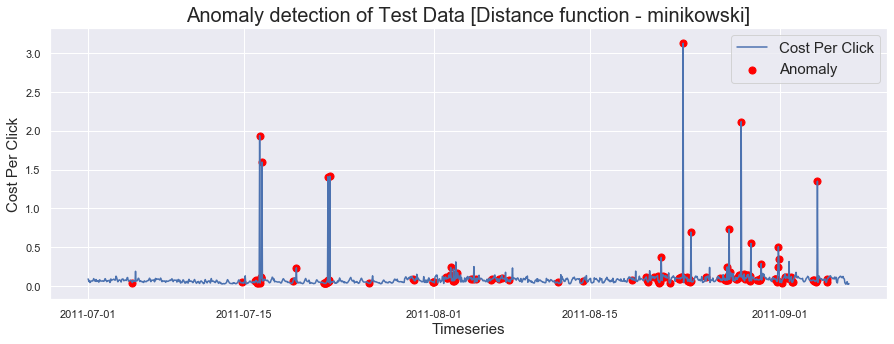

Generated Anomaly Labled Dataset sample
---------------------------------


value Anomaly
Time                                 
2011-07-01 00:15:01  0.091795       0
2011-07-01 01:15:01  0.074414       0
2011-07-01 02:15:01  0.056984       0
2011-07-01 03:15:01  0.071225       0
2011-07-01 04:15:01  0.045466       0
...                       ...     ...
2011-09-07 01:15:01  0.056815       0
2011-09-07 02:15:01  0.024925       0
2011-09-07 03:15:01  0.032984       0
2011-09-07 04:15:01  0.025836       0
2011-09-07 05:15:01  0.029218       0

[1634 rows x 2 columns]

In [243]:
a1 = detect_anomaly(X_test,model1,'sqeuclidean')
a2 = detect_anomaly(X_test,model1,'euclidean')
a3 = detect_anomaly(X_test,model1,'minikowski')
print('Generated Anomaly Labled Dataset sample')
print('---------------------------------')
a1

### Setup 2 [Window size - 20]

In [258]:
window = 20
print('Training Data Shape')
print('--------------------')
X_train = data_generator(window,df)
print('Testing Data Shape')
print('--------------------')
X_test = data_generator(window,df_test)

Training Data Shape
--------------------
X Shape (1605, 20)
Testing Data Shape
--------------------
X Shape (1624, 20)


In [113]:
# Model Building
model2 = Sequential()
model2.add(Dense(40, activation='relu', input_dim=X_train.shape[1]))
model2.add(Dense(40, activation='relu'))
model2.add(Dense(40, activation='relu'))
model2.add(Dense(X_train.shape[1], activation='relu'))
model2.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])
model2.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_66 (Dense)             (None, 40)                840       
_________________________________________________________________
dense_67 (Dense)             (None, 40)                1640      
_________________________________________________________________
dense_68 (Dense)             (None, 40)                1640      
_________________________________________________________________
dense_69 (Dense)             (None, 20)                820       
Total params: 4,940
Trainable params: 4,940
Non-trainable params: 0
_________________________________________________________________


In [114]:
history2 = model2.fit(X_train, X_train,
          validation_data=(X_test, X_test), 
          epochs=3000, 
          batch_size=500)

Train on 1605 samples, validate on 1624 samples
Epoch 1/3000
1605/1605 [==============================] - 0s 86us/step - loss: 0.0075 - accuracy: 0.0660 - val_loss: 0.0200 - val_accuracy: 0.0573
Epoch 2/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0059 - accuracy: 0.0760 - val_loss: 0.0195 - val_accuracy: 0.0690
Epoch 3/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0050 - accuracy: 0.0704 - val_loss: 0.0194 - val_accuracy: 0.0585
Epoch 4/3000
1605/1605 [==============================] - 0s 15us/step - loss: 0.0048 - accuracy: 0.0735 - val_loss: 0.0193 - val_accuracy: 0.0573
Epoch 5/3000
1605/1605 [==============================] - 0s 15us/step - loss: 0.0047 - accuracy: 0.0791 - val_loss: 0.0192 - val_accuracy: 0.0431
Epoch 6/3000
1605/1605 [==============================] - 0s 16us/step - loss: 0.0046 - accuracy: 0.0542 - val_loss: 0.0191 - val_accuracy: 0.0419
Epoch 7/3000
1605/1605 [==============================] - 0s 16us/step

Epoch 56/3000
1605/1605 [==============================] - 0s 15us/step - loss: 0.0030 - accuracy: 0.2592 - val_loss: 0.0169 - val_accuracy: 0.2272
Epoch 57/3000
1605/1605 [==============================] - 0s 15us/step - loss: 0.0030 - accuracy: 0.2735 - val_loss: 0.0169 - val_accuracy: 0.2451
Epoch 58/3000
1605/1605 [==============================] - 0s 15us/step - loss: 0.0030 - accuracy: 0.2798 - val_loss: 0.0168 - val_accuracy: 0.2500
Epoch 59/3000
1605/1605 [==============================] - 0s 15us/step - loss: 0.0030 - accuracy: 0.2835 - val_loss: 0.0168 - val_accuracy: 0.2525
Epoch 60/3000
1605/1605 [==============================] - 0s 16us/step - loss: 0.0030 - accuracy: 0.2866 - val_loss: 0.0168 - val_accuracy: 0.2574
Epoch 61/3000
1605/1605 [==============================] - 0s 15us/step - loss: 0.0030 - accuracy: 0.2922 - val_loss: 0.0167 - val_accuracy: 0.2617
Epoch 62/3000
1605/1605 [==============================] - 0s 15us/step - loss: 0.0030 - accuracy: 0.2916 - val_

1605/1605 [==============================] - 0s 15us/step - loss: 0.0029 - accuracy: 0.5003 - val_loss: 0.0149 - val_accuracy: 0.4889
Epoch 166/3000
1605/1605 [==============================] - 0s 15us/step - loss: 0.0029 - accuracy: 0.5084 - val_loss: 0.0149 - val_accuracy: 0.4809
Epoch 167/3000
1605/1605 [==============================] - 0s 16us/step - loss: 0.0029 - accuracy: 0.5016 - val_loss: 0.0149 - val_accuracy: 0.4865
Epoch 168/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0029 - accuracy: 0.5022 - val_loss: 0.0149 - val_accuracy: 0.4858
Epoch 169/3000
1605/1605 [==============================] - 0s 15us/step - loss: 0.0029 - accuracy: 0.5109 - val_loss: 0.0149 - val_accuracy: 0.4932
Epoch 170/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0029 - accuracy: 0.5040 - val_loss: 0.0148 - val_accuracy: 0.4871
Epoch 171/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0029 - accuracy: 0.5040 - val_loss: 0.

1605/1605 [==============================] - 0s 15us/step - loss: 0.0029 - accuracy: 0.5352 - val_loss: 0.0143 - val_accuracy: 0.5216
Epoch 221/3000
1605/1605 [==============================] - 0s 15us/step - loss: 0.0029 - accuracy: 0.5402 - val_loss: 0.0143 - val_accuracy: 0.5246
Epoch 222/3000
1605/1605 [==============================] - 0s 15us/step - loss: 0.0029 - accuracy: 0.5408 - val_loss: 0.0143 - val_accuracy: 0.5271
Epoch 223/3000
1605/1605 [==============================] - 0s 15us/step - loss: 0.0029 - accuracy: 0.5414 - val_loss: 0.0143 - val_accuracy: 0.5283
Epoch 224/3000
1605/1605 [==============================] - 0s 15us/step - loss: 0.0029 - accuracy: 0.5433 - val_loss: 0.0143 - val_accuracy: 0.5265
Epoch 225/3000
1605/1605 [==============================] - 0s 15us/step - loss: 0.0029 - accuracy: 0.5408 - val_loss: 0.0143 - val_accuracy: 0.5246
Epoch 226/3000
1605/1605 [==============================] - 0s 16us/step - loss: 0.0029 - accuracy: 0.5414 - val_loss: 0.

1605/1605 [==============================] - 0s 16us/step - loss: 0.0029 - accuracy: 0.5701 - val_loss: 0.0139 - val_accuracy: 0.5622
Epoch 276/3000
1605/1605 [==============================] - 0s 17us/step - loss: 0.0029 - accuracy: 0.5657 - val_loss: 0.0139 - val_accuracy: 0.5647
Epoch 277/3000
1605/1605 [==============================] - 0s 15us/step - loss: 0.0029 - accuracy: 0.5651 - val_loss: 0.0139 - val_accuracy: 0.5640
Epoch 278/3000
1605/1605 [==============================] - 0s 15us/step - loss: 0.0029 - accuracy: 0.5707 - val_loss: 0.0139 - val_accuracy: 0.5671
Epoch 279/3000
1605/1605 [==============================] - 0s 16us/step - loss: 0.0029 - accuracy: 0.5745 - val_loss: 0.0139 - val_accuracy: 0.5677
Epoch 280/3000
1605/1605 [==============================] - 0s 15us/step - loss: 0.0029 - accuracy: 0.5682 - val_loss: 0.0139 - val_accuracy: 0.5634
Epoch 281/3000
1605/1605 [==============================] - 0s 16us/step - loss: 0.0029 - accuracy: 0.5707 - val_loss: 0.

1605/1605 [==============================] - 0s 15us/step - loss: 0.0018 - accuracy: 0.5882 - val_loss: 0.0129 - val_accuracy: 0.5899
Epoch 331/3000
1605/1605 [==============================] - 0s 16us/step - loss: 0.0018 - accuracy: 0.5956 - val_loss: 0.0129 - val_accuracy: 0.5844
Epoch 332/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0018 - accuracy: 0.5907 - val_loss: 0.0129 - val_accuracy: 0.5905
Epoch 333/3000
1605/1605 [==============================] - 0s 15us/step - loss: 0.0018 - accuracy: 0.5963 - val_loss: 0.0129 - val_accuracy: 0.5954
Epoch 334/3000
1605/1605 [==============================] - 0s 15us/step - loss: 0.0018 - accuracy: 0.6006 - val_loss: 0.0129 - val_accuracy: 0.5911
Epoch 335/3000
1605/1605 [==============================] - 0s 15us/step - loss: 0.0018 - accuracy: 0.5975 - val_loss: 0.0129 - val_accuracy: 0.5924
Epoch 336/3000
1605/1605 [==============================] - 0s 15us/step - loss: 0.0018 - accuracy: 0.5994 - val_loss: 0.

1605/1605 [==============================] - 0s 16us/step - loss: 0.0017 - accuracy: 0.6474 - val_loss: 0.0124 - val_accuracy: 0.6435
Epoch 386/3000
1605/1605 [==============================] - 0s 17us/step - loss: 0.0017 - accuracy: 0.6455 - val_loss: 0.0124 - val_accuracy: 0.6441
Epoch 387/3000
1605/1605 [==============================] - 0s 15us/step - loss: 0.0017 - accuracy: 0.6480 - val_loss: 0.0124 - val_accuracy: 0.6459
Epoch 388/3000
1605/1605 [==============================] - 0s 16us/step - loss: 0.0017 - accuracy: 0.6505 - val_loss: 0.0124 - val_accuracy: 0.6404
Epoch 389/3000
1605/1605 [==============================] - 0s 15us/step - loss: 0.0017 - accuracy: 0.6474 - val_loss: 0.0124 - val_accuracy: 0.6422
Epoch 390/3000
1605/1605 [==============================] - 0s 15us/step - loss: 0.0017 - accuracy: 0.6517 - val_loss: 0.0124 - val_accuracy: 0.6478
Epoch 391/3000
1605/1605 [==============================] - 0s 15us/step - loss: 0.0017 - accuracy: 0.6474 - val_loss: 0.

1605/1605 [==============================] - 0s 16us/step - loss: 0.0017 - accuracy: 0.6710 - val_loss: 0.0121 - val_accuracy: 0.6736
Epoch 441/3000
1605/1605 [==============================] - 0s 15us/step - loss: 0.0017 - accuracy: 0.6729 - val_loss: 0.0121 - val_accuracy: 0.6780
Epoch 442/3000
1605/1605 [==============================] - 0s 16us/step - loss: 0.0017 - accuracy: 0.6773 - val_loss: 0.0121 - val_accuracy: 0.6780
Epoch 443/3000
1605/1605 [==============================] - 0s 17us/step - loss: 0.0017 - accuracy: 0.6717 - val_loss: 0.0121 - val_accuracy: 0.6743
Epoch 444/3000
1605/1605 [==============================] - 0s 16us/step - loss: 0.0017 - accuracy: 0.6723 - val_loss: 0.0121 - val_accuracy: 0.6736
Epoch 445/3000
1605/1605 [==============================] - 0s 15us/step - loss: 0.0017 - accuracy: 0.6748 - val_loss: 0.0121 - val_accuracy: 0.6786
Epoch 446/3000
1605/1605 [==============================] - 0s 15us/step - loss: 0.0017 - accuracy: 0.6729 - val_loss: 0.

1605/1605 [==============================] - 0s 14us/step - loss: 0.0017 - accuracy: 0.6941 - val_loss: 0.0119 - val_accuracy: 0.6952
Epoch 496/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0017 - accuracy: 0.6935 - val_loss: 0.0119 - val_accuracy: 0.7007
Epoch 497/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0017 - accuracy: 0.6941 - val_loss: 0.0119 - val_accuracy: 0.7001
Epoch 498/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.6910 - val_loss: 0.0119 - val_accuracy: 0.6946
Epoch 499/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.6903 - val_loss: 0.0119 - val_accuracy: 0.7014
Epoch 500/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.6953 - val_loss: 0.0119 - val_accuracy: 0.7001
Epoch 501/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.6984 - val_loss: 0.

Epoch 550/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0017 - accuracy: 0.7134 - val_loss: 0.0117 - val_accuracy: 0.7235
Epoch 551/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0017 - accuracy: 0.7165 - val_loss: 0.0117 - val_accuracy: 0.7223
Epoch 552/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0017 - accuracy: 0.7178 - val_loss: 0.0117 - val_accuracy: 0.7217
Epoch 553/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0017 - accuracy: 0.7171 - val_loss: 0.0116 - val_accuracy: 0.7278
Epoch 554/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0017 - accuracy: 0.7171 - val_loss: 0.0116 - val_accuracy: 0.7248
Epoch 555/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0017 - accuracy: 0.7178 - val_loss: 0.0116 - val_accuracy: 0.7291
Epoch 556/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0017 - accuracy: 0.7190

Epoch 605/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0017 - accuracy: 0.7383 - val_loss: 0.0115 - val_accuracy: 0.7445
Epoch 606/3000
1605/1605 [==============================] - 0s 15us/step - loss: 0.0017 - accuracy: 0.7346 - val_loss: 0.0114 - val_accuracy: 0.7451
Epoch 607/3000
1605/1605 [==============================] - 0s 15us/step - loss: 0.0017 - accuracy: 0.7346 - val_loss: 0.0114 - val_accuracy: 0.7457
Epoch 608/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0017 - accuracy: 0.7377 - val_loss: 0.0114 - val_accuracy: 0.7488
Epoch 609/3000
1605/1605 [==============================] - 0s 15us/step - loss: 0.0017 - accuracy: 0.7358 - val_loss: 0.0114 - val_accuracy: 0.7475
Epoch 610/3000
1605/1605 [==============================] - 0s 15us/step - loss: 0.0017 - accuracy: 0.7364 - val_loss: 0.0114 - val_accuracy: 0.7475
Epoch 611/3000
1605/1605 [==============================] - 0s 15us/step - loss: 0.0017 - accuracy: 0.7408

Epoch 660/3000
1605/1605 [==============================] - 0s 16us/step - loss: 0.0017 - accuracy: 0.7545 - val_loss: 0.0113 - val_accuracy: 0.7586
Epoch 661/3000
1605/1605 [==============================] - 0s 17us/step - loss: 0.0017 - accuracy: 0.7576 - val_loss: 0.0113 - val_accuracy: 0.7605
Epoch 662/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0017 - accuracy: 0.7564 - val_loss: 0.0113 - val_accuracy: 0.7562
Epoch 663/3000
1605/1605 [==============================] - 0s 16us/step - loss: 0.0017 - accuracy: 0.7570 - val_loss: 0.0113 - val_accuracy: 0.7605
Epoch 664/3000
1605/1605 [==============================] - 0s 17us/step - loss: 0.0017 - accuracy: 0.7570 - val_loss: 0.0113 - val_accuracy: 0.7592
Epoch 665/3000
1605/1605 [==============================] - 0s 16us/step - loss: 0.0017 - accuracy: 0.7601 - val_loss: 0.0112 - val_accuracy: 0.7623
Epoch 666/3000
1605/1605 [==============================] - 0s 16us/step - loss: 0.0017 - accuracy: 0.7576

Epoch 715/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.7751 - val_loss: 0.0111 - val_accuracy: 0.7716
Epoch 716/3000
1605/1605 [==============================] - 0s 12us/step - loss: 0.0017 - accuracy: 0.7757 - val_loss: 0.0111 - val_accuracy: 0.7728
Epoch 717/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.7738 - val_loss: 0.0111 - val_accuracy: 0.7752
Epoch 718/3000
1605/1605 [==============================] - 0s 12us/step - loss: 0.0017 - accuracy: 0.7738 - val_loss: 0.0111 - val_accuracy: 0.7740
Epoch 719/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.7782 - val_loss: 0.0111 - val_accuracy: 0.7746
Epoch 720/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.7757 - val_loss: 0.0111 - val_accuracy: 0.7752
Epoch 721/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.7757

Epoch 770/3000
1605/1605 [==============================] - 0s 12us/step - loss: 0.0017 - accuracy: 0.7850 - val_loss: 0.0110 - val_accuracy: 0.7808
Epoch 771/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.7875 - val_loss: 0.0110 - val_accuracy: 0.7808
Epoch 772/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.7882 - val_loss: 0.0110 - val_accuracy: 0.7869
Epoch 773/3000
1605/1605 [==============================] - 0s 12us/step - loss: 0.0017 - accuracy: 0.7844 - val_loss: 0.0110 - val_accuracy: 0.7851
Epoch 774/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.7801 - val_loss: 0.0109 - val_accuracy: 0.7857
Epoch 775/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.7826 - val_loss: 0.0110 - val_accuracy: 0.7876
Epoch 776/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0017 - accuracy: 0.7894

Epoch 825/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.7963 - val_loss: 0.0108 - val_accuracy: 0.7980
Epoch 826/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0017 - accuracy: 0.7944 - val_loss: 0.0108 - val_accuracy: 0.7986
Epoch 827/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0017 - accuracy: 0.7981 - val_loss: 0.0108 - val_accuracy: 0.7925
Epoch 828/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.7981 - val_loss: 0.0108 - val_accuracy: 0.7937
Epoch 829/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.7981 - val_loss: 0.0108 - val_accuracy: 0.7950
Epoch 830/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0017 - accuracy: 0.7963 - val_loss: 0.0108 - val_accuracy: 0.7943
Epoch 831/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.7988

Epoch 880/3000
1605/1605 [==============================] - 0s 12us/step - loss: 0.0017 - accuracy: 0.8106 - val_loss: 0.0107 - val_accuracy: 0.8048
Epoch 881/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8106 - val_loss: 0.0107 - val_accuracy: 0.8023
Epoch 882/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8112 - val_loss: 0.0107 - val_accuracy: 0.8023
Epoch 883/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8168 - val_loss: 0.0107 - val_accuracy: 0.8048
Epoch 884/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8143 - val_loss: 0.0107 - val_accuracy: 0.8054
Epoch 885/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8125 - val_loss: 0.0107 - val_accuracy: 0.8073
Epoch 886/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8137

Epoch 935/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8193 - val_loss: 0.0107 - val_accuracy: 0.8110
Epoch 936/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8162 - val_loss: 0.0107 - val_accuracy: 0.8110
Epoch 937/3000
1605/1605 [==============================] - 0s 12us/step - loss: 0.0017 - accuracy: 0.8206 - val_loss: 0.0107 - val_accuracy: 0.8110
Epoch 938/3000
1605/1605 [==============================] - 0s 15us/step - loss: 0.0017 - accuracy: 0.8224 - val_loss: 0.0107 - val_accuracy: 0.8128
Epoch 939/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8218 - val_loss: 0.0107 - val_accuracy: 0.8128
Epoch 940/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8168 - val_loss: 0.0107 - val_accuracy: 0.8116
Epoch 941/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8224

Epoch 990/3000
1605/1605 [==============================] - 0s 12us/step - loss: 0.0017 - accuracy: 0.8218 - val_loss: 0.0106 - val_accuracy: 0.7999
Epoch 991/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8093 - val_loss: 0.0106 - val_accuracy: 0.8140
Epoch 992/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0017 - accuracy: 0.8181 - val_loss: 0.0106 - val_accuracy: 0.8140
Epoch 993/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0017 - accuracy: 0.8249 - val_loss: 0.0106 - val_accuracy: 0.8110
Epoch 994/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0017 - accuracy: 0.8262 - val_loss: 0.0106 - val_accuracy: 0.8140
Epoch 995/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0017 - accuracy: 0.8237 - val_loss: 0.0106 - val_accuracy: 0.8165
Epoch 996/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8280

Epoch 1045/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8312 - val_loss: 0.0106 - val_accuracy: 0.8202
Epoch 1046/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8293 - val_loss: 0.0106 - val_accuracy: 0.8196
Epoch 1047/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8255 - val_loss: 0.0106 - val_accuracy: 0.8183
Epoch 1048/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8268 - val_loss: 0.0106 - val_accuracy: 0.8196
Epoch 1049/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8293 - val_loss: 0.0106 - val_accuracy: 0.8183
Epoch 1050/3000
1605/1605 [==============================] - 0s 12us/step - loss: 0.0017 - accuracy: 0.8287 - val_loss: 0.0106 - val_accuracy: 0.8183
Epoch 1051/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy:

Epoch 1154/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8361 - val_loss: 0.0106 - val_accuracy: 0.8196
Epoch 1155/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8355 - val_loss: 0.0106 - val_accuracy: 0.8208
Epoch 1156/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8355 - val_loss: 0.0106 - val_accuracy: 0.8202
Epoch 1157/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8361 - val_loss: 0.0106 - val_accuracy: 0.8208
Epoch 1158/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8361 - val_loss: 0.0106 - val_accuracy: 0.8202
Epoch 1159/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8361 - val_loss: 0.0106 - val_accuracy: 0.8202
Epoch 1160/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy:

1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8361 - val_loss: 0.0106 - val_accuracy: 0.8208
Epoch 1209/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0017 - accuracy: 0.8355 - val_loss: 0.0106 - val_accuracy: 0.8196
Epoch 1210/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8343 - val_loss: 0.0106 - val_accuracy: 0.8202
Epoch 1211/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0017 - accuracy: 0.8355 - val_loss: 0.0106 - val_accuracy: 0.8196
Epoch 1212/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8343 - val_loss: 0.0106 - val_accuracy: 0.8202
Epoch 1213/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8355 - val_loss: 0.0106 - val_accuracy: 0.8202
Epoch 1214/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8349 - val_lo

Epoch 1263/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8199 - val_loss: 0.0106 - val_accuracy: 0.8110
Epoch 1264/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8181 - val_loss: 0.0106 - val_accuracy: 0.8165
Epoch 1265/3000
1605/1605 [==============================] - 0s 12us/step - loss: 0.0017 - accuracy: 0.8249 - val_loss: 0.0106 - val_accuracy: 0.8177
Epoch 1266/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8287 - val_loss: 0.0106 - val_accuracy: 0.8159
Epoch 1267/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0017 - accuracy: 0.8243 - val_loss: 0.0106 - val_accuracy: 0.8208
Epoch 1268/3000
1605/1605 [==============================] - 0s 12us/step - loss: 0.0017 - accuracy: 0.8324 - val_loss: 0.0106 - val_accuracy: 0.8190
Epoch 1269/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0017 - accuracy:

Epoch 1372/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8318 - val_loss: 0.0106 - val_accuracy: 0.8196
Epoch 1373/3000
1605/1605 [==============================] - 0s 12us/step - loss: 0.0017 - accuracy: 0.8293 - val_loss: 0.0106 - val_accuracy: 0.8202
Epoch 1374/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8324 - val_loss: 0.0106 - val_accuracy: 0.8165
Epoch 1375/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8312 - val_loss: 0.0106 - val_accuracy: 0.8171
Epoch 1376/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8318 - val_loss: 0.0106 - val_accuracy: 0.8196
Epoch 1377/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8318 - val_loss: 0.0106 - val_accuracy: 0.8208
Epoch 1378/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy:

1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8330 - val_loss: 0.0106 - val_accuracy: 0.8171
Epoch 1481/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8305 - val_loss: 0.0106 - val_accuracy: 0.8159
Epoch 1482/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8249 - val_loss: 0.0106 - val_accuracy: 0.8122
Epoch 1483/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8212 - val_loss: 0.0106 - val_accuracy: 0.8116
Epoch 1484/3000
1605/1605 [==============================] - 0s 12us/step - loss: 0.0017 - accuracy: 0.8243 - val_loss: 0.0106 - val_accuracy: 0.8122
Epoch 1485/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8206 - val_loss: 0.0106 - val_accuracy: 0.8153
Epoch 1486/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0017 - accuracy: 0.8274 - val_lo

Epoch 1535/3000
1605/1605 [==============================] - 0s 12us/step - loss: 0.0017 - accuracy: 0.8262 - val_loss: 0.0106 - val_accuracy: 0.8128
Epoch 1536/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8181 - val_loss: 0.0106 - val_accuracy: 0.8067
Epoch 1537/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8050 - val_loss: 0.0106 - val_accuracy: 0.8116
Epoch 1538/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0017 - accuracy: 0.8125 - val_loss: 0.0106 - val_accuracy: 0.8048
Epoch 1539/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8081 - val_loss: 0.0106 - val_accuracy: 0.8122
Epoch 1540/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8249 - val_loss: 0.0106 - val_accuracy: 0.8073
Epoch 1541/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy:

1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8349 - val_loss: 0.0106 - val_accuracy: 0.8190
Epoch 1644/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8268 - val_loss: 0.0106 - val_accuracy: 0.8147
Epoch 1645/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8218 - val_loss: 0.0106 - val_accuracy: 0.8054
Epoch 1646/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8100 - val_loss: 0.0106 - val_accuracy: 0.8023
Epoch 1647/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8174 - val_loss: 0.0106 - val_accuracy: 0.8140
Epoch 1648/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8206 - val_loss: 0.0107 - val_accuracy: 0.8128
Epoch 1649/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8249 - val_lo

1605/1605 [==============================] - 0s 12us/step - loss: 0.0017 - accuracy: 0.8318 - val_loss: 0.0106 - val_accuracy: 0.8183
Epoch 1752/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8293 - val_loss: 0.0106 - val_accuracy: 0.8177
Epoch 1753/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0017 - accuracy: 0.8231 - val_loss: 0.0106 - val_accuracy: 0.8091
Epoch 1754/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0017 - accuracy: 0.8162 - val_loss: 0.0106 - val_accuracy: 0.8017
Epoch 1755/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8106 - val_loss: 0.0106 - val_accuracy: 0.8116
Epoch 1756/3000
1605/1605 [==============================] - 0s 12us/step - loss: 0.0017 - accuracy: 0.8262 - val_loss: 0.0107 - val_accuracy: 0.8085
Epoch 1757/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8168 - val_lo

Epoch 1806/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8324 - val_loss: 0.0107 - val_accuracy: 0.8196
Epoch 1807/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0017 - accuracy: 0.8305 - val_loss: 0.0107 - val_accuracy: 0.8183
Epoch 1808/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8237 - val_loss: 0.0106 - val_accuracy: 0.8134
Epoch 1809/3000
1605/1605 [==============================] - 0s 12us/step - loss: 0.0017 - accuracy: 0.8112 - val_loss: 0.0107 - val_accuracy: 0.8048
Epoch 1810/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8125 - val_loss: 0.0107 - val_accuracy: 0.8177
Epoch 1811/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8255 - val_loss: 0.0107 - val_accuracy: 0.8128
Epoch 1812/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy:

1605/1605 [==============================] - 0s 14us/step - loss: 0.0017 - accuracy: 0.8162 - val_loss: 0.0107 - val_accuracy: 0.8128
Epoch 1861/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0017 - accuracy: 0.8187 - val_loss: 0.0107 - val_accuracy: 0.8196
Epoch 1862/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0017 - accuracy: 0.8305 - val_loss: 0.0107 - val_accuracy: 0.8128
Epoch 1863/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8218 - val_loss: 0.0107 - val_accuracy: 0.8171
Epoch 1864/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8274 - val_loss: 0.0107 - val_accuracy: 0.8190
Epoch 1865/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0017 - accuracy: 0.8312 - val_loss: 0.0107 - val_accuracy: 0.8183
Epoch 1866/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0017 - accuracy: 0.8274 - val_lo

1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8206 - val_loss: 0.0107 - val_accuracy: 0.8165
Epoch 1969/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8224 - val_loss: 0.0107 - val_accuracy: 0.8190
Epoch 1970/3000
1605/1605 [==============================] - 0s 12us/step - loss: 0.0017 - accuracy: 0.8274 - val_loss: 0.0107 - val_accuracy: 0.8171
Epoch 1971/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0017 - accuracy: 0.8237 - val_loss: 0.0107 - val_accuracy: 0.8134
Epoch 1972/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8206 - val_loss: 0.0107 - val_accuracy: 0.8147
Epoch 1973/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0017 - accuracy: 0.8174 - val_loss: 0.0107 - val_accuracy: 0.8171
Epoch 1974/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8237 - val_lo

1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8368 - val_loss: 0.0107 - val_accuracy: 0.8208
Epoch 2077/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8349 - val_loss: 0.0107 - val_accuracy: 0.8208
Epoch 2078/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8324 - val_loss: 0.0107 - val_accuracy: 0.8208
Epoch 2079/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8324 - val_loss: 0.0107 - val_accuracy: 0.8208
Epoch 2080/3000
1605/1605 [==============================] - 0s 12us/step - loss: 0.0017 - accuracy: 0.8349 - val_loss: 0.0107 - val_accuracy: 0.8208
Epoch 2081/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0017 - accuracy: 0.8349 - val_loss: 0.0107 - val_accuracy: 0.8214
Epoch 2082/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0017 - accuracy: 0.8349 - val_lo

Epoch 2131/3000
1605/1605 [==============================] - ETA: 0s - loss: 0.0018 - accuracy: 0.81 - 0s 14us/step - loss: 0.0017 - accuracy: 0.8287 - val_loss: 0.0107 - val_accuracy: 0.8183
Epoch 2132/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0017 - accuracy: 0.8299 - val_loss: 0.0107 - val_accuracy: 0.8202
Epoch 2133/3000
1605/1605 [==============================] - 0s 15us/step - loss: 0.0017 - accuracy: 0.8318 - val_loss: 0.0107 - val_accuracy: 0.8196
Epoch 2134/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8330 - val_loss: 0.0107 - val_accuracy: 0.8196
Epoch 2135/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8305 - val_loss: 0.0107 - val_accuracy: 0.8183
Epoch 2136/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8293 - val_loss: 0.0107 - val_accuracy: 0.8190
Epoch 2137/3000
1605/1605 [==============================]

Epoch 2185/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8330 - val_loss: 0.0107 - val_accuracy: 0.8208
Epoch 2186/3000
1605/1605 [==============================] - 0s 12us/step - loss: 0.0017 - accuracy: 0.8324 - val_loss: 0.0107 - val_accuracy: 0.8202
Epoch 2187/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8330 - val_loss: 0.0107 - val_accuracy: 0.8159
Epoch 2188/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8287 - val_loss: 0.0107 - val_accuracy: 0.8103
Epoch 2189/3000
1605/1605 [==============================] - 0s 12us/step - loss: 0.0017 - accuracy: 0.8131 - val_loss: 0.0107 - val_accuracy: 0.8042
Epoch 2190/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8162 - val_loss: 0.0107 - val_accuracy: 0.8103
Epoch 2191/3000
1605/1605 [==============================] - 0s 15us/step - loss: 0.0017 - accuracy:

1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8262 - val_loss: 0.0107 - val_accuracy: 0.8196
Epoch 2240/3000
1605/1605 [==============================] - 0s 12us/step - loss: 0.0017 - accuracy: 0.8280 - val_loss: 0.0107 - val_accuracy: 0.8177
Epoch 2241/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8268 - val_loss: 0.0107 - val_accuracy: 0.8208
Epoch 2242/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8349 - val_loss: 0.0107 - val_accuracy: 0.8208
Epoch 2243/3000
1605/1605 [==============================] - 0s 12us/step - loss: 0.0017 - accuracy: 0.8343 - val_loss: 0.0107 - val_accuracy: 0.8202
Epoch 2244/3000
1605/1605 [==============================] - 0s 12us/step - loss: 0.0017 - accuracy: 0.8336 - val_loss: 0.0107 - val_accuracy: 0.8183
Epoch 2245/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8343 - val_lo

Epoch 2294/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0017 - accuracy: 0.8212 - val_loss: 0.0107 - val_accuracy: 0.8140
Epoch 2295/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0017 - accuracy: 0.8212 - val_loss: 0.0107 - val_accuracy: 0.8159
Epoch 2296/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8293 - val_loss: 0.0107 - val_accuracy: 0.8165
Epoch 2297/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8268 - val_loss: 0.0107 - val_accuracy: 0.8190
Epoch 2298/3000
1605/1605 [==============================] - 0s 12us/step - loss: 0.0017 - accuracy: 0.8274 - val_loss: 0.0107 - val_accuracy: 0.8196
Epoch 2299/3000
1605/1605 [==============================] - 0s 12us/step - loss: 0.0017 - accuracy: 0.8287 - val_loss: 0.0107 - val_accuracy: 0.8190
Epoch 2300/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy:

Epoch 2403/3000
1605/1605 [==============================] - 0s 19us/step - loss: 0.0017 - accuracy: 0.8218 - val_loss: 0.0107 - val_accuracy: 0.8183
Epoch 2404/3000
1605/1605 [==============================] - 0s 17us/step - loss: 0.0017 - accuracy: 0.8274 - val_loss: 0.0107 - val_accuracy: 0.8171
Epoch 2405/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0017 - accuracy: 0.8274 - val_loss: 0.0107 - val_accuracy: 0.8183
Epoch 2406/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8293 - val_loss: 0.0107 - val_accuracy: 0.8183
Epoch 2407/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8299 - val_loss: 0.0107 - val_accuracy: 0.8196
Epoch 2408/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8287 - val_loss: 0.0107 - val_accuracy: 0.8196
Epoch 2409/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy:

Epoch 2512/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8262 - val_loss: 0.0107 - val_accuracy: 0.8190
Epoch 2513/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8262 - val_loss: 0.0107 - val_accuracy: 0.8190
Epoch 2514/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8255 - val_loss: 0.0107 - val_accuracy: 0.8196
Epoch 2515/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8255 - val_loss: 0.0107 - val_accuracy: 0.8190
Epoch 2516/3000
1605/1605 [==============================] - 0s 15us/step - loss: 0.0017 - accuracy: 0.8268 - val_loss: 0.0107 - val_accuracy: 0.8196
Epoch 2517/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0017 - accuracy: 0.8324 - val_loss: 0.0107 - val_accuracy: 0.8208
Epoch 2518/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0017 - accuracy:

Epoch 2566/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8268 - val_loss: 0.0107 - val_accuracy: 0.8202
Epoch 2567/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8330 - val_loss: 0.0107 - val_accuracy: 0.8177
Epoch 2568/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8305 - val_loss: 0.0107 - val_accuracy: 0.8153
Epoch 2569/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8280 - val_loss: 0.0107 - val_accuracy: 0.8190
Epoch 2570/3000
1605/1605 [==============================] - 0s 12us/step - loss: 0.0017 - accuracy: 0.8336 - val_loss: 0.0107 - val_accuracy: 0.8196
Epoch 2571/3000
1605/1605 [==============================] - 0s 12us/step - loss: 0.0017 - accuracy: 0.8305 - val_loss: 0.0107 - val_accuracy: 0.8196
Epoch 2572/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0017 - accuracy:

Epoch 2675/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8349 - val_loss: 0.0107 - val_accuracy: 0.8208
Epoch 2676/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8336 - val_loss: 0.0107 - val_accuracy: 0.8202
Epoch 2677/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8299 - val_loss: 0.0107 - val_accuracy: 0.8208
Epoch 2678/3000
1605/1605 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 0.83 - 0s 12us/step - loss: 0.0017 - accuracy: 0.8237 - val_loss: 0.0107 - val_accuracy: 0.8190
Epoch 2679/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8268 - val_loss: 0.0107 - val_accuracy: 0.8153
Epoch 2680/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8181 - val_loss: 0.0107 - val_accuracy: 0.8048
Epoch 2681/3000
1605/1605 [==============================]

Epoch 2729/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8336 - val_loss: 0.0107 - val_accuracy: 0.8214
Epoch 2730/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0017 - accuracy: 0.8312 - val_loss: 0.0107 - val_accuracy: 0.8214
Epoch 2731/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8324 - val_loss: 0.0107 - val_accuracy: 0.8208
Epoch 2732/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8330 - val_loss: 0.0107 - val_accuracy: 0.8208
Epoch 2733/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0017 - accuracy: 0.8361 - val_loss: 0.0107 - val_accuracy: 0.8202
Epoch 2734/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0017 - accuracy: 0.8330 - val_loss: 0.0107 - val_accuracy: 0.8208
Epoch 2735/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0017 - accuracy:

1605/1605 [==============================] - 0s 14us/step - loss: 0.0017 - accuracy: 0.8343 - val_loss: 0.0107 - val_accuracy: 0.8214
Epoch 2784/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0017 - accuracy: 0.8330 - val_loss: 0.0107 - val_accuracy: 0.8202
Epoch 2785/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8318 - val_loss: 0.0107 - val_accuracy: 0.8183
Epoch 2786/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8318 - val_loss: 0.0107 - val_accuracy: 0.8171
Epoch 2787/3000
1605/1605 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 0.80 - 0s 14us/step - loss: 0.0017 - accuracy: 0.8280 - val_loss: 0.0107 - val_accuracy: 0.8140
Epoch 2788/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0017 - accuracy: 0.8212 - val_loss: 0.0107 - val_accuracy: 0.8085
Epoch 2789/3000
1605/1605 [==============================] - 0s 13us/step 

Epoch 2892/3000
1605/1605 [==============================] - 0s 12us/step - loss: 0.0017 - accuracy: 0.8287 - val_loss: 0.0107 - val_accuracy: 0.8196
Epoch 2893/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8318 - val_loss: 0.0107 - val_accuracy: 0.8196
Epoch 2894/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8299 - val_loss: 0.0107 - val_accuracy: 0.8202
Epoch 2895/3000
1605/1605 [==============================] - 0s 14us/step - loss: 0.0017 - accuracy: 0.8318 - val_loss: 0.0107 - val_accuracy: 0.8183
Epoch 2896/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8249 - val_loss: 0.0107 - val_accuracy: 0.8147
Epoch 2897/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8181 - val_loss: 0.0107 - val_accuracy: 0.8097
Epoch 2898/3000
1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy:

1605/1605 [==============================] - 0s 13us/step - loss: 0.0017 - accuracy: 0.8199 - val_loss: 0.0107 - val_accuracy: 0.8085


Prediction/Reconstruction Accuracy - 0.8084975481033325
Prediction/Reconstruction Loss - 0.010733630237504474


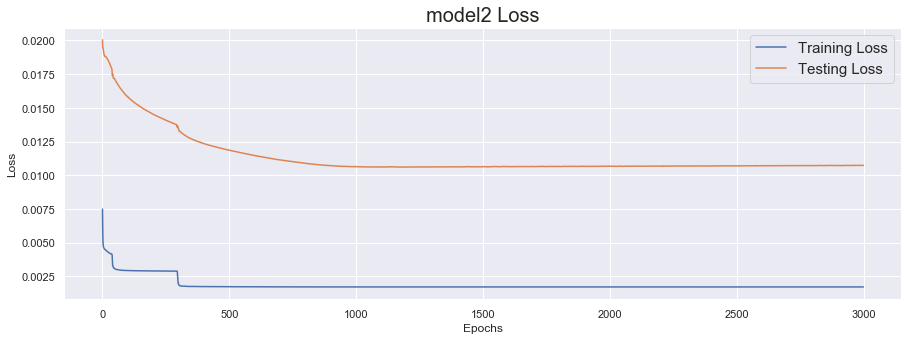

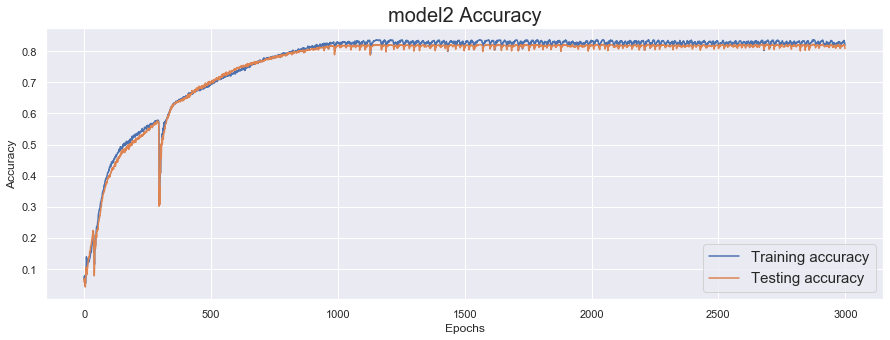

In [259]:
plot_results(history2,'model2')

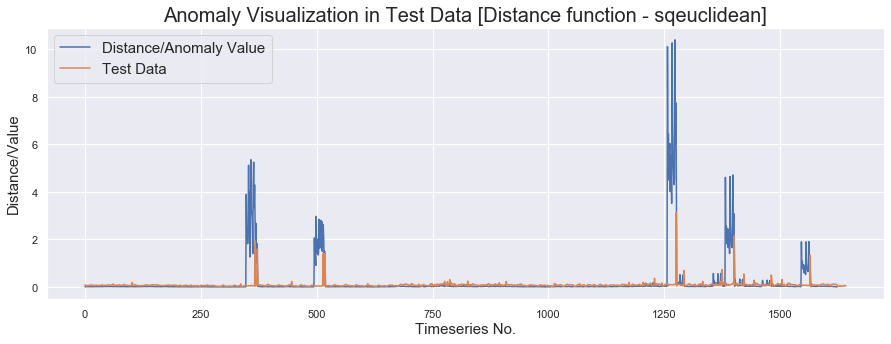

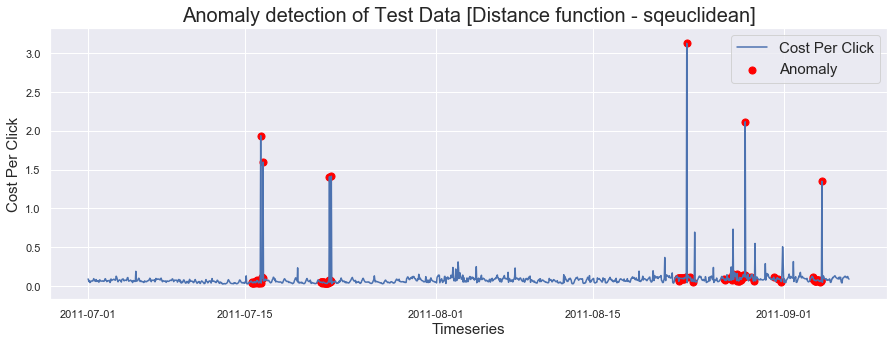

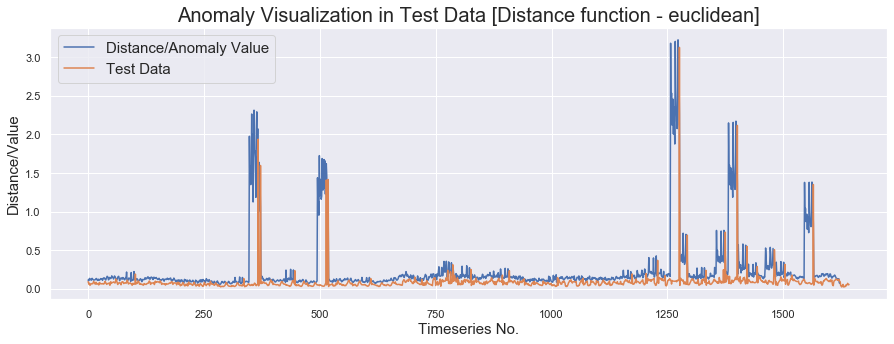

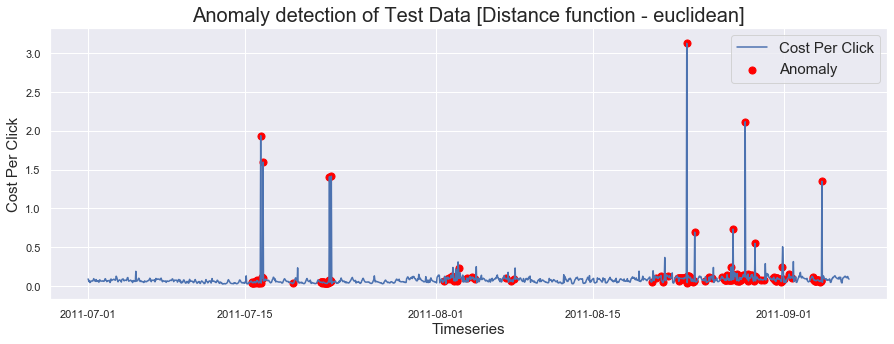

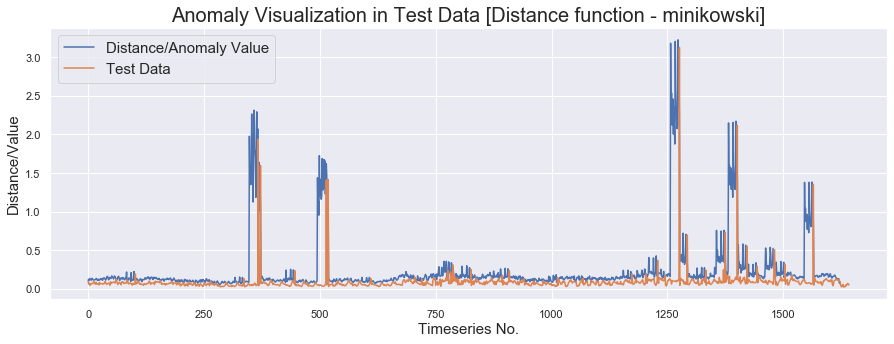

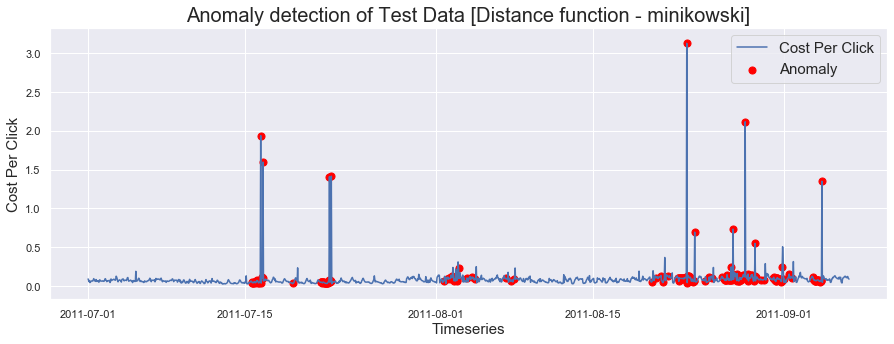

Generated Anomaly Labled Dataset Sample
---------------------------------


value Anomaly
Time                                 
2011-07-01 00:15:01  0.091795       0
2011-07-01 01:15:01  0.074414       0
2011-07-01 02:15:01  0.056984       0
2011-07-01 03:15:01  0.071225       0
2011-07-01 04:15:01  0.045466       0
...                       ...     ...
2011-09-06 15:15:01  0.108174       0
2011-09-06 16:15:01  0.123920       0
2011-09-06 17:15:01  0.106817       0
2011-09-06 18:15:01  0.095533       0
2011-09-06 19:15:01  0.090364       0

[1624 rows x 2 columns]

In [246]:
a1 = detect_anomaly(X_test,model2,'sqeuclidean')
a2 = detect_anomaly(X_test,model2,'euclidean')
a3 = detect_anomaly(X_test,model2,'minikowski')
print('Generated Anomaly Labled Dataset Sample')
print('---------------------------------')
a3

### Setup 3 [Window size - 50]

In [260]:
window = 50
print('Training Data Shape')
print('--------------------')
X_train = data_generator(window,df)
print('Testing Data Shape')
print('--------------------')
X_test = data_generator(window,df_test)

Training Data Shape
--------------------
X Shape (1575, 50)
Testing Data Shape
--------------------
X Shape (1594, 50)


In [103]:
# Model Building
model3 = Sequential()
model3.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
model3.add(Dense(100, activation='relu'))
model3.add(Dense(100, activation='relu'))
model3.add(Dense(X_train.shape[1], activation='relu')) 

model3.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])
model3.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_58 (Dense)             (None, 100)               5100      
_________________________________________________________________
dense_59 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_60 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_61 (Dense)             (None, 50)                5050      
Total params: 30,350
Trainable params: 30,350
Non-trainable params: 0
_________________________________________________________________


In [104]:
history3= model3.fit(X_train, X_train,
          validation_data=(X_test, X_test), 
          epochs=3000, 
          batch_size=500)

Train on 1575 samples, validate on 1594 samples
Epoch 1/3000
1575/1575 [==============================] - 0s 96us/step - loss: 0.0074 - accuracy: 0.0184 - val_loss: 0.0213 - val_accuracy: 0.0194
Epoch 2/3000
1575/1575 [==============================] - 0s 16us/step - loss: 0.0058 - accuracy: 0.0210 - val_loss: 0.0213 - val_accuracy: 0.0188
Epoch 3/3000
1575/1575 [==============================] - 0s 16us/step - loss: 0.0052 - accuracy: 0.0121 - val_loss: 0.0203 - val_accuracy: 0.0251
Epoch 4/3000
1575/1575 [==============================] - 0s 16us/step - loss: 0.0048 - accuracy: 0.0133 - val_loss: 0.0200 - val_accuracy: 0.0188
Epoch 5/3000
1575/1575 [==============================] - 0s 16us/step - loss: 0.0045 - accuracy: 0.0044 - val_loss: 0.0200 - val_accuracy: 0.0232
Epoch 6/3000
1575/1575 [==============================] - 0s 17us/step - loss: 0.0043 - accuracy: 0.0229 - val_loss: 0.0198 - val_accuracy: 0.0251
Epoch 7/3000
1575/1575 [==============================] - 0s 16us/step

1575/1575 [==============================] - 0s 15us/step - loss: 4.7087e-04 - accuracy: 0.1232 - val_loss: 0.0159 - val_accuracy: 0.1738
Epoch 56/3000
1575/1575 [==============================] - 0s 16us/step - loss: 4.6332e-04 - accuracy: 0.1314 - val_loss: 0.0159 - val_accuracy: 0.1694
Epoch 57/3000
1575/1575 [==============================] - 0s 16us/step - loss: 4.5489e-04 - accuracy: 0.1378 - val_loss: 0.0159 - val_accuracy: 0.1612
Epoch 58/3000
1575/1575 [==============================] - 0s 15us/step - loss: 4.4883e-04 - accuracy: 0.1359 - val_loss: 0.0159 - val_accuracy: 0.1650
Epoch 59/3000
1575/1575 [==============================] - 0s 15us/step - loss: 4.4476e-04 - accuracy: 0.1371 - val_loss: 0.0158 - val_accuracy: 0.1757
Epoch 60/3000
1575/1575 [==============================] - 0s 16us/step - loss: 4.4041e-04 - accuracy: 0.1371 - val_loss: 0.0158 - val_accuracy: 0.1782
Epoch 61/3000
1575/1575 [==============================] - 0s 16us/step - loss: 4.3680e-04 - accuracy:

1575/1575 [==============================] - 0s 16us/step - loss: 3.2941e-04 - accuracy: 0.3613 - val_loss: 0.0138 - val_accuracy: 0.4987
Epoch 162/3000
1575/1575 [==============================] - 0s 16us/step - loss: 3.2863e-04 - accuracy: 0.3759 - val_loss: 0.0138 - val_accuracy: 0.4893
Epoch 163/3000
1575/1575 [==============================] - 0s 15us/step - loss: 3.2822e-04 - accuracy: 0.3708 - val_loss: 0.0137 - val_accuracy: 0.4906
Epoch 164/3000
1575/1575 [==============================] - 0s 15us/step - loss: 3.2753e-04 - accuracy: 0.3771 - val_loss: 0.0137 - val_accuracy: 0.4975
Epoch 165/3000
1575/1575 [==============================] - 0s 15us/step - loss: 3.2717e-04 - accuracy: 0.3784 - val_loss: 0.0137 - val_accuracy: 0.5075
Epoch 166/3000
1575/1575 [==============================] - 0s 15us/step - loss: 3.2678e-04 - accuracy: 0.3765 - val_loss: 0.0137 - val_accuracy: 0.4987
Epoch 167/3000
1575/1575 [==============================] - 0s 16us/step - loss: 3.2610e-04 - acc

1575/1575 [==============================] - 0s 16us/step - loss: 2.8767e-04 - accuracy: 0.5467 - val_loss: 0.0124 - val_accuracy: 0.6681
Epoch 268/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.8747e-04 - accuracy: 0.5435 - val_loss: 0.0124 - val_accuracy: 0.6725
Epoch 269/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.8748e-04 - accuracy: 0.5537 - val_loss: 0.0124 - val_accuracy: 0.6675
Epoch 270/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.8710e-04 - accuracy: 0.5460 - val_loss: 0.0124 - val_accuracy: 0.6757
Epoch 271/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.8671e-04 - accuracy: 0.5486 - val_loss: 0.0123 - val_accuracy: 0.6719
Epoch 272/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.8669e-04 - accuracy: 0.5492 - val_loss: 0.0123 - val_accuracy: 0.6757
Epoch 273/3000
1575/1575 [==============================] - 0s 15us/step - loss: 2.8676e-04 - acc

1575/1575 [==============================] - 0s 16us/step - loss: 2.7019e-04 - accuracy: 0.6152 - val_loss: 0.0116 - val_accuracy: 0.7359
Epoch 374/3000
1575/1575 [==============================] - 0s 17us/step - loss: 2.6999e-04 - accuracy: 0.6210 - val_loss: 0.0116 - val_accuracy: 0.7346
Epoch 375/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.6977e-04 - accuracy: 0.6210 - val_loss: 0.0116 - val_accuracy: 0.7346
Epoch 376/3000
1575/1575 [==============================] - 0s 15us/step - loss: 2.6962e-04 - accuracy: 0.6273 - val_loss: 0.0116 - val_accuracy: 0.7396
Epoch 377/3000
1575/1575 [==============================] - 0s 17us/step - loss: 2.6978e-04 - accuracy: 0.6203 - val_loss: 0.0116 - val_accuracy: 0.7378
Epoch 378/3000
1575/1575 [==============================] - 0s 17us/step - loss: 2.6954e-04 - accuracy: 0.6178 - val_loss: 0.0116 - val_accuracy: 0.7409
Epoch 379/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.6944e-04 - acc

1575/1575 [==============================] - 0s 16us/step - loss: 2.5920e-04 - accuracy: 0.6819 - val_loss: 0.0111 - val_accuracy: 0.7861
Epoch 480/3000
1575/1575 [==============================] - 0s 15us/step - loss: 2.5893e-04 - accuracy: 0.6832 - val_loss: 0.0111 - val_accuracy: 0.7892
Epoch 481/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.5897e-04 - accuracy: 0.6787 - val_loss: 0.0111 - val_accuracy: 0.7880
Epoch 482/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.5898e-04 - accuracy: 0.6825 - val_loss: 0.0111 - val_accuracy: 0.7905
Epoch 483/3000
1575/1575 [==============================] - 0s 15us/step - loss: 2.5908e-04 - accuracy: 0.6825 - val_loss: 0.0111 - val_accuracy: 0.7873
Epoch 484/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.5884e-04 - accuracy: 0.6825 - val_loss: 0.0110 - val_accuracy: 0.7949
Epoch 485/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.5867e-04 - acc

1575/1575 [==============================] - 0s 15us/step - loss: 2.5285e-04 - accuracy: 0.7206 - val_loss: 0.0107 - val_accuracy: 0.8199
Epoch 586/3000
1575/1575 [==============================] - 0s 15us/step - loss: 2.5258e-04 - accuracy: 0.7238 - val_loss: 0.0107 - val_accuracy: 0.8243
Epoch 587/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.5270e-04 - accuracy: 0.7175 - val_loss: 0.0107 - val_accuracy: 0.8256
Epoch 588/3000
1575/1575 [==============================] - 0s 17us/step - loss: 2.5206e-04 - accuracy: 0.7276 - val_loss: 0.0107 - val_accuracy: 0.8262
Epoch 589/3000
1575/1575 [==============================] - 0s 17us/step - loss: 2.5221e-04 - accuracy: 0.7219 - val_loss: 0.0107 - val_accuracy: 0.8243
Epoch 590/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.5252e-04 - accuracy: 0.7225 - val_loss: 0.0107 - val_accuracy: 0.8212
Epoch 591/3000
1575/1575 [==============================] - 0s 15us/step - loss: 2.5294e-04 - acc

1575/1575 [==============================] - 0s 15us/step - loss: 2.4801e-04 - accuracy: 0.7511 - val_loss: 0.0105 - val_accuracy: 0.8507
Epoch 692/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.4808e-04 - accuracy: 0.7429 - val_loss: 0.0104 - val_accuracy: 0.8538
Epoch 693/3000
1575/1575 [==============================] - 0s 15us/step - loss: 2.4803e-04 - accuracy: 0.7511 - val_loss: 0.0104 - val_accuracy: 0.8501
Epoch 694/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.4787e-04 - accuracy: 0.7435 - val_loss: 0.0104 - val_accuracy: 0.8463
Epoch 695/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.4814e-04 - accuracy: 0.7422 - val_loss: 0.0104 - val_accuracy: 0.8476
Epoch 696/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.4818e-04 - accuracy: 0.7505 - val_loss: 0.0104 - val_accuracy: 0.8526
Epoch 697/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.4820e-04 - acc

1575/1575 [==============================] - 0s 16us/step - loss: 2.4475e-04 - accuracy: 0.7683 - val_loss: 0.0102 - val_accuracy: 0.8708
Epoch 798/3000
1575/1575 [==============================] - 0s 17us/step - loss: 2.4448e-04 - accuracy: 0.7746 - val_loss: 0.0103 - val_accuracy: 0.8695
Epoch 799/3000
1575/1575 [==============================] - 0s 17us/step - loss: 2.4545e-04 - accuracy: 0.7644 - val_loss: 0.0103 - val_accuracy: 0.8695
Epoch 800/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.4656e-04 - accuracy: 0.7562 - val_loss: 0.0103 - val_accuracy: 0.8645
Epoch 801/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.4522e-04 - accuracy: 0.7568 - val_loss: 0.0103 - val_accuracy: 0.8726
Epoch 802/3000
1575/1575 [==============================] - 0s 18us/step - loss: 2.4470e-04 - accuracy: 0.7676 - val_loss: 0.0103 - val_accuracy: 0.8689
Epoch 803/3000
1575/1575 [==============================] - 0s 17us/step - loss: 2.4463e-04 - acc

1575/1575 [==============================] - 0s 16us/step - loss: 2.4177e-04 - accuracy: 0.7943 - val_loss: 0.0101 - val_accuracy: 0.8827
Epoch 904/3000
1575/1575 [==============================] - 0s 15us/step - loss: 2.4143e-04 - accuracy: 0.7917 - val_loss: 0.0101 - val_accuracy: 0.8871
Epoch 905/3000
1575/1575 [==============================] - 0s 15us/step - loss: 2.4149e-04 - accuracy: 0.7854 - val_loss: 0.0101 - val_accuracy: 0.8890
Epoch 906/3000
1575/1575 [==============================] - 0s 17us/step - loss: 2.4159e-04 - accuracy: 0.8025 - val_loss: 0.0101 - val_accuracy: 0.8890
Epoch 907/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.4174e-04 - accuracy: 0.7943 - val_loss: 0.0101 - val_accuracy: 0.8852
Epoch 908/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.4148e-04 - accuracy: 0.7898 - val_loss: 0.0101 - val_accuracy: 0.8908
Epoch 909/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.4156e-04 - acc

1575/1575 [==============================] - 0s 16us/step - loss: 2.3966e-04 - accuracy: 0.8083 - val_loss: 0.0100 - val_accuracy: 0.8902
Epoch 1010/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.3942e-04 - accuracy: 0.8089 - val_loss: 0.0100 - val_accuracy: 0.8952
Epoch 1011/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.3944e-04 - accuracy: 0.8083 - val_loss: 0.0100 - val_accuracy: 0.8965
Epoch 1012/3000
1575/1575 [==============================] - 0s 15us/step - loss: 2.3939e-04 - accuracy: 0.8095 - val_loss: 0.0100 - val_accuracy: 0.8952
Epoch 1013/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.3951e-04 - accuracy: 0.8057 - val_loss: 0.0100 - val_accuracy: 0.8959
Epoch 1014/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.3952e-04 - accuracy: 0.8076 - val_loss: 0.0100 - val_accuracy: 0.8965
Epoch 1015/3000
1575/1575 [==============================] - 0s 14us/step - loss: 2.3971e-04

1575/1575 [==============================] - 0s 16us/step - loss: 2.3845e-04 - accuracy: 0.8279 - val_loss: 0.0100 - val_accuracy: 0.9015
Epoch 1116/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.3827e-04 - accuracy: 0.8248 - val_loss: 0.0100 - val_accuracy: 0.8996
Epoch 1117/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.3853e-04 - accuracy: 0.8184 - val_loss: 0.0100 - val_accuracy: 0.9059
Epoch 1118/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.3827e-04 - accuracy: 0.8254 - val_loss: 0.0100 - val_accuracy: 0.8990
Epoch 1119/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.3815e-04 - accuracy: 0.8260 - val_loss: 0.0100 - val_accuracy: 0.8996
Epoch 1120/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.3807e-04 - accuracy: 0.8210 - val_loss: 0.0100 - val_accuracy: 0.8984
Epoch 1121/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.3823e-04

1575/1575 [==============================] - 0s 15us/step - loss: 2.3664e-04 - accuracy: 0.8381 - val_loss: 0.0099 - val_accuracy: 0.9046
Epoch 1222/3000
1575/1575 [==============================] - 0s 17us/step - loss: 2.3672e-04 - accuracy: 0.8394 - val_loss: 0.0099 - val_accuracy: 0.8990
Epoch 1223/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.3661e-04 - accuracy: 0.8394 - val_loss: 0.0100 - val_accuracy: 0.9046
Epoch 1224/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.3646e-04 - accuracy: 0.8400 - val_loss: 0.0099 - val_accuracy: 0.9021
Epoch 1225/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.3643e-04 - accuracy: 0.8400 - val_loss: 0.0099 - val_accuracy: 0.9053
Epoch 1226/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.3661e-04 - accuracy: 0.8387 - val_loss: 0.0099 - val_accuracy: 0.9009
Epoch 1227/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.3690e-04

1575/1575 [==============================] - 0s 15us/step - loss: 2.3566e-04 - accuracy: 0.8521 - val_loss: 0.0099 - val_accuracy: 0.9090
Epoch 1328/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.3558e-04 - accuracy: 0.8444 - val_loss: 0.0099 - val_accuracy: 0.9078
Epoch 1329/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.3569e-04 - accuracy: 0.8546 - val_loss: 0.0099 - val_accuracy: 0.9078
Epoch 1330/3000
1575/1575 [==============================] - 0s 15us/step - loss: 2.3553e-04 - accuracy: 0.8476 - val_loss: 0.0099 - val_accuracy: 0.9097
Epoch 1331/3000
1575/1575 [==============================] - 0s 15us/step - loss: 2.3580e-04 - accuracy: 0.8495 - val_loss: 0.0099 - val_accuracy: 0.9065
Epoch 1332/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.3610e-04 - accuracy: 0.8540 - val_loss: 0.0099 - val_accuracy: 0.9097
Epoch 1333/3000
1575/1575 [==============================] - 0s 17us/step - loss: 2.3614e-04

1575/1575 [==============================] - 0s 15us/step - loss: 2.3508e-04 - accuracy: 0.8597 - val_loss: 0.0099 - val_accuracy: 0.9078
Epoch 1434/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.3484e-04 - accuracy: 0.8724 - val_loss: 0.0099 - val_accuracy: 0.9134
Epoch 1435/3000
1575/1575 [==============================] - 0s 15us/step - loss: 2.3485e-04 - accuracy: 0.8635 - val_loss: 0.0099 - val_accuracy: 0.9059
Epoch 1436/3000
1575/1575 [==============================] - 0s 15us/step - loss: 2.3501e-04 - accuracy: 0.8641 - val_loss: 0.0099 - val_accuracy: 0.9065
Epoch 1437/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.3553e-04 - accuracy: 0.8584 - val_loss: 0.0099 - val_accuracy: 0.9059
Epoch 1438/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.3609e-04 - accuracy: 0.8546 - val_loss: 0.0099 - val_accuracy: 0.9078
Epoch 1439/3000
1575/1575 [==============================] - 0s 17us/step - loss: 2.3539e-04

1575/1575 [==============================] - 0s 18us/step - loss: 2.3531e-04 - accuracy: 0.8622 - val_loss: 0.0099 - val_accuracy: 0.9109
Epoch 1540/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.3510e-04 - accuracy: 0.8629 - val_loss: 0.0099 - val_accuracy: 0.9122
Epoch 1541/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.3439e-04 - accuracy: 0.8743 - val_loss: 0.0099 - val_accuracy: 0.9134
Epoch 1542/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.3404e-04 - accuracy: 0.8749 - val_loss: 0.0099 - val_accuracy: 0.9097
Epoch 1543/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.3364e-04 - accuracy: 0.8781 - val_loss: 0.0099 - val_accuracy: 0.9109
Epoch 1544/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.3377e-04 - accuracy: 0.8787 - val_loss: 0.0099 - val_accuracy: 0.9122
Epoch 1545/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.3397e-04

1575/1575 [==============================] - 0s 16us/step - loss: 2.3274e-04 - accuracy: 0.8876 - val_loss: 0.0099 - val_accuracy: 0.9166
Epoch 1646/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.3285e-04 - accuracy: 0.8863 - val_loss: 0.0099 - val_accuracy: 0.9166
Epoch 1647/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.3280e-04 - accuracy: 0.8895 - val_loss: 0.0099 - val_accuracy: 0.9184
Epoch 1648/3000
1575/1575 [==============================] - 0s 17us/step - loss: 2.3270e-04 - accuracy: 0.8863 - val_loss: 0.0099 - val_accuracy: 0.9203
Epoch 1649/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.3274e-04 - accuracy: 0.8895 - val_loss: 0.0099 - val_accuracy: 0.9159
Epoch 1650/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.3278e-04 - accuracy: 0.8914 - val_loss: 0.0099 - val_accuracy: 0.9166
Epoch 1651/3000
1575/1575 [==============================] - 0s 15us/step - loss: 2.3284e-04

1575/1575 [==============================] - 0s 17us/step - loss: 2.3213e-04 - accuracy: 0.8978 - val_loss: 0.0099 - val_accuracy: 0.9166
Epoch 1752/3000
1575/1575 [==============================] - 0s 18us/step - loss: 2.3216e-04 - accuracy: 0.8927 - val_loss: 0.0099 - val_accuracy: 0.9210
Epoch 1753/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.3228e-04 - accuracy: 0.8927 - val_loss: 0.0099 - val_accuracy: 0.9166
Epoch 1754/3000
1575/1575 [==============================] - 0s 18us/step - loss: 2.3236e-04 - accuracy: 0.8883 - val_loss: 0.0099 - val_accuracy: 0.9166
Epoch 1755/3000
1575/1575 [==============================] - 0s 18us/step - loss: 2.3261e-04 - accuracy: 0.8857 - val_loss: 0.0099 - val_accuracy: 0.9178
Epoch 1756/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.3239e-04 - accuracy: 0.8902 - val_loss: 0.0099 - val_accuracy: 0.9203
Epoch 1757/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.3235e-04

1575/1575 [==============================] - 0s 16us/step - loss: 2.3170e-04 - accuracy: 0.9016 - val_loss: 0.0099 - val_accuracy: 0.9216
Epoch 1858/3000
1575/1575 [==============================] - 0s 17us/step - loss: 2.3161e-04 - accuracy: 0.9022 - val_loss: 0.0099 - val_accuracy: 0.9216
Epoch 1859/3000
1575/1575 [==============================] - 0s 18us/step - loss: 2.3159e-04 - accuracy: 0.9010 - val_loss: 0.0099 - val_accuracy: 0.9216
Epoch 1860/3000
1575/1575 [==============================] - 0s 17us/step - loss: 2.3161e-04 - accuracy: 0.8978 - val_loss: 0.0099 - val_accuracy: 0.9228
Epoch 1861/3000
1575/1575 [==============================] - 0s 17us/step - loss: 2.3150e-04 - accuracy: 0.9035 - val_loss: 0.0099 - val_accuracy: 0.9235
Epoch 1862/3000
1575/1575 [==============================] - 0s 15us/step - loss: 2.3161e-04 - accuracy: 0.8978 - val_loss: 0.0099 - val_accuracy: 0.9216
Epoch 1863/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.3181e-04

1575/1575 [==============================] - 0s 16us/step - loss: 2.3143e-04 - accuracy: 0.9003 - val_loss: 0.0099 - val_accuracy: 0.9184
Epoch 1964/3000
1575/1575 [==============================] - 0s 15us/step - loss: 2.3214e-04 - accuracy: 0.8946 - val_loss: 0.0099 - val_accuracy: 0.9222
Epoch 1965/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.3140e-04 - accuracy: 0.8971 - val_loss: 0.0099 - val_accuracy: 0.9216
Epoch 1966/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.3157e-04 - accuracy: 0.9003 - val_loss: 0.0099 - val_accuracy: 0.9216
Epoch 1967/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.3137e-04 - accuracy: 0.9029 - val_loss: 0.0099 - val_accuracy: 0.9210
Epoch 1968/3000
1575/1575 [==============================] - 0s 17us/step - loss: 2.3140e-04 - accuracy: 0.9035 - val_loss: 0.0099 - val_accuracy: 0.9247
Epoch 1969/3000
1575/1575 [==============================] - 0s 17us/step - loss: 2.3124e-04

1575/1575 [==============================] - 0s 16us/step - loss: 4.8450e-06 - accuracy: 0.9073 - val_loss: 0.0098 - val_accuracy: 0.9272
Epoch 2070/3000
1575/1575 [==============================] - 0s 15us/step - loss: 4.8688e-06 - accuracy: 0.9022 - val_loss: 0.0098 - val_accuracy: 0.9241
Epoch 2071/3000
1575/1575 [==============================] - 0s 16us/step - loss: 4.8580e-06 - accuracy: 0.9010 - val_loss: 0.0098 - val_accuracy: 0.9272
Epoch 2072/3000
1575/1575 [==============================] - 0s 16us/step - loss: 4.8170e-06 - accuracy: 0.9003 - val_loss: 0.0098 - val_accuracy: 0.9272
Epoch 2073/3000
1575/1575 [==============================] - 0s 17us/step - loss: 4.8113e-06 - accuracy: 0.9048 - val_loss: 0.0098 - val_accuracy: 0.9228
Epoch 2074/3000
1575/1575 [==============================] - 0s 16us/step - loss: 4.8620e-06 - accuracy: 0.9016 - val_loss: 0.0098 - val_accuracy: 0.9235
Epoch 2075/3000
1575/1575 [==============================] - 0s 16us/step - loss: 4.8600e-06

1575/1575 [==============================] - 0s 16us/step - loss: 3.7109e-06 - accuracy: 0.9143 - val_loss: 0.0098 - val_accuracy: 0.9335
Epoch 2176/3000
1575/1575 [==============================] - 0s 16us/step - loss: 3.7447e-06 - accuracy: 0.9079 - val_loss: 0.0098 - val_accuracy: 0.9360
Epoch 2177/3000
1575/1575 [==============================] - 0s 16us/step - loss: 3.7654e-06 - accuracy: 0.9035 - val_loss: 0.0098 - val_accuracy: 0.9348
Epoch 2178/3000
1575/1575 [==============================] - 0s 17us/step - loss: 3.6693e-06 - accuracy: 0.9143 - val_loss: 0.0098 - val_accuracy: 0.9316
Epoch 2179/3000
1575/1575 [==============================] - 0s 17us/step - loss: 3.7887e-06 - accuracy: 0.9079 - val_loss: 0.0098 - val_accuracy: 0.9360
Epoch 2180/3000
1575/1575 [==============================] - 0s 17us/step - loss: 3.7967e-06 - accuracy: 0.9124 - val_loss: 0.0098 - val_accuracy: 0.9297
Epoch 2181/3000
1575/1575 [==============================] - 0s 17us/step - loss: 3.9974e-06

1575/1575 [==============================] - 0s 16us/step - loss: 3.3463e-06 - accuracy: 0.9111 - val_loss: 0.0098 - val_accuracy: 0.9373
Epoch 2282/3000
1575/1575 [==============================] - 0s 15us/step - loss: 3.4868e-06 - accuracy: 0.9137 - val_loss: 0.0098 - val_accuracy: 0.9366
Epoch 2283/3000
1575/1575 [==============================] - 0s 16us/step - loss: 3.6623e-06 - accuracy: 0.9092 - val_loss: 0.0098 - val_accuracy: 0.9341
Epoch 2284/3000
1575/1575 [==============================] - 0s 16us/step - loss: 3.2456e-06 - accuracy: 0.9162 - val_loss: 0.0098 - val_accuracy: 0.9366
Epoch 2285/3000
1575/1575 [==============================] - 0s 16us/step - loss: 3.1390e-06 - accuracy: 0.9117 - val_loss: 0.0098 - val_accuracy: 0.9354
Epoch 2286/3000
1575/1575 [==============================] - 0s 16us/step - loss: 3.3435e-06 - accuracy: 0.9073 - val_loss: 0.0098 - val_accuracy: 0.9335
Epoch 2287/3000
1575/1575 [==============================] - 0s 17us/step - loss: 3.7201e-06

1575/1575 [==============================] - 0s 15us/step - loss: 3.6433e-06 - accuracy: 0.9181 - val_loss: 0.0098 - val_accuracy: 0.9341
Epoch 2388/3000
1575/1575 [==============================] - 0s 15us/step - loss: 3.5946e-06 - accuracy: 0.9156 - val_loss: 0.0098 - val_accuracy: 0.9348
Epoch 2389/3000
1575/1575 [==============================] - 0s 17us/step - loss: 2.8165e-06 - accuracy: 0.9213 - val_loss: 0.0098 - val_accuracy: 0.9385
Epoch 2390/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.8822e-06 - accuracy: 0.9187 - val_loss: 0.0098 - val_accuracy: 0.9335
Epoch 2391/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.9598e-06 - accuracy: 0.9162 - val_loss: 0.0098 - val_accuracy: 0.9373
Epoch 2392/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.7596e-06 - accuracy: 0.9276 - val_loss: 0.0098 - val_accuracy: 0.9373
Epoch 2393/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.6657e-06

1575/1575 [==============================] - 0s 17us/step - loss: 2.2459e-06 - accuracy: 0.9321 - val_loss: 0.0098 - val_accuracy: 0.9467
Epoch 2494/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.4384e-06 - accuracy: 0.9289 - val_loss: 0.0098 - val_accuracy: 0.9492
Epoch 2495/3000
1575/1575 [==============================] - 0s 15us/step - loss: 2.1743e-06 - accuracy: 0.9308 - val_loss: 0.0098 - val_accuracy: 0.9442
Epoch 2496/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.2435e-06 - accuracy: 0.9263 - val_loss: 0.0098 - val_accuracy: 0.9448
Epoch 2497/3000
1575/1575 [==============================] - 0s 15us/step - loss: 2.1426e-06 - accuracy: 0.9365 - val_loss: 0.0098 - val_accuracy: 0.9473
Epoch 2498/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.1079e-06 - accuracy: 0.9359 - val_loss: 0.0098 - val_accuracy: 0.9517
Epoch 2499/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.1870e-06

1575/1575 [==============================] - 0s 16us/step - loss: 2.5555e-06 - accuracy: 0.9219 - val_loss: 0.0098 - val_accuracy: 0.9410
Epoch 2600/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.6002e-06 - accuracy: 0.9175 - val_loss: 0.0098 - val_accuracy: 0.9448
Epoch 2601/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.3875e-06 - accuracy: 0.9251 - val_loss: 0.0098 - val_accuracy: 0.9473
Epoch 2602/3000
1575/1575 [==============================] - 0s 17us/step - loss: 2.4500e-06 - accuracy: 0.9365 - val_loss: 0.0098 - val_accuracy: 0.9479
Epoch 2603/3000
1575/1575 [==============================] - 0s 15us/step - loss: 3.4369e-06 - accuracy: 0.9213 - val_loss: 0.0098 - val_accuracy: 0.9486
Epoch 2604/3000
1575/1575 [==============================] - 0s 18us/step - loss: 2.7000e-06 - accuracy: 0.9340 - val_loss: 0.0098 - val_accuracy: 0.9486
Epoch 2605/3000
1575/1575 [==============================] - 0s 15us/step - loss: 2.2602e-06

1575/1575 [==============================] - 0s 16us/step - loss: 1.5344e-06 - accuracy: 0.9435 - val_loss: 0.0098 - val_accuracy: 0.9567
Epoch 2706/3000
1575/1575 [==============================] - 0s 16us/step - loss: 1.4534e-06 - accuracy: 0.9467 - val_loss: 0.0098 - val_accuracy: 0.9529
Epoch 2707/3000
1575/1575 [==============================] - 0s 17us/step - loss: 1.5058e-06 - accuracy: 0.9448 - val_loss: 0.0098 - val_accuracy: 0.9548
Epoch 2708/3000
1575/1575 [==============================] - 0s 16us/step - loss: 1.4571e-06 - accuracy: 0.9479 - val_loss: 0.0098 - val_accuracy: 0.9523
Epoch 2709/3000
1575/1575 [==============================] - 0s 16us/step - loss: 1.4169e-06 - accuracy: 0.9524 - val_loss: 0.0098 - val_accuracy: 0.9498
Epoch 2710/3000
1575/1575 [==============================] - 0s 16us/step - loss: 1.5636e-06 - accuracy: 0.9390 - val_loss: 0.0098 - val_accuracy: 0.9504
Epoch 2711/3000
1575/1575 [==============================] - 0s 16us/step - loss: 1.7632e-06

1575/1575 [==============================] - 0s 16us/step - loss: 1.9119e-06 - accuracy: 0.9403 - val_loss: 0.0098 - val_accuracy: 0.9536
Epoch 2812/3000
1575/1575 [==============================] - 0s 17us/step - loss: 1.3294e-06 - accuracy: 0.9473 - val_loss: 0.0098 - val_accuracy: 0.9498
Epoch 2813/3000
1575/1575 [==============================] - 0s 18us/step - loss: 1.6238e-06 - accuracy: 0.9403 - val_loss: 0.0098 - val_accuracy: 0.9473
Epoch 2814/3000
1575/1575 [==============================] - 0s 17us/step - loss: 2.3059e-06 - accuracy: 0.9213 - val_loss: 0.0098 - val_accuracy: 0.9417
Epoch 2815/3000
1575/1575 [==============================] - 0s 15us/step - loss: 1.9431e-06 - accuracy: 0.9257 - val_loss: 0.0098 - val_accuracy: 0.9498
Epoch 2816/3000
1575/1575 [==============================] - 0s 16us/step - loss: 1.7739e-06 - accuracy: 0.9397 - val_loss: 0.0098 - val_accuracy: 0.9511
Epoch 2817/3000
1575/1575 [==============================] - 0s 16us/step - loss: 1.9365e-06

1575/1575 [==============================] - 0s 16us/step - loss: 1.6023e-06 - accuracy: 0.9410 - val_loss: 0.0098 - val_accuracy: 0.9492
Epoch 2918/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.5412e-06 - accuracy: 0.9219 - val_loss: 0.0098 - val_accuracy: 0.9454
Epoch 2919/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.0800e-06 - accuracy: 0.9302 - val_loss: 0.0098 - val_accuracy: 0.9498
Epoch 2920/3000
1575/1575 [==============================] - 0s 16us/step - loss: 3.4855e-06 - accuracy: 0.9156 - val_loss: 0.0098 - val_accuracy: 0.9391
Epoch 2921/3000
1575/1575 [==============================] - 0s 17us/step - loss: 3.2098e-06 - accuracy: 0.9156 - val_loss: 0.0098 - val_accuracy: 0.9417
Epoch 2922/3000
1575/1575 [==============================] - 0s 16us/step - loss: 2.8728e-06 - accuracy: 0.9206 - val_loss: 0.0098 - val_accuracy: 0.9467
Epoch 2923/3000
1575/1575 [==============================] - 0s 16us/step - loss: 1.7528e-06

Prediction/Reconstruction Accuracy - 0.961104154586792
Prediction/Reconstruction Loss - 0.009808522672187934


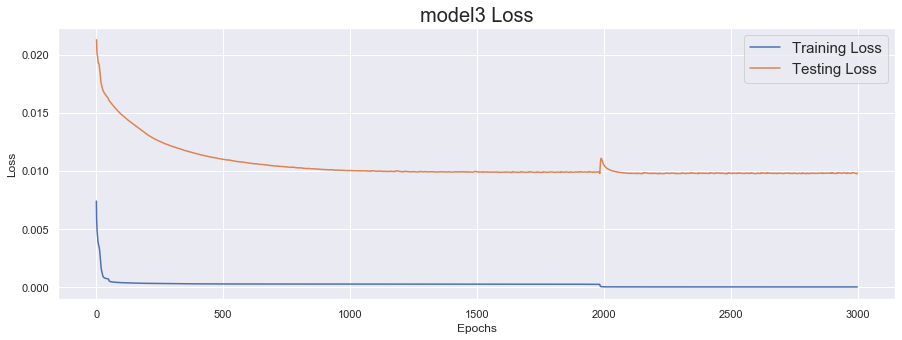

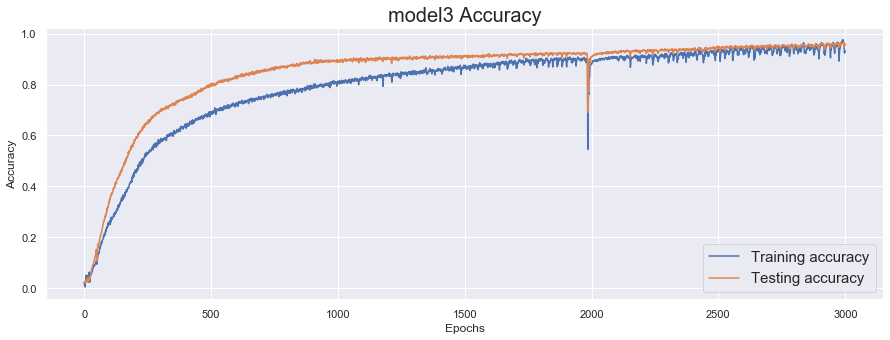

In [261]:
plot_results(history3,'model3')

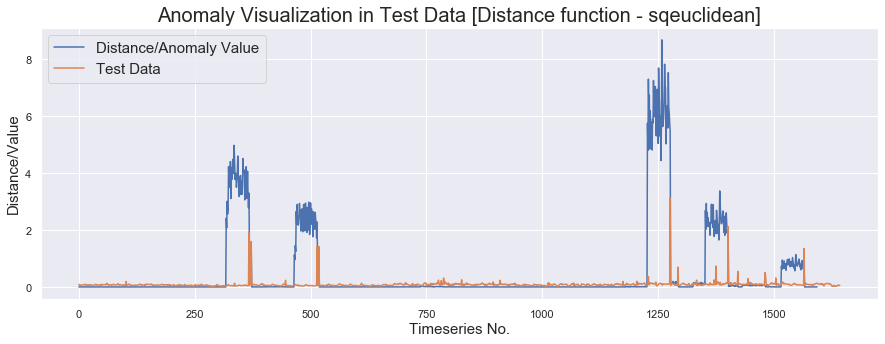

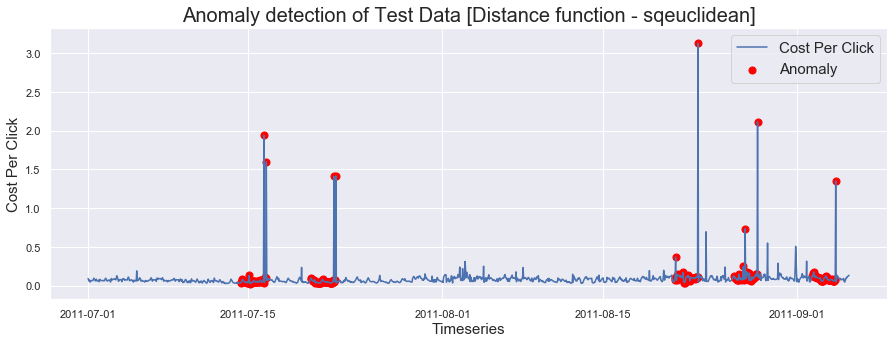

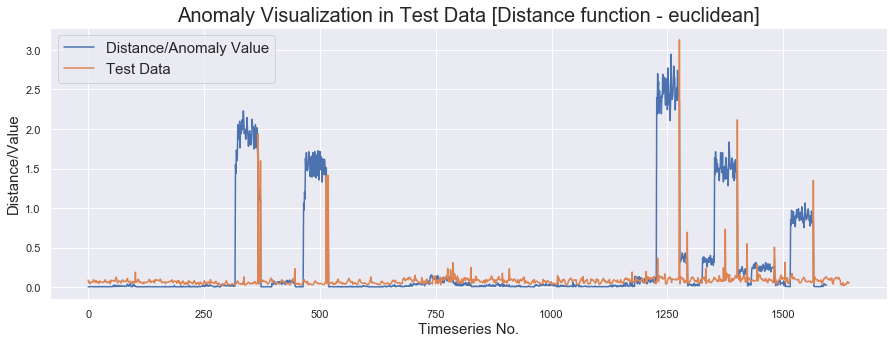

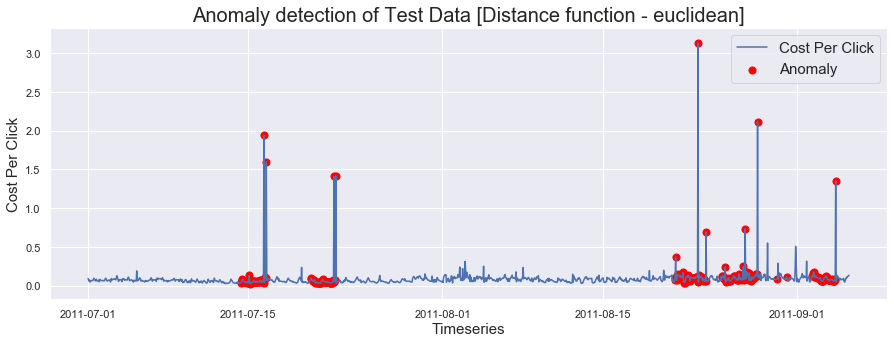

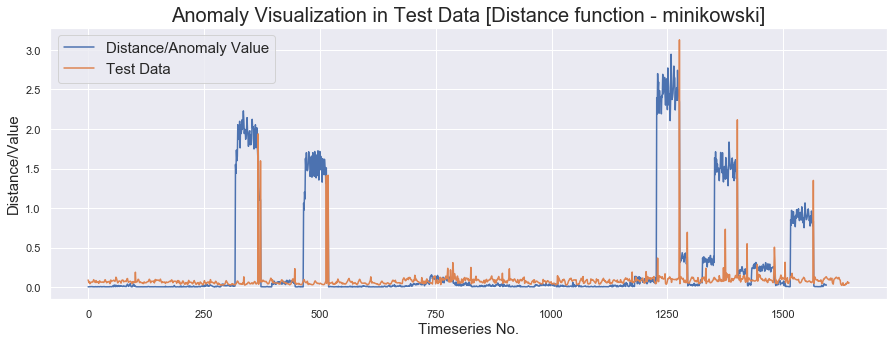

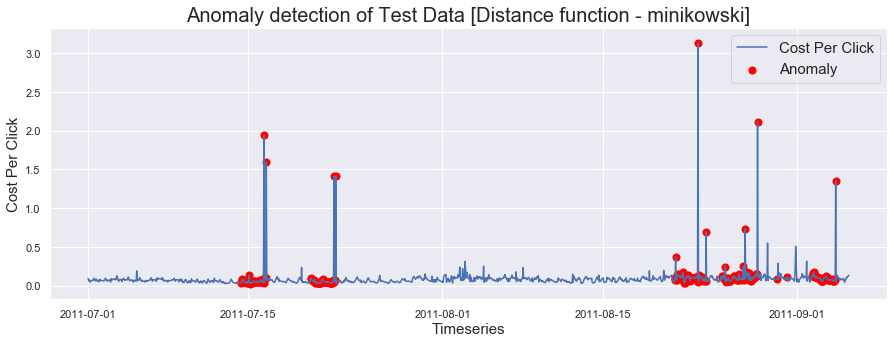

Generated Anomaly Labled Dataset Sample
---------------------------------


value Anomaly
Time                                 
2011-07-01 00:15:01  0.091795       0
2011-07-01 01:15:01  0.074414       0
2011-07-01 02:15:01  0.056984       0
2011-07-01 03:15:01  0.071225       0
2011-07-01 04:15:01  0.045466       0
...                       ...     ...
2011-09-05 09:15:01  0.115096       0
2011-09-05 10:15:01  0.115619       0
2011-09-05 11:15:01  0.120262       0
2011-09-05 12:15:01  0.130407       0
2011-09-05 13:15:01  0.132614       0

[1594 rows x 2 columns]

In [249]:
a1 = detect_anomaly(X_test,model3,'sqeuclidean')
a2 = detect_anomaly(X_test,model3,'euclidean')
a3 = detect_anomaly(X_test,model3,'minikowski')
print('Generated Anomaly Labled Dataset Sample')
print('---------------------------------')
a3

### Discussion of the Results
- **Setup 1 [window size - 10]** - With a window size of 10 which is the lowest of all gave a highest accuracy in reconstruction of the of the set of data than other setups. With anomaly detection to it performed best with all the three distance functions used.
- **Setup 2 [window size - 20]** - With a window size of 20 which gave least accuracy in reconstruction of the of the set of data than other setups. In anomaly detection due to larger window size of taking previous values, detetcted anomalies were pretty late than setup 1.
- **Setup 2 [window size - 50]** - With largest window size of 50 which gave second best accuracy in reconstruction of the of the set of data than other setups. In anomaly detection due to larger window size of taking previous values, detetcted anomalies were pretty late than setup 1 and setup 2.
### Prefered Setup
**Setup 1 ->** This is prefered because its window size is low which means an anomaly can be detected in real time quicker than the other setups.

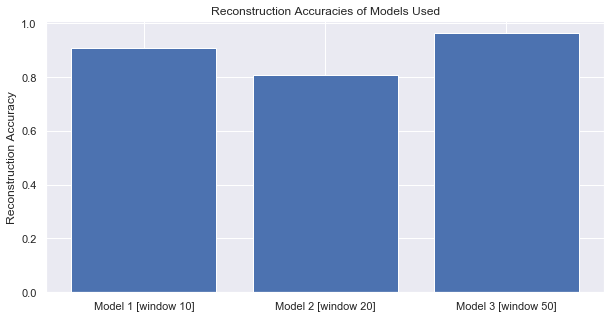

In [262]:
accuracies = [history1.history['val_accuracy'][-1],history2.history['val_accuracy'][-1],history3.history['val_accuracy'][-1]]
plt.figure(figsize=(10,5))
plt.bar(['Model 1 [window 10]','Model 2 [window 20]','Model 3 [window 50]'],accuracies)
plt.ylabel('Reconstruction Accuracy')
plt.title('Reconstruction Accuracies of Models Used')
plt.show()

## Part 2
###  Autoencoders for anomaly detection

### Process of Anomaly detection using autoencoders

* **Train data (without anomalies)**
* **Train Autoencoders to reconstruct the input data**
* **Predict the training data, this is the models ability to reconstruct the data**
* **Fix the max of the MSE error as the threshold for anomaly detection, anything above this value the model predictis as anomalies**
* **Predict the test data with anomalies, the prediction of the model is without anomalies**
* **Calculate the distance using euclidean distance**
* **Plot the graphs**

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
from matplotlib import dates as md
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, RepeatVector, TimeDistributed
from keras.layers import Conv1D, Activation, Dropout, Conv1DTranspose
from keras import backend 
import time as t
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
#tf.debugging.set_log_device_placement(True)
%matplotlib inline
from scipy.spatial.distance import euclidean, sqeuclidean
from sklearn.metrics import confusion_matrix

In [3]:
train_url = "https://raw.githubusercontent.com/numenta/NAB/master/data/realAdExchange/exchange-2_cpc_results.csv"
test_url = "https://raw.githubusercontent.com/numenta/NAB/master/data/realAdExchange/exchange-4_cpc_results.csv"

In [4]:
train_df = pd.read_csv(train_url,index_col=0)
test_df = pd.read_csv(test_url,index_col=0)

In [ ]:
threshold=[]
anomalies_detected=[]

In [5]:
def normalize(values):
    mean = np.mean(values)
    values -= mean
    std = np.std(values)
    values /= std
    return values

In [6]:
training_value = train_df.value.to_list()
training_value = normalize(training_value)

In [7]:
testing_value = test_df.value.to_list()
testing_value = normalize(testing_value)

* Creating sequences based on window size

In [8]:
def create_sequences(values, window):
    output = []
    for i in range(len(values) - window):
        output.append(values[i : (i + window)])
    return np.array(output)

In [9]:
def plot_graphs(history):
  plt.figure(figsize=(15,7))
  plt.title("\n Training loss Vs Validation loss ",size=20)
  plt.plot(history.history["loss"], label="Training Loss")
  plt.plot(history.history["val_loss"], label="Validation Loss")
  plt.xlabel("Epochs",size=15)
  plt.legend()
  plt.show()

In [10]:
def loss_plot(loss):
  plt.figure(figsize=(15,7))
  plt.hist(loss, bins=50)
  plt.xlabel("Train MAE loss",size=15)
  plt.ylabel("No of samples",size=15)
  plt.show()

In [11]:
# Checking how the first sequence is learnt
def sample(x_train,x_train_pred):
  plt.figure(figsize=(15,7))
  plt.title("\n Predicting the first sample ",size=20)
  plt.plot(x_train[0],label=" Training data")
  plt.plot(x_train_pred[0],label=" Predicted data")
  plt.xlabel("Timestamp per day",size=15)
  plt.legend()
  plt.show()

* Function to calculate the distance

In [12]:
def dist(name,arr1,arr2):
    distances = []
    for i in range(arr1.shape[0]):
            if(name=='euclidean'):
                d = euclidean(arr1[i],arr2[i])
                distances.append(d)
    return np.array(distances)

In [13]:
'''
distance_type - 'euclidean'
function for detecting anomalies
'''  
def detect_anomaly(X_test,model1,distance_type):
    prediction = model1.predict(X_test)
    Distance = dist(distance_type,prediction,X_test)
    plt.figure(figsize=(15,7))
    plt.plot(Distance,label = 'Distance/Anomaly Value', color='r')
    plt.plot(np.array(test_df['value']),label = 'Test Data')
    plt.legend(loc='best',fontsize=15)
    plt.ylabel('Distance/Value',size=15)
    plt.xlabel('Timeseries No.',size=15)
    plt.title('Anomaly Visualization in Test Data [Distance function - {}]'.format(distance_type),size=20)
    plt.show()

In [14]:
window_size=24

In [15]:
x_train = create_sequences(training_value, window_size)
x_train = np.expand_dims(x_train, axis=2)
print("Training input shape: ", x_train.shape)

Training input shape:  (1600, 24, 1)


In [16]:
input_shape=(x_train.shape[1:3])

In [17]:
early=keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")

## Setup 1: Using Conv1D 

In [18]:
model_1 = Sequential()
model_1.add(Conv1D(32, 3,input_shape=input_shape, padding="same", strides=2, activation="relu"))
model_1.add(Dropout(0.2))
model_1.add(Conv1D(16, 3, padding="same", strides=2, activation="relu"))
model_1.add(Conv1DTranspose(16, 3, padding="same", strides=2, activation="relu"))
model_1.add(Dropout(0.2))
model_1.add(Conv1DTranspose(32, 3, padding="same", strides=2))
model_1.add(Conv1DTranspose(1, 3, padding="same"))

model_1.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 12, 32)            128       
_________________________________________________________________
dropout (Dropout)            (None, 12, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 6, 16)             1552      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 12, 16)            784       
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 16)            0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 24, 32)            1568      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 24, 1)             9

In [19]:
model_1_hist = model_1.fit( x_train,x_train, epochs=100,batch_size=32, validation_split=0.2,callbacks=[early])

Epoch 1/100
40/40 [==============================] - 0s 9ms/step - loss: 0.5991 - val_loss: 0.2098
Epoch 2/100
40/40 [==============================] - 0s 3ms/step - loss: 0.2044 - val_loss: 0.1215
Epoch 3/100
40/40 [==============================] - 0s 3ms/step - loss: 0.1632 - val_loss: 0.1000
Epoch 4/100
40/40 [==============================] - 0s 4ms/step - loss: 0.1431 - val_loss: 0.0859
Epoch 5/100
40/40 [==============================] - 0s 3ms/step - loss: 0.1296 - val_loss: 0.0800
Epoch 6/100
40/40 [==============================] - 0s 3ms/step - loss: 0.1177 - val_loss: 0.0728
Epoch 7/100
40/40 [==============================] - 0s 3ms/step - loss: 0.1100 - val_loss: 0.0660
Epoch 8/100
40/40 [==============================] - 0s 4ms/step - loss: 0.1022 - val_loss: 0.0592
Epoch 9/100
40/40 [==============================] - 0s 4ms/step - loss: 0.0931 - val_loss: 0.0501
Epoch 10/100
40/40 [==============================] - 0s 4ms/step - loss: 0.0853 - val_loss: 0.0452
Epoch 11/

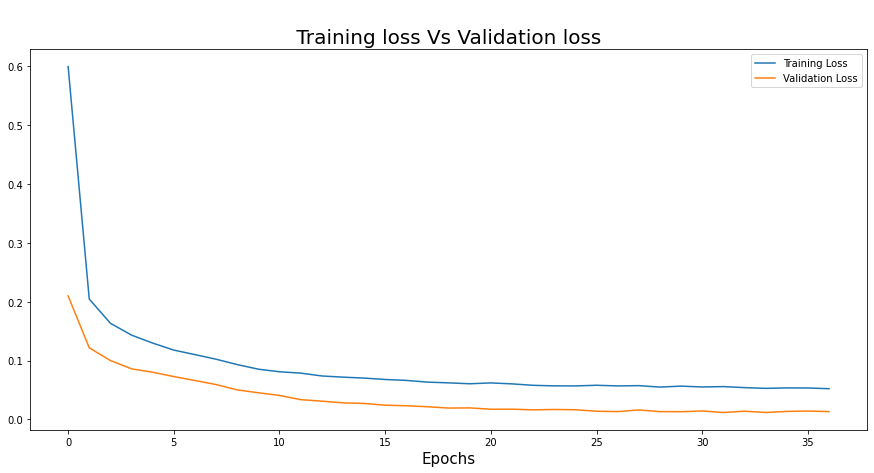

In [20]:
plot_graphs(model_1_hist)

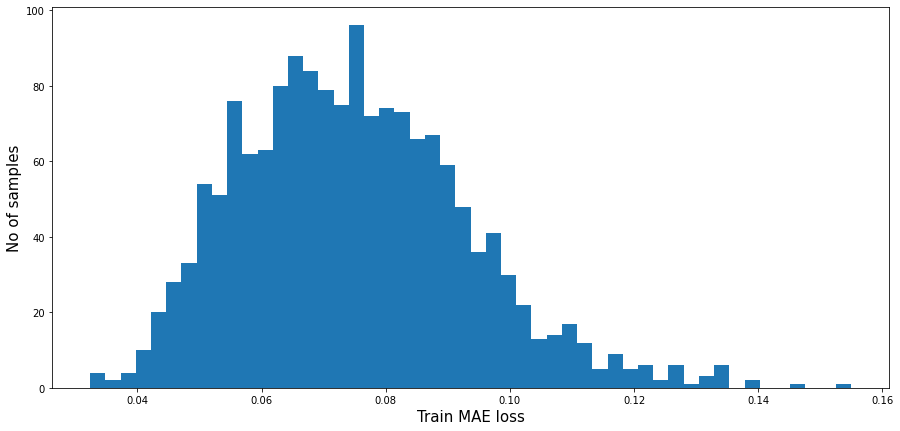

In [21]:
# Get train MAE loss.
x_train_pred = model_1.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)
loss_plot(train_mae_loss)

In [22]:
# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)
thresholds.append(threshold)

Reconstruction error threshold:  0.15493356186970728


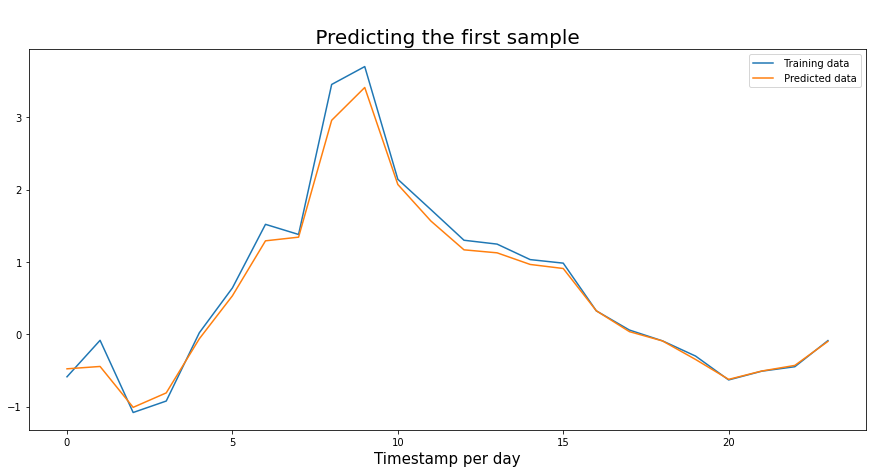

In [23]:
sample(x_train,x_train_pred)

* We can see that the model 1 predicts the first data sample 

Test input shape:  (1619, 24, 1)


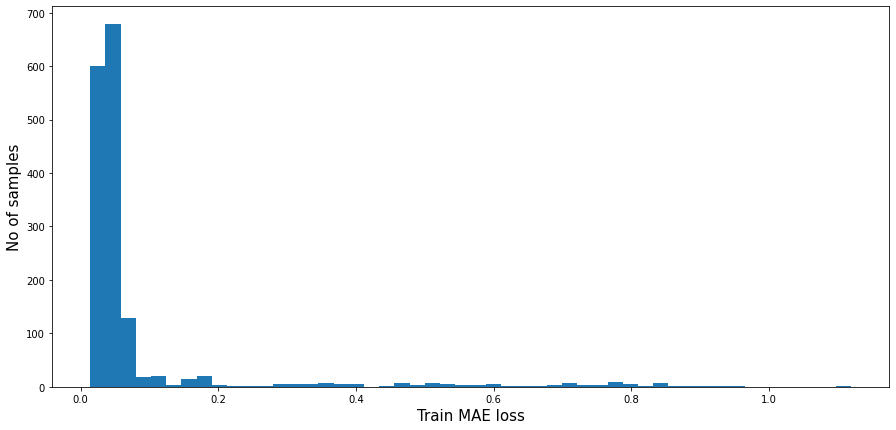

Number of anomaly samples:  165
Indices of anomaly samples:  (array([ 344,  345,  346,  347,  348,  349,  350,  351,  352,  353,  354,
        355,  356,  357,  358,  359,  360,  361,  362,  363,  364,  365,
        366,  367,  368,  369,  370,  371,  372,  491,  492,  493,  494,
        495,  496,  497,  498,  499,  500,  501,  502,  503,  504,  505,
        506,  507,  508,  509,  510,  511,  512,  513,  514,  515,  516,
        517,  518, 1253, 1254, 1255, 1256, 1257, 1258, 1259, 1260, 1261,
       1262, 1263, 1264, 1265, 1266, 1267, 1268, 1269, 1270, 1271, 1272,
       1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280, 1281, 1282, 1283,
       1284, 1285, 1286, 1287, 1288, 1290, 1291, 1292, 1293, 1353, 1355,
       1356, 1357, 1359, 1360, 1361, 1362, 1363, 1364, 1365, 1366, 1367,
       1368, 1369, 1370, 1371, 1374, 1375, 1378, 1379, 1380, 1381, 1382,
       1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1391, 1392, 1393,
       1394, 1395, 1396, 1397, 1398, 1399, 1400, 1401, 1421, 1

In [24]:
# Create sequences from test values.
x_test = create_sequences(testing_value,window_size)
x_test = np.expand_dims(x_test, axis=2)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model_1.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape(-1)
loss_plot(test_mae_loss)

# Detect all the samples which are anomalies.
anomalies = (test_mae_loss > threshold).tolist()
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))
anomalies_detected.append(np.sum(anomalies))

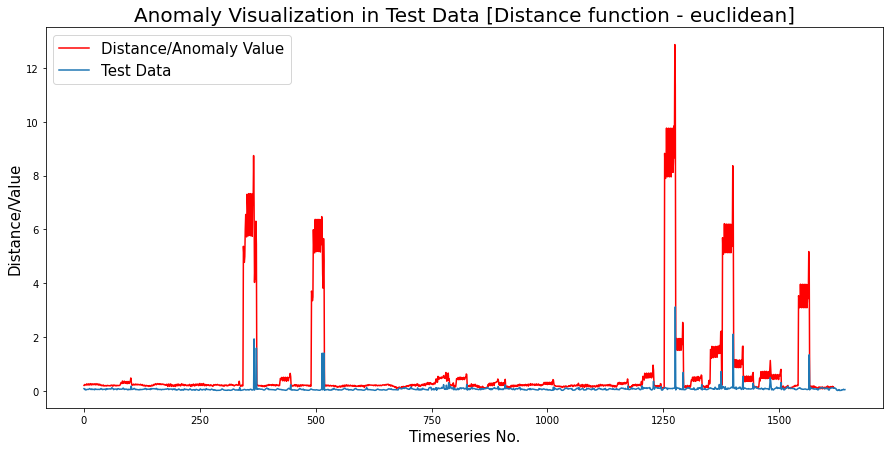

In [25]:
detect_anomaly(x_test,model_1,'euclidean')

* By plotting the distance and the test data, we can observe that the model_1 predicts the anomalies in the test data.

## Setup 2: Using LSTM

In [26]:
model_2 = Sequential()
model_2.add(LSTM(32, activation='relu', input_shape=input_shape, return_sequences=True))
model_2.add(LSTM(16, activation='relu', return_sequences=True))
model_2.add(LSTM(4, activation='relu',return_sequences=True))
model_2.add(LSTM(16, activation='relu', return_sequences=True))
model_2.add(LSTM(32, activation='relu', return_sequences=True))
model_2.add(TimeDistributed(Dense(x_train.shape[2])))

model_2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 24, 32)            4352      
_________________________________________________________________
lstm_1 (LSTM)                (None, 24, 16)            3136      
_________________________________________________________________
lstm_2 (LSTM)                (None, 24, 4)             336       
_________________________________________________________________
lstm_3 (LSTM)                (None, 24, 16)            1344      
_________________________________________________________________
lstm_4 (LSTM)                (None, 24, 32)            6272      
_________________________________________________________________
time_distributed (TimeDistri (None, 24, 1)             33        
Total params: 15,473
Trainable params: 15,473
Non-trainable params: 0
__________________________________________________

In [27]:
model_2_hist = model_2.fit( x_train,x_train, epochs=100,batch_size=32, validation_split=0.2, callbacks=[early])

Epoch 1/100
40/40 [==============================] - 2s 48ms/step - loss: 1.0115 - val_loss: 0.9502
Epoch 2/100
40/40 [==============================] - 1s 32ms/step - loss: 1.0019 - val_loss: 0.9283
Epoch 3/100
40/40 [==============================] - 1s 34ms/step - loss: 0.9468 - val_loss: 0.8574
Epoch 4/100
40/40 [==============================] - 1s 32ms/step - loss: 0.7646 - val_loss: 0.6361
Epoch 5/100
40/40 [==============================] - 2s 38ms/step - loss: 0.5721 - val_loss: 0.4803
Epoch 6/100
40/40 [==============================] - 1s 32ms/step - loss: 0.3765 - val_loss: 0.3006
Epoch 7/100
40/40 [==============================] - 1s 33ms/step - loss: 0.2595 - val_loss: 0.2143
Epoch 8/100
40/40 [==============================] - 1s 32ms/step - loss: 0.2065 - val_loss: 0.1744
Epoch 9/100
40/40 [==============================] - 1s 32ms/step - loss: 0.1709 - val_loss: 0.1467
Epoch 10/100
40/40 [==============================] - 1s 33ms/step - loss: 0.1446 - val_loss: 0.1269

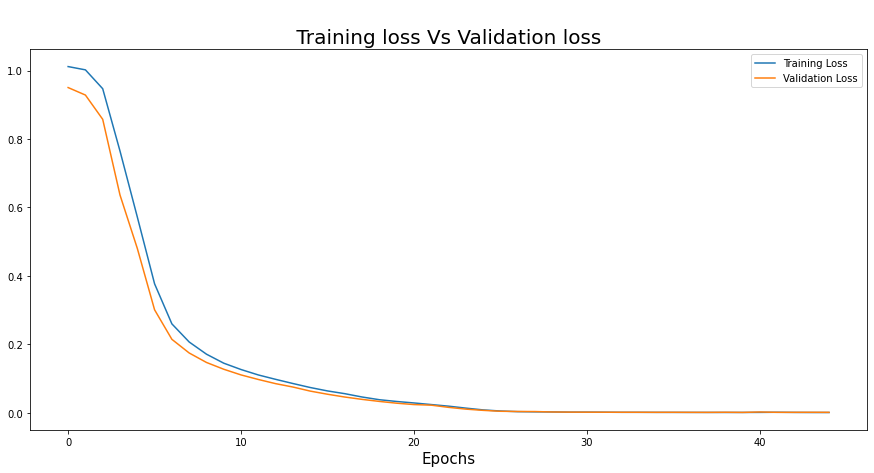

In [28]:
plot_graphs(model_2_hist)

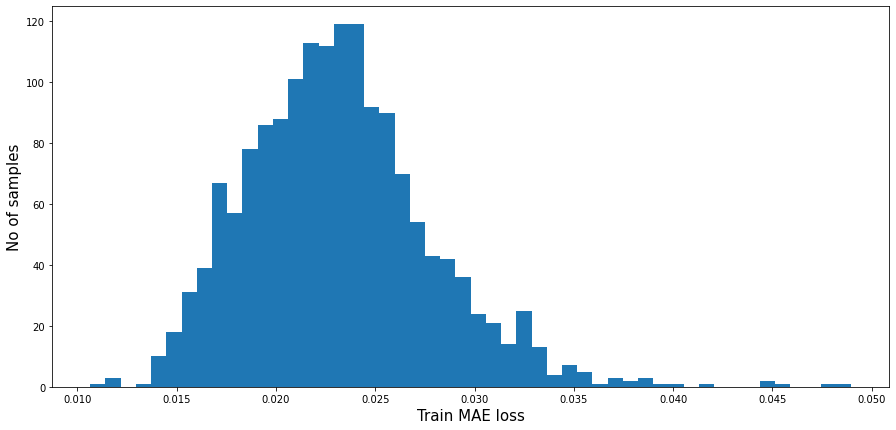

In [29]:
x_train_pred = model_2.predict(x_train)
train_mae_loss = np.mean(np.abs((x_train_pred) - x_train), axis=1)
loss_plot(train_mae_loss)

In [30]:
# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)
thresholds.append(threshold)

Reconstruction error threshold:  0.048967966990717704


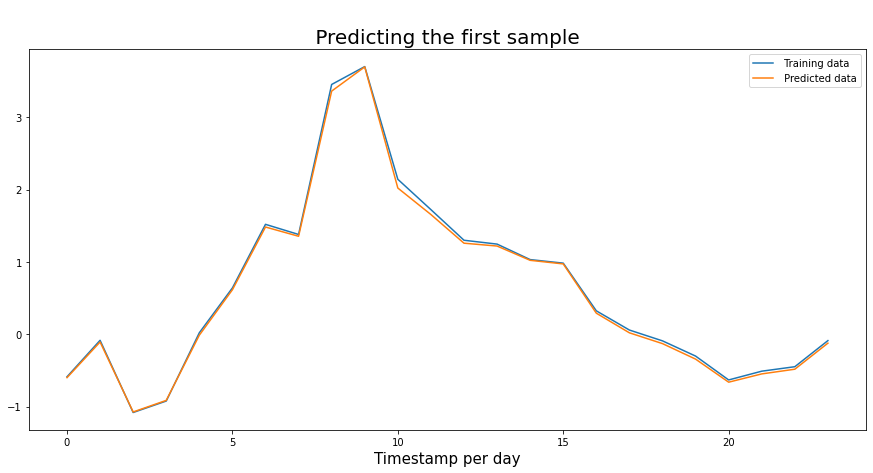

In [31]:
sample(x_train,x_train_pred)

* We can see that the model 2 predicts the first sample very accuratly, this model reconstructs the original data. This can be clearly seen from the threshold value which is very small comparatively.

Test input shape:  (1619, 24, 1)


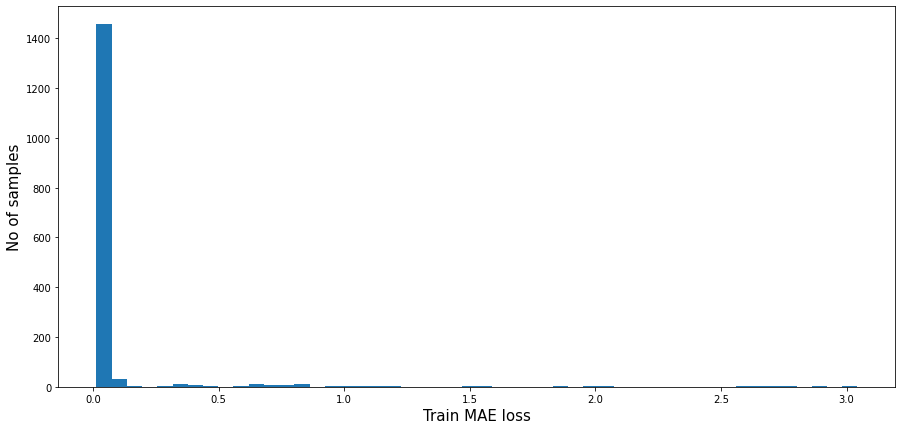

Number of anomaly samples:  173
Indices of anomaly samples:  (array([ 344,  345,  346,  347,  348,  349,  350,  351,  352,  353,  354,
        355,  356,  357,  358,  359,  360,  361,  362,  363,  364,  365,
        366,  367,  368,  369,  370,  371,  372,  491,  492,  493,  494,
        495,  496,  497,  498,  499,  500,  501,  502,  503,  504,  505,
        506,  507,  508,  509,  510,  511,  512,  513,  514,  515,  516,
        517,  518, 1253, 1254, 1255, 1256, 1257, 1258, 1259, 1260, 1261,
       1262, 1263, 1264, 1265, 1266, 1267, 1268, 1269, 1270, 1271, 1272,
       1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280, 1281, 1282, 1283,
       1284, 1285, 1286, 1287, 1288, 1290, 1291, 1292, 1293, 1352, 1353,
       1354, 1355, 1356, 1357, 1358, 1359, 1360, 1361, 1362, 1363, 1364,
       1365, 1366, 1367, 1368, 1369, 1370, 1371, 1372, 1373, 1374, 1375,
       1378, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388,
       1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1

In [32]:
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model_2.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape(-1)
loss_plot(test_mae_loss)

# Detect all the samples which are anomalies.
anomalies = (test_mae_loss > threshold).tolist()
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))
anomalies_detected.append(np.sum(anomalies))

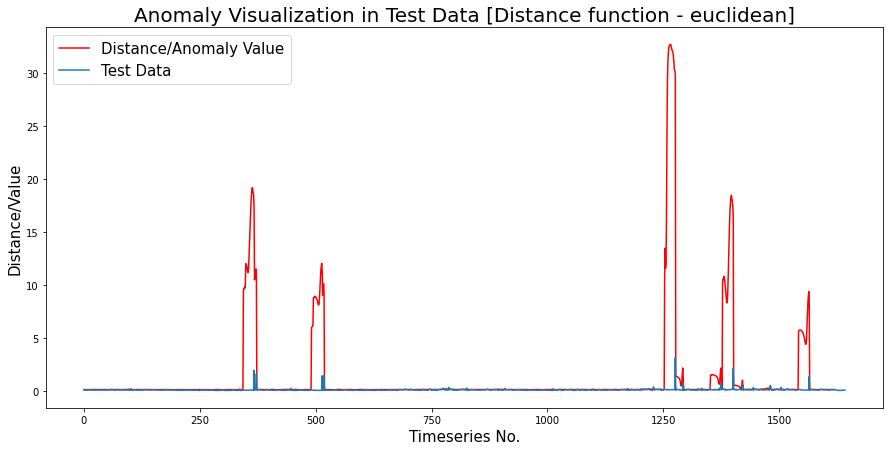

In [33]:
detect_anomaly(x_test,model_2,'euclidean')

In [34]:
x_train = create_sequences(training_value, window_size)
print("Training input shape: ", x_train.shape)

Training input shape:  (1600, 24)


## Setup 3: Using Dense

In [35]:
model_3 = Sequential()
model_3.add(Dense(128, activation='relu', input_shape=[x_train.shape[1]]))
model_3.add(Dense(64, activation='relu'))
model_3.add(Dense(8, activation='relu'))
model_3.add(Dense(64, activation='relu'))
model_3.add(Dense(24, activation='relu'))

model_3.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss="mse")
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               3200      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                576       
_________________________________________________________________
dense_5 (Dense)              (None, 24)                1560      
Total params: 14,112
Trainable params: 14,112
Non-trainable params: 0
_________________________________________________________________


In [36]:
model_3_hist = model_3.fit( x_train, x_train, epochs=100,batch_size=16, validation_split=0.2,callbacks=[early])

Epoch 1/100
80/80 [==============================] - 0s 3ms/step - loss: 0.8338 - val_loss: 0.5934
Epoch 2/100
80/80 [==============================] - 0s 2ms/step - loss: 0.7523 - val_loss: 0.5648
Epoch 3/100
80/80 [==============================] - 0s 2ms/step - loss: 0.7381 - val_loss: 0.5470
Epoch 4/100
80/80 [==============================] - 0s 2ms/step - loss: 0.7230 - val_loss: 0.5306
Epoch 5/100
80/80 [==============================] - 0s 2ms/step - loss: 0.7031 - val_loss: 0.5193
Epoch 6/100
80/80 [==============================] - 0s 2ms/step - loss: 0.6975 - val_loss: 0.4953
Epoch 7/100
80/80 [==============================] - 0s 2ms/step - loss: 0.6882 - val_loss: 0.4974
Epoch 8/100
80/80 [==============================] - 0s 2ms/step - loss: 0.6835 - val_loss: 0.4911
Epoch 9/100
80/80 [==============================] - 0s 2ms/step - loss: 0.6829 - val_loss: 0.4904
Epoch 10/100
80/80 [==============================] - 0s 2ms/step - loss: 0.6833 - val_loss: 0.4888
Epoch 11/

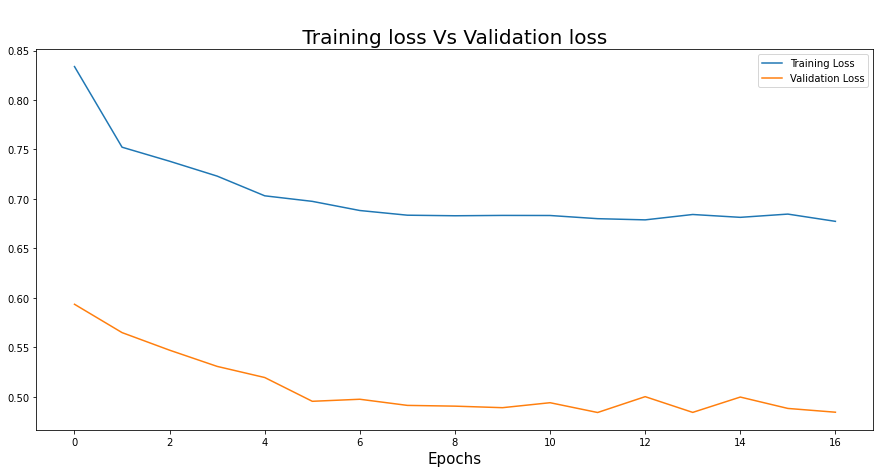

In [37]:
plot_graphs(model_3_hist)

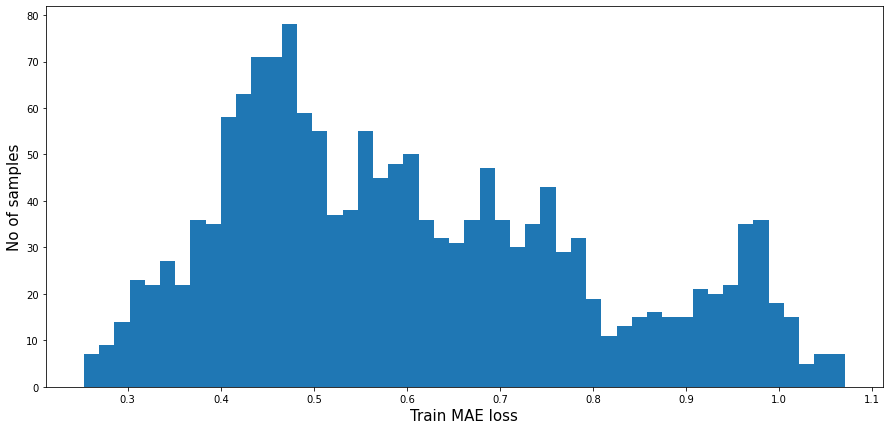

In [38]:
# Get train MAE loss.
x_train_pred = model_3.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)
loss_plot(train_mae_loss)

In [39]:
# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)
thresholds.append(threshold)

Reconstruction error threshold:  1.070674974557699


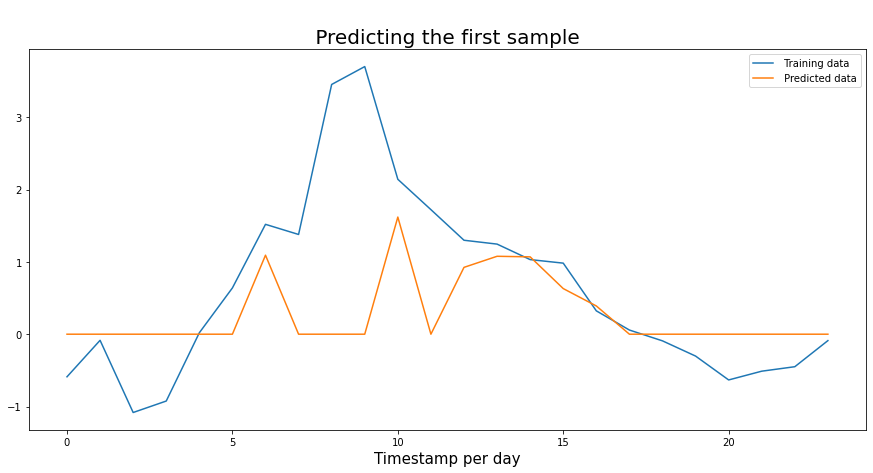

In [40]:
sample(x_train,x_train_pred)

* The model 3 was a very shallow network with 3 dense layers but it is not able to reconstruct the data accurately. Therefore we perform some hyperparameters tuning and observe the results.

Test input shape:  (1619, 24)


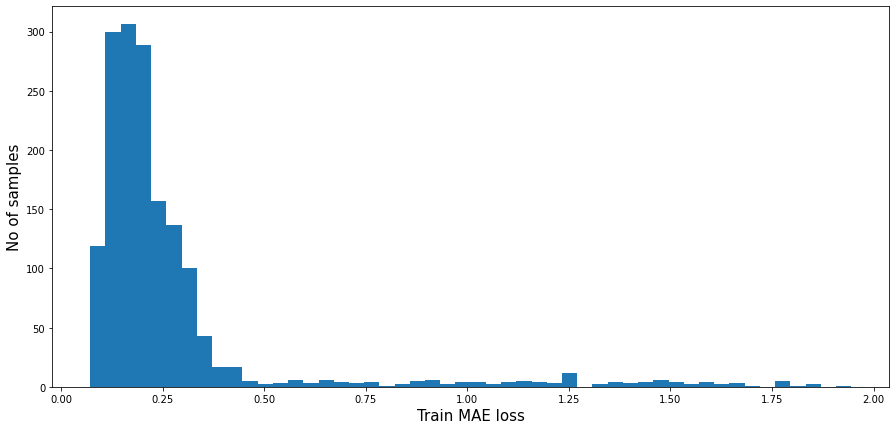

Number of anomaly samples:  74
Indices of anomaly samples:  (array([ 344,  345,  347,  348,  349,  350,  351,  352,  353,  354,  355,
        356,  357,  358,  359,  360,  361,  362,  363,  364,  365,  366,
        367,  495,  496,  497,  498,  499,  500,  501,  502,  503,  504,
        505,  506,  507,  509,  511,  512,  513,  514, 1253, 1254, 1255,
       1256, 1257, 1258, 1259, 1260, 1261, 1262, 1263, 1264, 1265, 1266,
       1267, 1268, 1269, 1270, 1271, 1272, 1273, 1274, 1275, 1276, 1378,
       1381, 1382, 1383, 1384, 1385, 1399, 1400, 1401]),)


In [41]:
x_test = create_sequences(testing_value, window_size)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model_3.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape(-1)
loss_plot(test_mae_loss)

# Detect all the samples which are anomalies.
anomalies = (test_mae_loss > threshold).tolist()
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))
anomalies_detected.append(np.sum(anomalies))

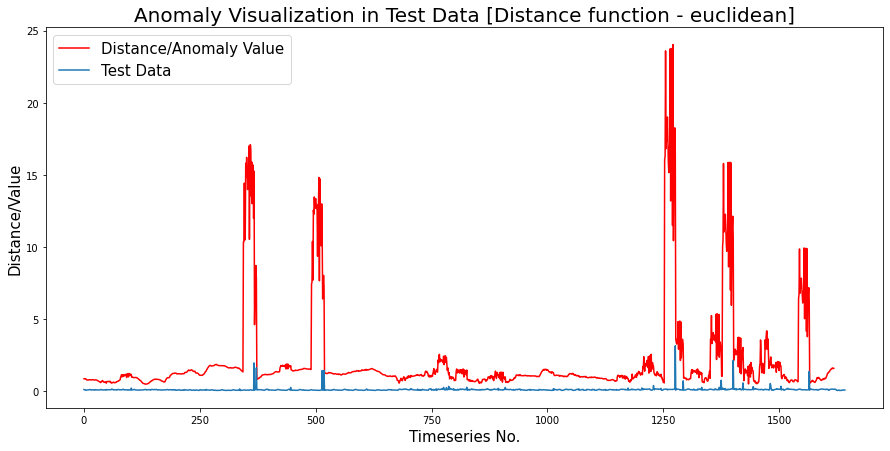

In [42]:
detect_anomaly(x_test,model_3,'euclidean')

## 2. Hyperparameter tuning for model 3

### Model 3 version 1
* Increasing the depth of the network in model 3

In [44]:
model_3_v1 = Sequential()
model_3_v1.add(Dense(256, activation='relu', input_shape=[x_train.shape[1]]))
model_3_v1.add(Dense(128, activation='relu'))
model_3_v1.add(Dense(64, activation='relu'))
model_3_v1.add(Dense(8, activation='relu'))
model_3_v1.add(Dense(64, activation='relu'))
model_3_v1.add(Dense(128, activation='relu'))
model_3_v1.add(Dense(24, activation='relu'))

model_3_v1.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss="mse")
model_3_v1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 256)               6400      
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_10 (Dense)             (None, 64)                576       
_________________________________________________________________
dense_11 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_12 (Dense)             (None, 24)               

In [45]:
model_3_v1_hist = model_3_v1.fit( x_train, x_train, epochs=100,batch_size=16, validation_split=0.2,callbacks=[early])

Epoch 1/100
80/80 [==============================] - 0s 3ms/step - loss: 0.8073 - val_loss: 0.5569
Epoch 2/100
80/80 [==============================] - 0s 3ms/step - loss: 0.7559 - val_loss: 0.5828
Epoch 3/100
80/80 [==============================] - 0s 2ms/step - loss: 0.7554 - val_loss: 0.5537
Epoch 4/100
80/80 [==============================] - 0s 2ms/step - loss: 0.7376 - val_loss: 0.5654
Epoch 5/100
80/80 [==============================] - 0s 2ms/step - loss: 0.7250 - val_loss: 0.5602
Epoch 6/100
80/80 [==============================] - 0s 2ms/step - loss: 0.7133 - val_loss: 0.5312
Epoch 7/100
80/80 [==============================] - 0s 2ms/step - loss: 0.6948 - val_loss: 0.5213
Epoch 8/100
80/80 [==============================] - 0s 3ms/step - loss: 0.7121 - val_loss: 0.5538
Epoch 9/100
80/80 [==============================] - 0s 3ms/step - loss: 0.7142 - val_loss: 0.5294
Epoch 10/100
80/80 [==============================] - 0s 3ms/step - loss: 0.6878 - val_loss: 0.5054
Epoch 11/

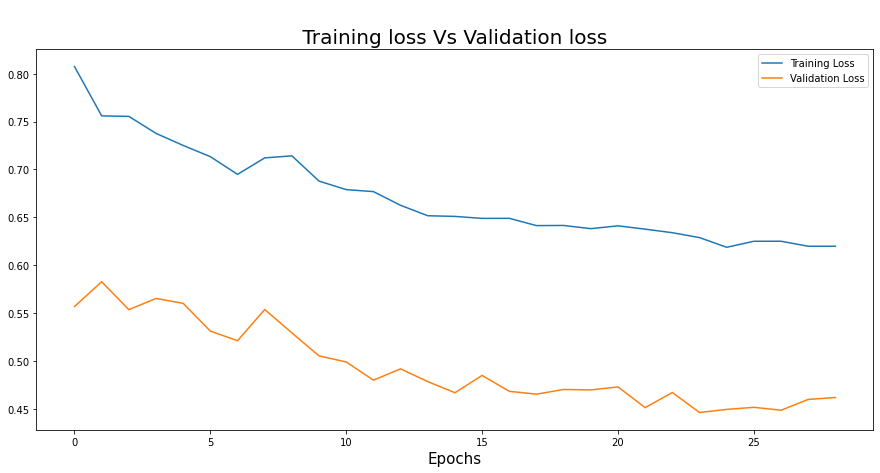

In [46]:
plot_graphs(model_3_v1_hist)

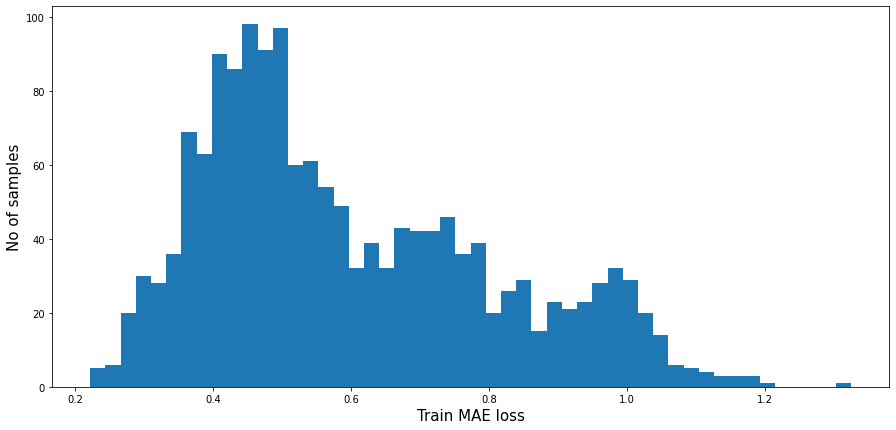

In [47]:
# Get train MAE loss.
x_train_pred = model_3_v1.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)
loss_plot(train_mae_loss)

In [48]:
# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)
thresholds.append(threshold)

Reconstruction error threshold:  1.3252752251246458


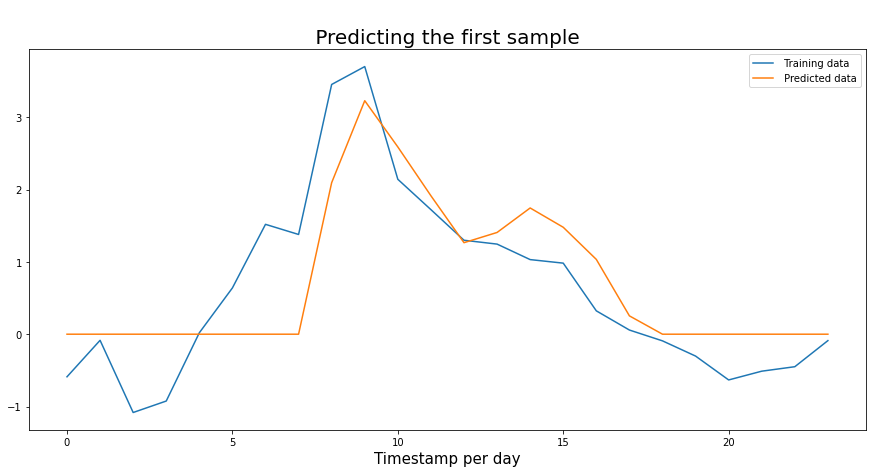

In [49]:
sample(x_train,x_train_pred)

* This model dosen't seem to reconstruct the input data when compared to the model 3, this can be seen from the sample plot and high threshold value.

Test input shape:  (1619, 24)


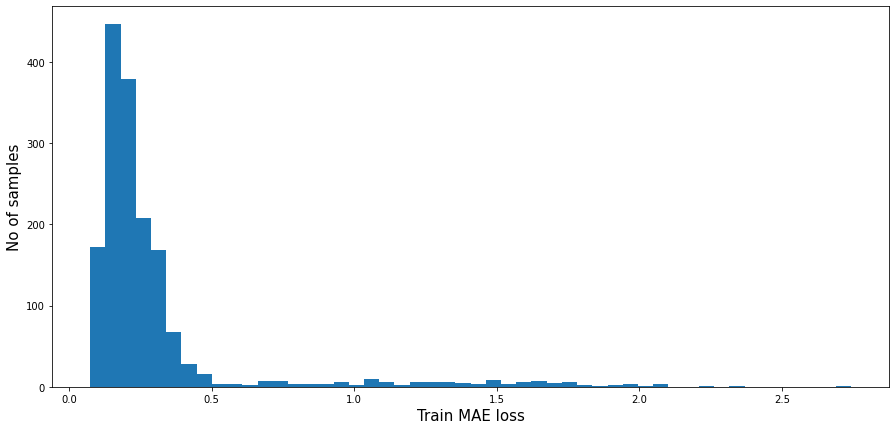

Number of anomaly samples:  62
Indices of anomaly samples:  (array([ 349,  350,  351,  352,  353,  354,  355,  356,  357,  358,  359,
        360,  361,  362,  363,  364,  365,  366,  367,  495,  497,  498,
        499,  500,  501,  502,  503,  504,  506,  507,  508,  510,  511,
        514, 1253, 1254, 1255, 1257, 1258, 1259, 1260, 1261, 1262, 1263,
       1264, 1265, 1266, 1267, 1268, 1269, 1270, 1271, 1272, 1273, 1274,
       1275, 1276, 1386, 1387, 1399, 1400, 1401]),)


In [50]:
x_test = create_sequences(testing_value, window_size)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model_3_v1.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape(-1)
loss_plot(test_mae_loss)

# Detect all the samples which are anomalies.
anomalies = (test_mae_loss > threshold).tolist()
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))
anomalies_detected.append(np.sum(anomalies))

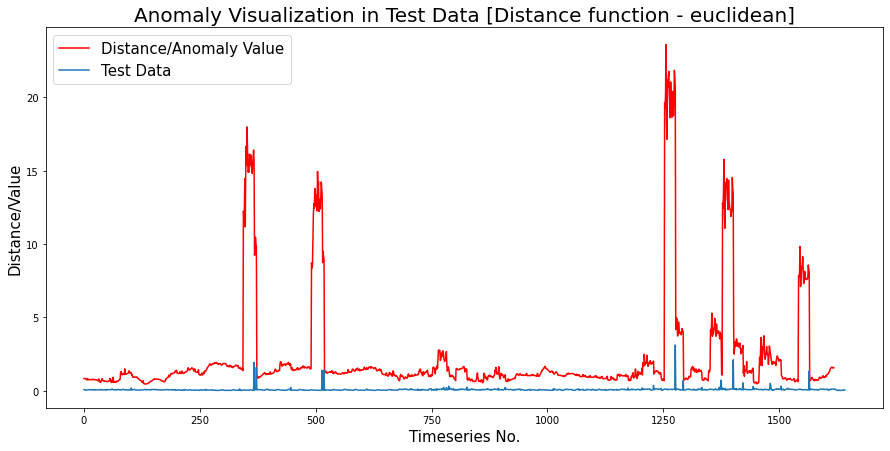

In [51]:
detect_anomaly(x_test,model_3_v1,'euclidean')

### Model 3 version 2

* Using the different optimizer on the previous model.

In [54]:
model_3_v2 = Sequential()
model_3_v2.add(Dense(256, activation='relu', input_shape=[x_train.shape[1]]))
model_3_v2.add(Dense(128, activation='relu'))
model_3_v2.add(Dense(64, activation='relu'))
model_3_v2.add(Dense(8, activation='relu'))
model_3_v2.add(Dense(64, activation='relu'))
model_3_v2.add(Dense(128, activation='relu'))
model_3_v2.add(Dense(24, activation='relu'))

model_3_v2.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01), loss="mse")
model_3_v2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 256)               6400      
_________________________________________________________________
dense_14 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_15 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_17 (Dense)             (None, 64)                576       
_________________________________________________________________
dense_18 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_19 (Dense)             (None, 24)               

In [55]:
model_3_v2_hist = model_3_v2.fit( x_train, x_train, epochs=100,batch_size=16, validation_split=0.2,callbacks=[early])

Epoch 1/100
80/80 [==============================] - 0s 3ms/step - loss: 1.0148 - val_loss: 0.8925
Epoch 2/100
80/80 [==============================] - 0s 2ms/step - loss: 1.0050 - val_loss: 0.8803
Epoch 3/100
80/80 [==============================] - 0s 2ms/step - loss: 0.9941 - val_loss: 0.8615
Epoch 4/100
80/80 [==============================] - 0s 2ms/step - loss: 0.9799 - val_loss: 0.8366
Epoch 5/100
80/80 [==============================] - 0s 2ms/step - loss: 0.9617 - val_loss: 0.8047
Epoch 6/100
80/80 [==============================] - 0s 2ms/step - loss: 0.9404 - val_loss: 0.7704
Epoch 7/100
80/80 [==============================] - 0s 2ms/step - loss: 0.9186 - val_loss: 0.7392
Epoch 8/100
80/80 [==============================] - 0s 2ms/step - loss: 0.8999 - val_loss: 0.7147
Epoch 9/100
80/80 [==============================] - 0s 2ms/step - loss: 0.8850 - val_loss: 0.6951
Epoch 10/100
80/80 [==============================] - 0s 2ms/step - loss: 0.8720 - val_loss: 0.6793
Epoch 11/

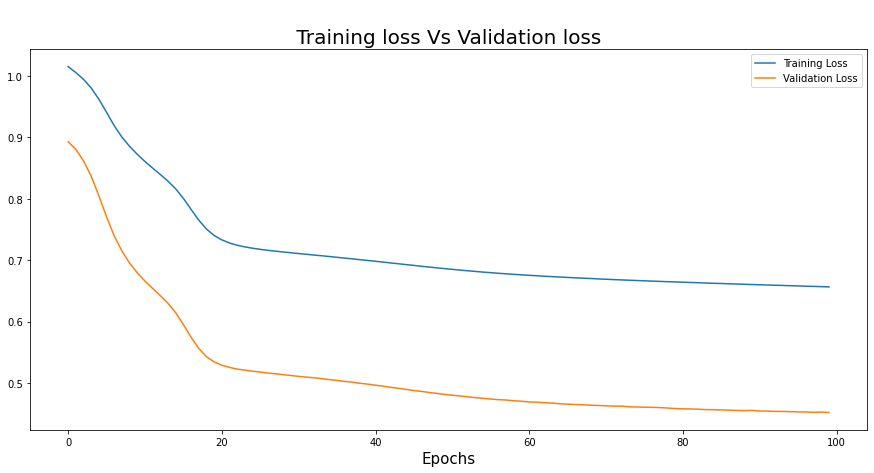

In [56]:
plot_graphs(model_3_v2_hist)

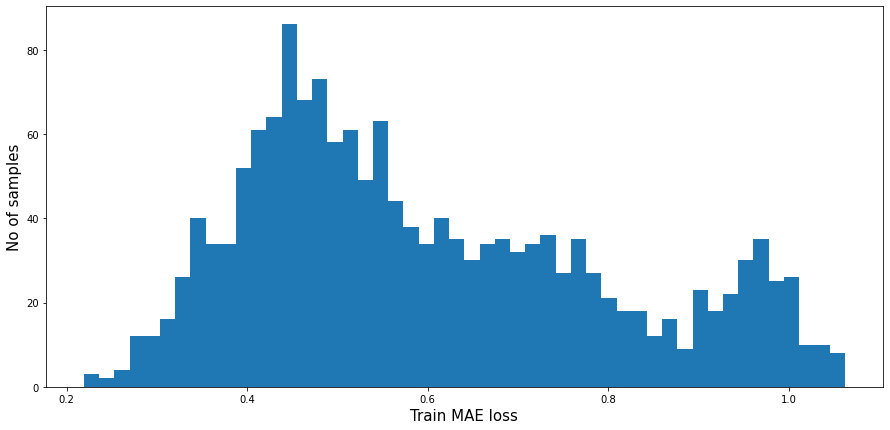

In [57]:
# Get train MAE loss.
x_train_pred = model_3_v2.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)
loss_plot(train_mae_loss)

In [58]:
# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)
thresholds.append(threshold)

Reconstruction error threshold:  1.061748934739325


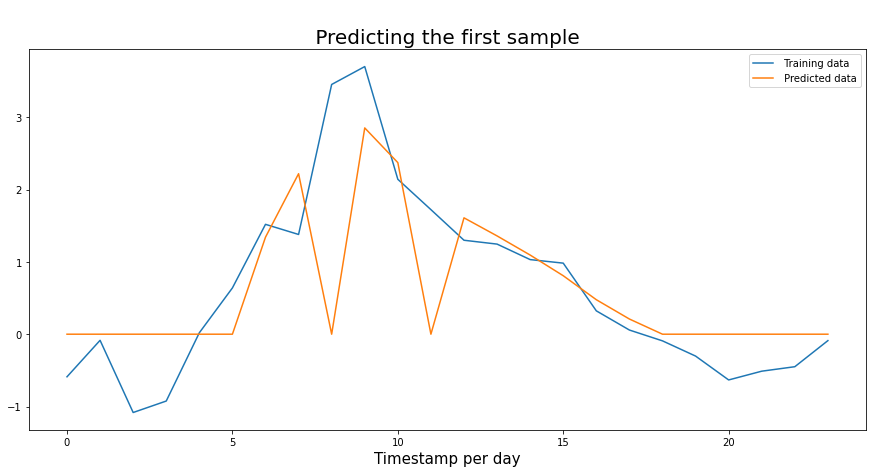

In [59]:
sample(x_train,x_train_pred)

* The model hasen't performed better than the previous version

Test input shape:  (1619, 24)


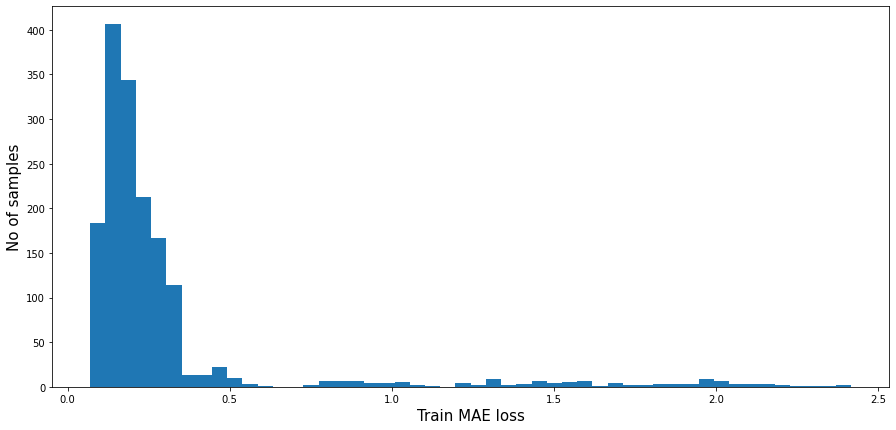

Number of anomaly samples:  94
Indices of anomaly samples:  (array([ 344,  345,  346,  347,  348,  349,  350,  351,  352,  353,  354,
        355,  356,  357,  358,  359,  360,  361,  362,  363,  364,  365,
        366,  367,  369,  495,  496,  497,  498,  499,  500,  501,  502,
        503,  504,  505,  506,  507,  508,  509,  510,  511,  512,  513,
        514,  515, 1253, 1254, 1255, 1256, 1257, 1258, 1259, 1260, 1261,
       1262, 1263, 1264, 1265, 1266, 1267, 1268, 1269, 1270, 1271, 1272,
       1273, 1274, 1275, 1276, 1378, 1379, 1380, 1381, 1382, 1383, 1384,
       1385, 1386, 1387, 1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395,
       1396, 1397, 1398, 1399, 1400, 1401]),)


In [60]:
x_test = create_sequences(testing_value, window_size)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model_3_v2.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape(-1)
loss_plot(test_mae_loss)

# Detect all the samples which are anomalies.
anomalies = (test_mae_loss > threshold).tolist()
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))
anomalies_detected.append(np.sum(anomalies))

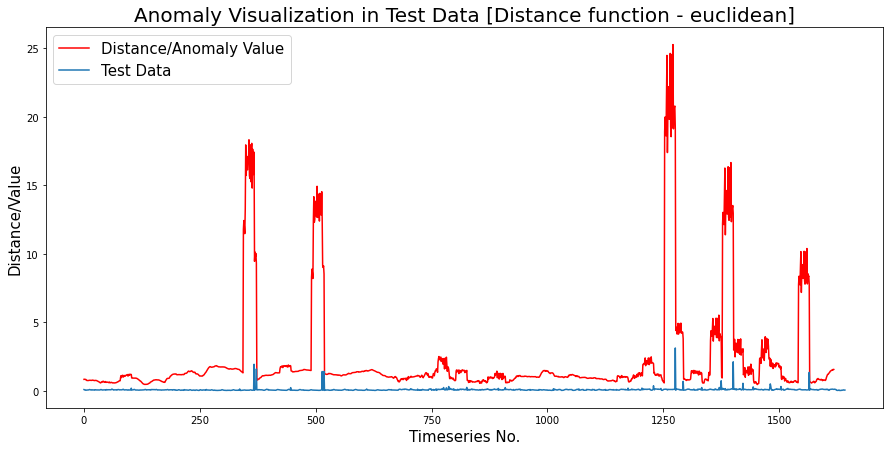

In [61]:
detect_anomaly(x_test,model_3_v2,'euclidean')

### Model 3 version 3

* Using the different optimizer and activation on the previous model.

In [66]:
model_3_v3 = Sequential()
model_3_v3.add(Dense(256, activation='relu', input_shape=[x_train.shape[1]]))
model_3_v3.add(Dense(128, activation='relu'))
model_3_v3.add(Dense(64, activation='relu'))
model_3_v3.add(Dense(8, activation='sigmoid'))
model_3_v3.add(Dense(64, activation='relu'))
model_3_v3.add(Dense(128, activation='relu'))
model_3_v3.add(Dense(24, activation='relu'))

model_3_v3.compile(optimizer=keras.optimizers.Adadelta(learning_rate=0.01), loss="mse")
model_3_v3.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 256)               6400      
_________________________________________________________________
dense_28 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_29 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_30 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_31 (Dense)             (None, 64)                576       
_________________________________________________________________
dense_32 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_33 (Dense)             (None, 24)               

In [67]:
model_3_v3_hist = model_3_v3.fit( x_train, x_train, epochs=100,batch_size=16, validation_split=0.2,callbacks=[early])

Epoch 1/100
80/80 [==============================] - 0s 3ms/step - loss: 1.0243 - val_loss: 0.8954
Epoch 2/100
80/80 [==============================] - 0s 2ms/step - loss: 1.0224 - val_loss: 0.8965
Epoch 3/100
80/80 [==============================] - 0s 2ms/step - loss: 1.0209 - val_loss: 0.8974
Epoch 4/100
80/80 [==============================] - 0s 2ms/step - loss: 1.0196 - val_loss: 0.8980
Epoch 5/100
80/80 [==============================] - 0s 2ms/step - loss: 1.0183 - val_loss: 0.8983
Epoch 6/100
80/80 [==============================] - 0s 2ms/step - loss: 1.0173 - val_loss: 0.8985
Epoch 7/100
80/80 [==============================] - 0s 2ms/step - loss: 1.0164 - val_loss: 0.8987
Epoch 8/100
80/80 [==============================] - 0s 2ms/step - loss: 1.0156 - val_loss: 0.8987
Epoch 9/100
80/80 [==============================] - 0s 2ms/step - loss: 1.0149 - val_loss: 0.8986
Epoch 10/100
80/80 [==============================] - 0s 2ms/step - loss: 1.0142 - val_loss: 0.8987
Epoch 11/

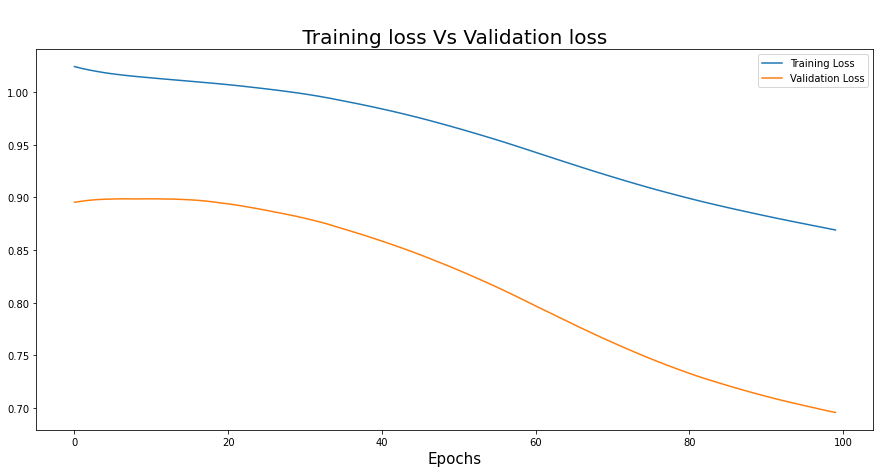

In [68]:
plot_graphs(model_3_v3_hist)

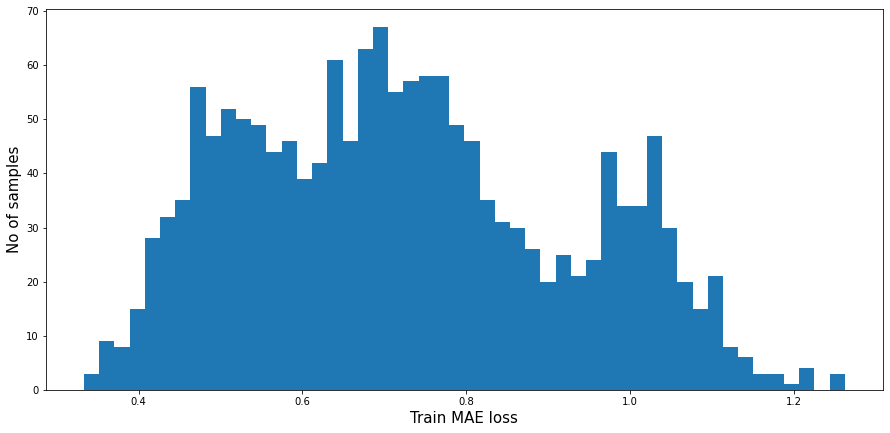

In [69]:
# Get train MAE loss.
x_train_pred = model_3_v3.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)
loss_plot(train_mae_loss)

In [70]:
# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)
thresholds.append(threshold)

Reconstruction error threshold:  1.262572278628096


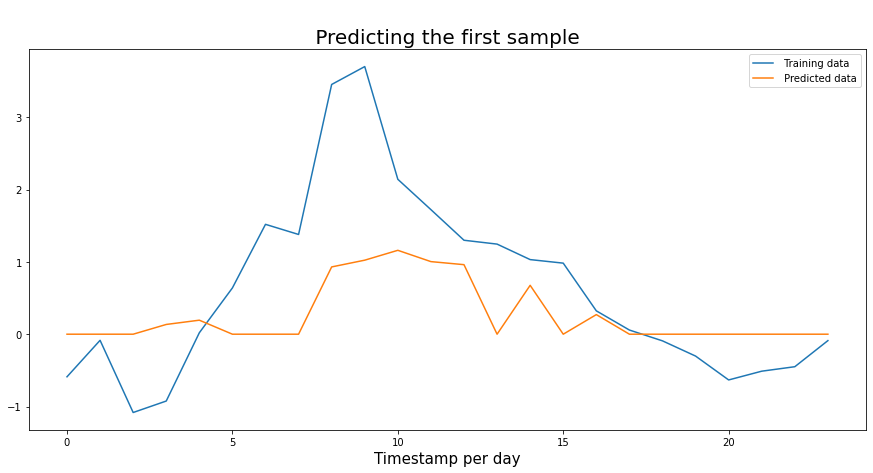

In [71]:
sample(x_train,x_train_pred)

Test input shape:  (1619, 24)


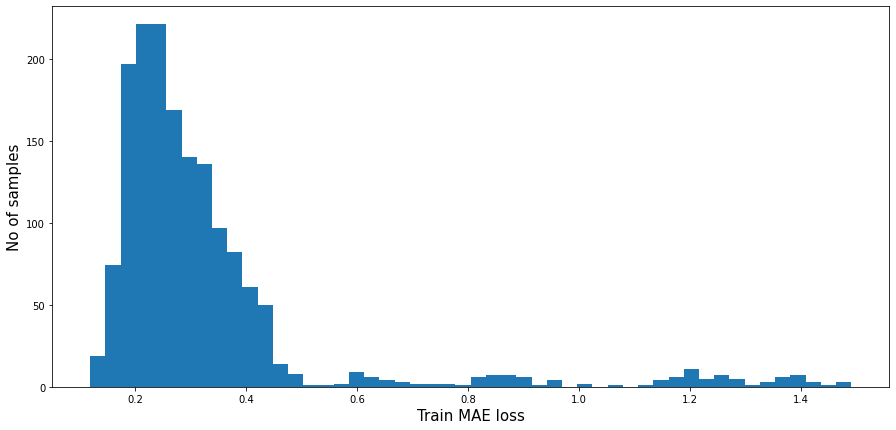

Number of anomaly samples:  30
Indices of anomaly samples:  (array([ 349,  350,  351,  352,  353,  354,  355,  356,  357,  358,  359,
        360,  361,  362,  363,  364,  365,  366,  367,  499,  501,  503,
        505, 1270, 1271, 1272, 1273, 1274, 1275, 1276]),)


In [72]:
x_test = create_sequences(testing_value, window_size)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model_3_v3.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape(-1)
loss_plot(test_mae_loss)

# Detect all the samples which are anomalies.
anomalies = (test_mae_loss > threshold).tolist()
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))
anomalies_detected.append(np.sum(anomalies))

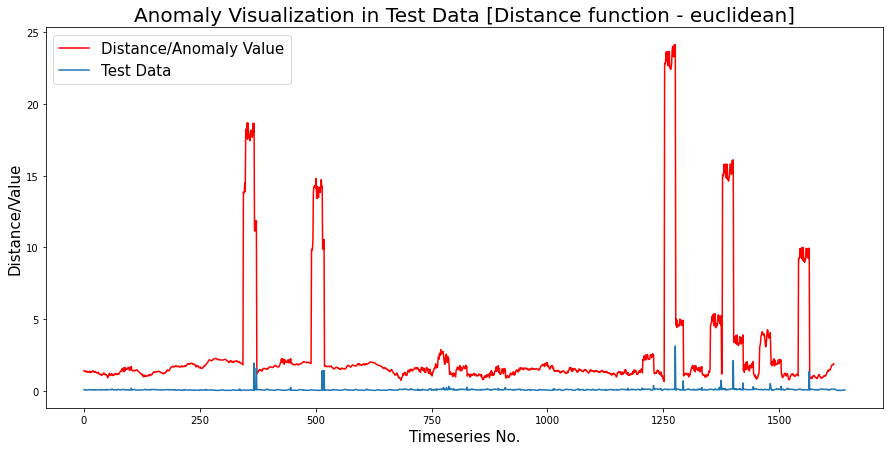

In [73]:
detect_anomaly(x_test,model_3_v3,'euclidean')

* From theses tuned models we can observe that the initial model performed better than these tuned model based on the sample plots and threshold

## 3. Observation
- From the implementations we can observe that the autoencoder with the LSTM has perfromed very well which can be clearly seen from the Sample plot and the threshold which is very less, when compared to the other model. This can be due to transfer of sequences from the previous layer. Therefore the model was able to reconstruct the input data more precisely than the others.

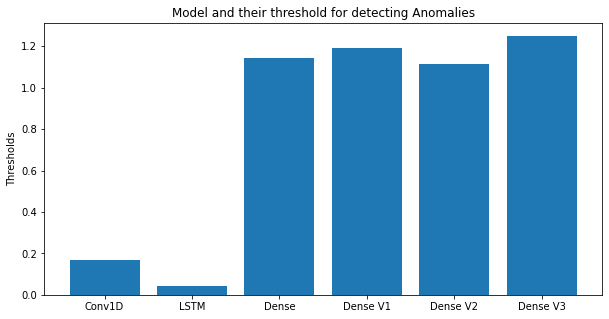

Text(0.5, 1.0, 'Model and their threshold for detecting Anomalies')

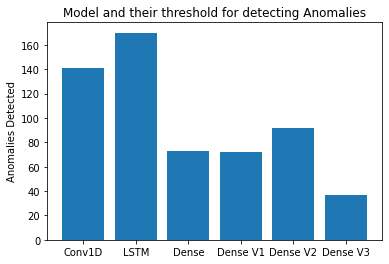

In [72]:
plt.figure(figsize=(10,5))
models=['Conv1D','LSTM','Dense','Dense V1','Dense V2','Dense V3']
plt.bar(models,thresholds)
plt.ylabel('Thresholds')
plt.title('Model and their threshold for detecting Anomalies')
plt.show()
plt.bar(models, anomalies_detected)
plt.ylabel('Anomalies Detected')
plt.title('Model and their threshold for detecting Anomalies')